In [2]:
import pandas as pd
import numpy as np 
import os 
import random
from PIL import Image
from sklearn.manifold import Isomap
import glob
import librosa
import matplotlib.pyplot as plt
import librosa.display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import Audio as aud
from sklearn import datasets,decomposition
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
print(os.getcwd())

C:\Users\distefano\data_science_project\audio


In [3]:
raw_dataset_path = os.path.join(os.getcwd(),'dataset','fake_audio')

In [ ]:
class fakeDataset():
    def __init__(self, audio_dataset_path,sample_duration_in=1):
        self.fake_audio_origin_path_list  = glob.glob(os.path.join(audio_dataset_path,'FAKE','*.wav'))
        self.real_audio_origin_path_list  = glob.glob(os.path.join(audio_dataset_path,'REAL','*.wav'))
        self.sr = 22050
        self.fr_len =2048
        self.hop_len = 512
        self.features_to_extract=None
        self.sample_duration = 3 if sample_duration_in ==None else sample_duration_in
        self.create_clip_dataset_from_raw()
        self.create_validation_train_split_idx(train_prc=0.75)
        
        #print('fake len',len(self.fake_audio_origin_path_list), 'real len', len(self.real_audio_origin_path_list))
        
        #check sr,duration 
        #fake_sr_uniq, fake_duration_uniq= self.check_info_dataset(self.fake_audio_origin_path_list)
        #real_sr_uniq, real_duration_uniq= self.check_info_dataset(self.real_audio_origin_path_list)
    def create_validation_train_split_idx(self,train_prc=0.75):
        data_len = len(self.fake_resample) + len(self.real_resample)
        train_len = int(train_prc*data_len)
        ids_to_shuffle = list(range(data_len))
        random.shuffle(ids_to_shuffle)
        self.ids_train = ids_to_shuffle[:train_len]
        self.ids_val = ids_to_shuffle[train_len:]
        print('train len:',len(self.ids_train))
        print('val len:',len(self.ids_val))
    def create_clip_dataset_from_raw(self):
        self.real_clip_list = self.split_dataset(self.real_audio_origin_path_list, sample_duration=self.sample_duration)[:5]
        self.fake_clip_list = self.split_dataset(self.fake_audio_origin_path_list, sample_duration=self.sample_duration)[:5]
        print('real clip list len:',len(self.real_clip_list))
        print('fake clip list len:',len(self.fake_clip_list))
        min_len = min([len(self.real_clip_list),len(self.fake_clip_list)])
        self.real_resample = self.random_resample(self.real_clip_list,max_len=min_len)
        self.fake_resample = self.random_resample(self.fake_clip_list,max_len=min_len)
        #create dataset 
        real_df = pd.DataFrame(self.real_resample)
        real_df['label'] = 'real'
        fake_df = pd.DataFrame(self.fake_resample)
        fake_df['label'] = 'fake'
        
        self.clip_dataset = pd.concat([real_df,fake_df],axis=0)
        print('real after resample:',len(self.real_resample))
        print('fake after resample:',len(self.fake_resample))
    def random_resample(self,sample,max_len=None):
        if len(sample)>max_len:
           #reduce sample
            print('***reducing sample***')
            #ids to take
            ids_to_take = np.random.choice(range(len(sample)),max_len,replace=False).tolist()
            return np.array(sample)[ids_to_take].tolist()
            #resample
        elif len(sample)<max_len:
            print('***increasing sample***')
            data_to_sample = max_len - len(sample)
            ids_to_resample = np.random.choice(range(len(sample)),data_to_sample,replace=True)
            return sample + [ sample[idx] for idx in ids_to_resample]
        print('*** no resampling***')
        return sample
    def check_info_dataset(self,path_file):
        sr_list = []
        duration_list = []
        for audio_ in path_file:
            audio_sample, audio_sr = librosa.load(audio_)
            audio_duration = {audio_sample.shape[0]/audio_sr}
            sr_list.append(audio_sr)
            duration_list.append(audio_duration)
        print('unique sr:', np.unique(sr_list))
        print('unique duration:', np.unique(duration_list))
        return np.unique(sr_list), np.unique(duration_list)
    def split_dataset(self,path_file, sample_duration=1):
        sample_list=[]
        for audio_ in path_file:
            audio_sample, audio_sr = librosa.load(audio_)
            #print('audio duration',librosa.get_duration(y=audio_sample,sr=audio_sr))
            clip_list = self.split_audio(audio_sample, audio_sr, sample_duration)
            sample_list= sample_list + clip_list
        print('total row:',len(sample_list))
        return sample_list
    def split_audio(self,sample, sr,clip_duration):
        clip_list = []
        for index_start in np.arange(0, len(sample)+1, sr*clip_duration):
            if len(sample)< index_start + sr:
                #print('len sample:',len(sample),'index start',index_start, 'index end:', index_start+sr*clip_duration)
                #print(f'[{index_start}:{index_start + sr*clip_duration}]')
                #padding 
                clip_tmp = sample[index_start:]
                clip_=librosa.util.fix_length(clip_tmp, size=sr*clip_duration)
                clip_list.append(clip_)
                return clip_list
            else:
                clip_ = sample[index_start:(index_start+sr*clip_duration)]
                clip_list.append(clip_)
        return clip_list
    def get_clip_dataset_split(self,split_name='train'):
        if split_name=='train':
            return self.clip_dataset.iloc[self.ids_train,:]
        return self.clip_dataset.iloc[self.ids_val,:]
    def create_feature_dataset(self):

        self.feature_dataset = self.extract_feature_per_data(self.clip_dataset)
        return self.feature_dataset, self.feature_dataset.iloc[self.ids_train,:],self.feature_dataset.iloc[self.ids_val,:]
        #fake_df = self.extract_feature_per_data(np.array(self.fake_resample),label_col=0)
        #real_df = self.extract_feature_per_data(np.array(self.real_resample),label_col=1)
        #self.feature_dataset = pd.concat([fake_df,real_df],axis=0)
        print('feature dataset shape:',self.feature_dataset.shape)
        
    def extract_feature_per_data(self,data):
        self.obs = []
        for index, row in data.iterrows():
            obs_feature= self.extract_feature_per_sample(clip=row[:-1].to_numpy(dtype=np.float64),to_extract=self.features_to_extract)
            obs_feature['label']=row.label
            self.obs.append(obs_feature)
        pd_df = pd.DataFrame(self.obs)
        return pd_df 
    def extract_feature_per_data2(self,data,label_col=0):
        self.obs = []
        for row in data:
            obs_feature= self.extract_feature_per_sample(clip=row,to_extract=self.features_to_extract)
            self.obs.append(obs_feature)
        pd_df = pd.DataFrame(self.obs)
        pd_df['label'] = label_col
        return pd_df 
    def get_default_feature(self):
        return {
                'zero_cross_rate':None,
                'spec_rolloff':None,
                'spec_centroid':None,
                #'chroma': {'bin':15},
                'rmse': None,
                'bandwidth':None,
                'mfccs': {'n_mfcc':20},
                'flatness':None
                    
                    }
    def extract_feature_per_sample(self,clip,to_extract=None):
        feature_to_calculate = self.get_default_feature()  if to_extract==None else to_extract
        features_row = {}
        for feature_ in feature_to_calculate:
            if feature_ =='zero_cross_rate':
                zero_crossings_rate = librosa.feature.zero_crossing_rate(y=clip, frame_length=self.fr_len, hop_length=self.hop_len, pad=True)[0]
                features_row=self.aggregate_feature(feature_,zero_crossings_rate,features_row)
            elif feature_=='spec_rolloff':
                spec_rolloff = librosa.feature.spectral_rolloff(y=clip, sr=self.sr)[0]
                features_row = self.aggregate_feature(feature_,spec_rolloff,features_row)
            elif feature_=='spec_centroid':
                spec_centroid = librosa.feature.spectral_centroid(y=clip, sr=self.sr)[0]
                features_row = self.aggregate_feature(feature_,spec_centroid,features_row)
            elif feature_=='chroma':
                n_bins = feature_to_calculate[feature_]['bin']
                chroma_vq = librosa.feature.chroma_vqt(y=clip, sr=self.sr,bins_per_octave=n_bins, intervals='equal')
                features_row = self.aggregate_feature(feature_,chroma_vq,features_row)
            elif feature_=='rmse':
                S, phase = librosa.magphase(librosa.stft(y=clip, n_fft=self.fr_len,  hop_length=self.hop_len ))
                rms = librosa.feature.rms(S=S)[0]
                features_row = self.aggregate_feature(feature_,rms,features_row)
            elif feature_=='bandwidth':
                spec_bw = librosa.feature.spectral_bandwidth(y=clip, sr=self.sr,n_fft=self.fr_len,  hop_length=self.hop_len )[0]
                features_row = self.aggregate_feature(feature_,spec_bw,features_row)
            elif feature_=='flatness':
                flatness = librosa.feature.spectral_flatness(y=clip,n_fft=self.fr_len,  hop_length=self.hop_len )[0]
                features_row = self.aggregate_feature(feature_,flatness,features_row)
            elif feature_=='mfccs':
                n_mfcc_in = feature_to_calculate[feature_]['n_mfcc']
                mfccs = librosa.feature.mfcc(y=clip, sr=self.sr, n_mfcc=n_mfcc_in)
                features_row = self.aggregate_feature(feature_,mfccs,features_row)
        return features_row
    def aggregate_feature(self,feature_name, feature_value, features_row):
        #print('feature name:',feature_name)
        if len(feature_value.shape)>1 and feature_value.shape[1]>0:
            #print('fe nae',feature_name,'matrix', feature_value.shape)
            feature_mean = np.mean(feature_value,axis=1)
            feature_max = np.max(feature_value,axis=1)
            feature_std = np.std(feature_value,axis=1)
            for idx in range(feature_value.shape[0]):
                features_row[feature_name+f'__mean{idx}'] = feature_mean[idx]
                features_row[feature_name+f'__max{idx}'] = feature_max[idx]
                features_row[feature_name+f'__std{idx}'] = feature_std[idx]
        else:
            #print('values', feature_value.shape)
            features_row[feature_name+'__mean']=np.mean(feature_value)
            features_row[feature_name+'__max']=np.max(feature_value)
            features_row[feature_name+'__std']=np.std(feature_value)
        return features_row
   
    def compute_mel_spectogram(self,audio, sr_in, n_fft_in, hop_len_in, n_mels_in):
        #(nmel coefficients x nframe)
        S = librosa.feature.melspectrogram(y=audio, sr=sr_in, n_fft=n_fft_in, hop_length=hop_len_in, n_mels=n_mels_in)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return S_DB
    def standardization_spectogram(self,spect_in):
        mean_spect = spect_in.mean()
        std_spect = spect_in.std()
        spec_norm = (spect_in - mean_spect) / (std_spect + 0.0001)
        return spec_norm
    def scaling_spectogram(self,spect_in):
        spec_min, spec_max = spect_in.min(), spect_in.max()
        spec_scaled = 255 * (spect_in - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled
    def show_spectogram(self,spec_in,yaxis_in='mel'):
        fig, ax = plt.subplots()
        img = librosa.display.specshow(spec_in, ax=ax, y_axis=yaxis_in, x_axis='time')
        fig.colorbar(img, ax=ax)
    def save_spectogram(self,spec_in,yaxis_in='mel',dpi_in=300,path_out='.',name_out='0.png'):
        with plt.ioff():
            plt.figure()
            ax = plt.axes()
            ax.set_axis_off()
            librosa.display.specshow(spec_in, ax=ax, y_axis=yaxis_in, x_axis='time')
            plt.savefig(os.path.join(path_out,name_out),dpi=300)
            plt.close()
    def load_img(self,path):
        return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    def show_img(self,img_in):
        plt.imshow(img_in)
    def save_img(self,img, path):
        img = Image.fromarray(img)
        img.save(path)
    def create_spectogram_dataset(self,data, yaxis_in='mel',is_train=True):
        split_folder = 'train' if is_train==True else 'val'
        print(f'***create spectogram dataset: {split_folder}***')
        for index, row in data.iterrows():
            if index%100==0:
                print(f'***{index}***')
            mel_spec = self.compute_mel_spectogram(audio=row[:-1].to_numpy(dtype=np.float64) , sr_in=self.sr, n_fft_in=self.fr_len, hop_len_in=self.hop_len, n_mels_in=128)
            
            label_folder = row.label
            img_name = f'{yaxis_in}_{split_folder}_{label_folder}_{index}.png'
            path_out=os.path.join(os.getcwd(),'dataset','fake_audio','modeling','image_dataset',split_folder,label_folder)
            self.save_spectogram(spec_in=mel_spec,yaxis_in=yaxis_in,dpi_in=300,path_out=path_out,name_out=img_name)

In [ ]:
fakeDataset = fakeDataset(audio_dataset_path=raw_dataset_path,sample_duration_in=1)

In [ ]:
fakeDataset.create_spectogram_dataset(data=fakeDataset.get_clip_dataset_split(split_name='train'), yaxis_in='mel',is_train=True)

In [ ]:
fakeDataset.create_spectogram_dataset(data=fakeDataset.get_clip_dataset_split(split_name='val'), yaxis_in='mel',is_train=False)

In [6]:
#create feature dataset
f_all, f_train, f_val = fakeDataset.create_feature_dataset()

In [ ]:
f_train.to_csv(os.path.join(os.getcwd(),'dataset','fake_audio','modeling','feature_dataset','train','feature_train_1s.csv'),index=False)

In [ ]:
f_val.to_csv(os.path.join(os.getcwd(),'dataset','fake_audio','modeling','feature_dataset','val','feature_val_1s.csv'),index=False)

In [ ]:
#save all 
f_all.to_csv(os.path.join(os.getcwd(),'dataset','fake_audio','modeling','feature_dataset','feature_dataset_1s.csv'),index=False)

In [4]:
#read csv
feature_data = pd.read_csv(os.path.join(os.getcwd(),'dataset','fake_audio','modeling','feature_dataset','feature_dataset_1s.csv'),header=0)
feature_data_predictors= list(set(feature_data.columns) - set(['label']))
print('feature_data',feature_data.shape)

feature_data (7500, 79)


In [7]:
feature_data_predictors

['mfccs__std3',
 'mfccs__mean17',
 'mfccs__max11',
 'mfccs__max18',
 'mfccs__std15',
 'mfccs__std16',
 'mfccs__mean19',
 'mfccs__mean15',
 'mfccs__mean2',
 'flatness__mean',
 'mfccs__mean6',
 'mfccs__std14',
 'mfccs__std12',
 'mfccs__mean14',
 'mfccs__mean16',
 'mfccs__max7',
 'mfccs__max3',
 'mfccs__std5',
 'mfccs__std2',
 'mfccs__max12',
 'mfccs__max13',
 'bandwidth__std',
 'rmse__std',
 'spec_rolloff__mean',
 'mfccs__max6',
 'spec_rolloff__std',
 'mfccs__max10',
 'mfccs__mean1',
 'mfccs__max1',
 'mfccs__mean8',
 'mfccs__max19',
 'mfccs__mean4',
 'mfccs__std19',
 'mfccs__std17',
 'mfccs__mean0',
 'mfccs__mean13',
 'zero_cross_rate__mean',
 'spec_centroid__mean',
 'mfccs__std7',
 'rmse__max',
 'mfccs__max9',
 'mfccs__mean18',
 'spec_centroid__std',
 'spec_rolloff__max',
 'mfccs__max5',
 'spec_centroid__max',
 'bandwidth__max',
 'mfccs__mean9',
 'flatness__max',
 'mfccs__max0',
 'rmse__mean',
 'mfccs__max15',
 'mfccs__std11',
 'mfccs__mean3',
 'mfccs__std10',
 'mfccs__max17',
 'mfccs__

## EDA  - (before clustering)

feature selection before clustering (reducing complexity and avoid curse of dimensionality issue)
1) manual single feature comparison using cdf
2) automatic feature selection by checking spearman correlation 
3) automatic feature reduction using PCA or nonlineare method like isomap 



In [21]:
def estimate_kmean_para(X,max_cluster=8):
    n_clusters_range = range(2,max_cluster)
    for n_clusters in n_clusters_range:
        kmean_cl = KMeans(n_clusters=n_clusters, n_init="auto", random_state=1110)
        kmean_labels = kmean_cl.fit_predict(X)
        #average silhouette_score for all the samples.
        silhouette_avg = silhouette_score(X, kmean_labels)
        print("n_clusters:",n_clusters,"average silhouette :",silhouette_avg)
        #silhouette scores for each sample
        sample_silhouette_val = silhouette_samples(X, kmean_labels)
        all_deviation_sil=[]
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i
            silhouette_per_cluster = sample_silhouette_val[kmean_labels == i]
            sil_mean_per_cluster = np.mean(silhouette_per_cluster)
            dev_from_global_mean= ((sil_mean_per_cluster - silhouette_avg)**2)
            all_deviation_sil.append(dev_from_global_mean)
        print('***stat on deviation***')
        print('mean',np.sqrt(np.mean(all_deviation_sil)))
        print('max',np.max(np.sqrt(all_deviation_sil)))

#### eda - single feature comparison using CDF (cumulative distribution function)


In [18]:
def show_specific_ecdf(data_in=None, var_in=None,hue=None,dpi_in=200,y_values=[0.25,0.5,0.75,0.9],x_min=-1,x_max=100,fig_size_in=(8,4)):
    fig, ax = plt.subplots(figsize=(fig_size_in))
    plt.rcParams['figure.dpi'] = dpi_in
    g=sns.ecdfplot(data=data_in, x=var_in, hue=hue, ax=ax)
    if y_values is not None:    
        for line in ax.get_lines():
            x, y = line.get_data()
            for y_to_plot in y_values:
                ind = np.argwhere(y >= y_to_plot)[0, 0]  
                ax.text(x[ind], y_to_plot, f' {x[ind]:.0f}', ha='left', va='top',color=line.get_color())
                ax.axhline(y_to_plot, linestyle='--', color='#cfcfcf', lw=2, alpha=0.75)
    g.set(title=f" {var_in} distribution")
    plt.xlim(x_min, x_max)
    plt.show()

In [19]:
feature_to_evaluate = list(set(feature_data_predictors))#-set(feature_to_exclude))
print('feature to evaluate:',len(feature_to_evaluate))

feature to evaluate: 78


In [7]:
minmax_corr = MinMaxScaler()
X_scaled = pd.DataFrame(minmax_corr.fit_transform(feature_data.loc[:,feature_to_evaluate]),columns=feature_to_evaluate)*100
X_scaled['label']=feature_data.label

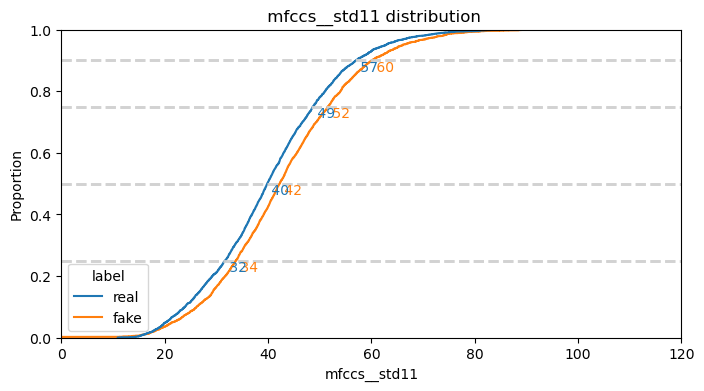

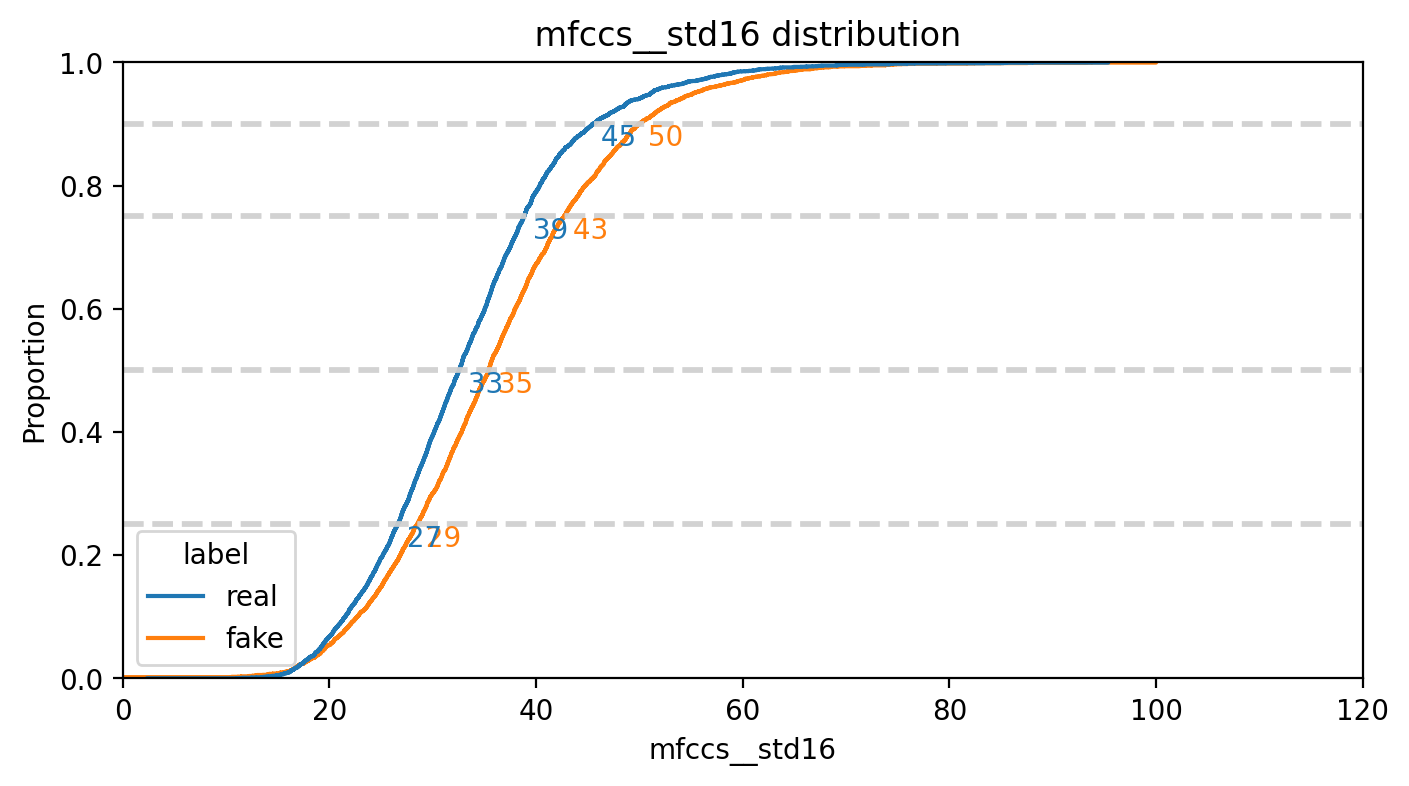

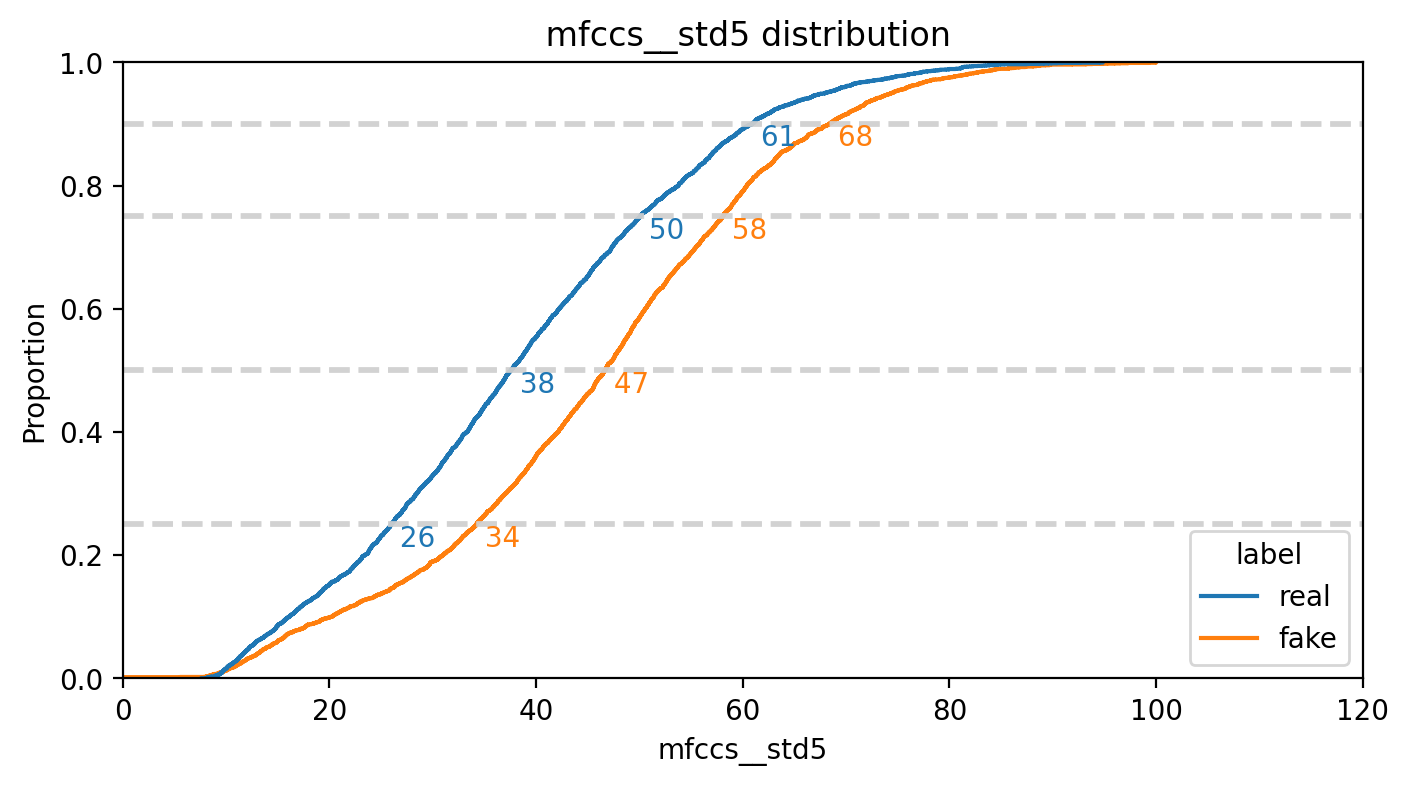

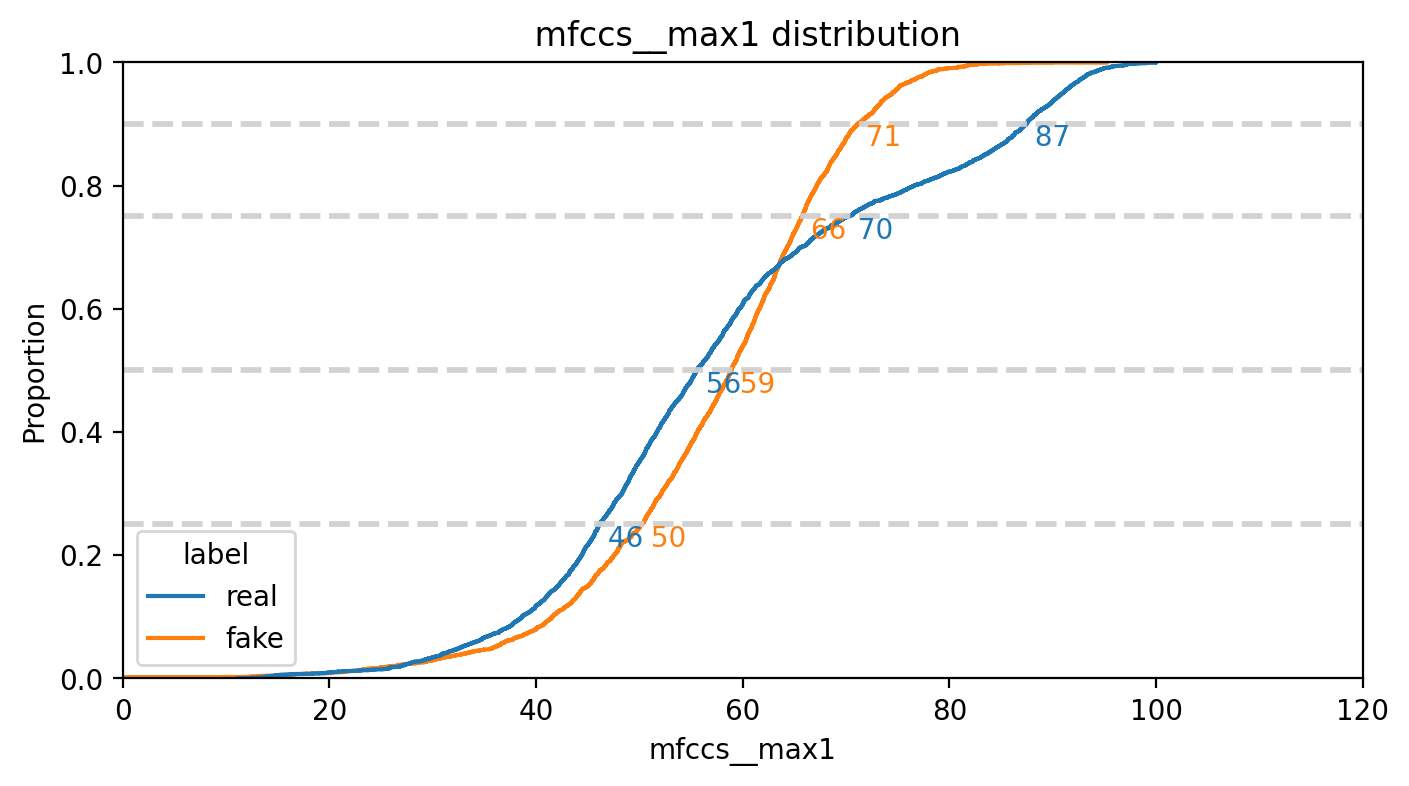

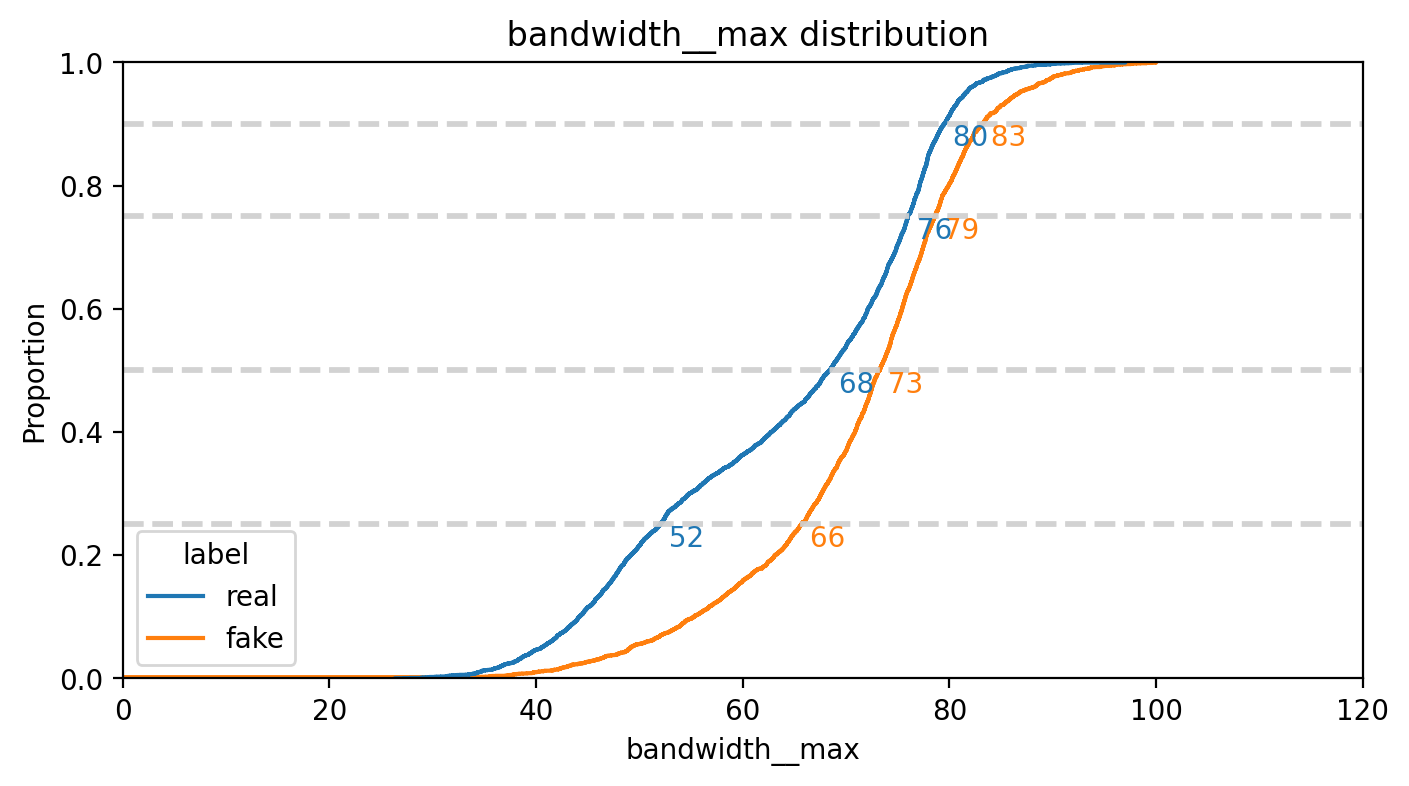

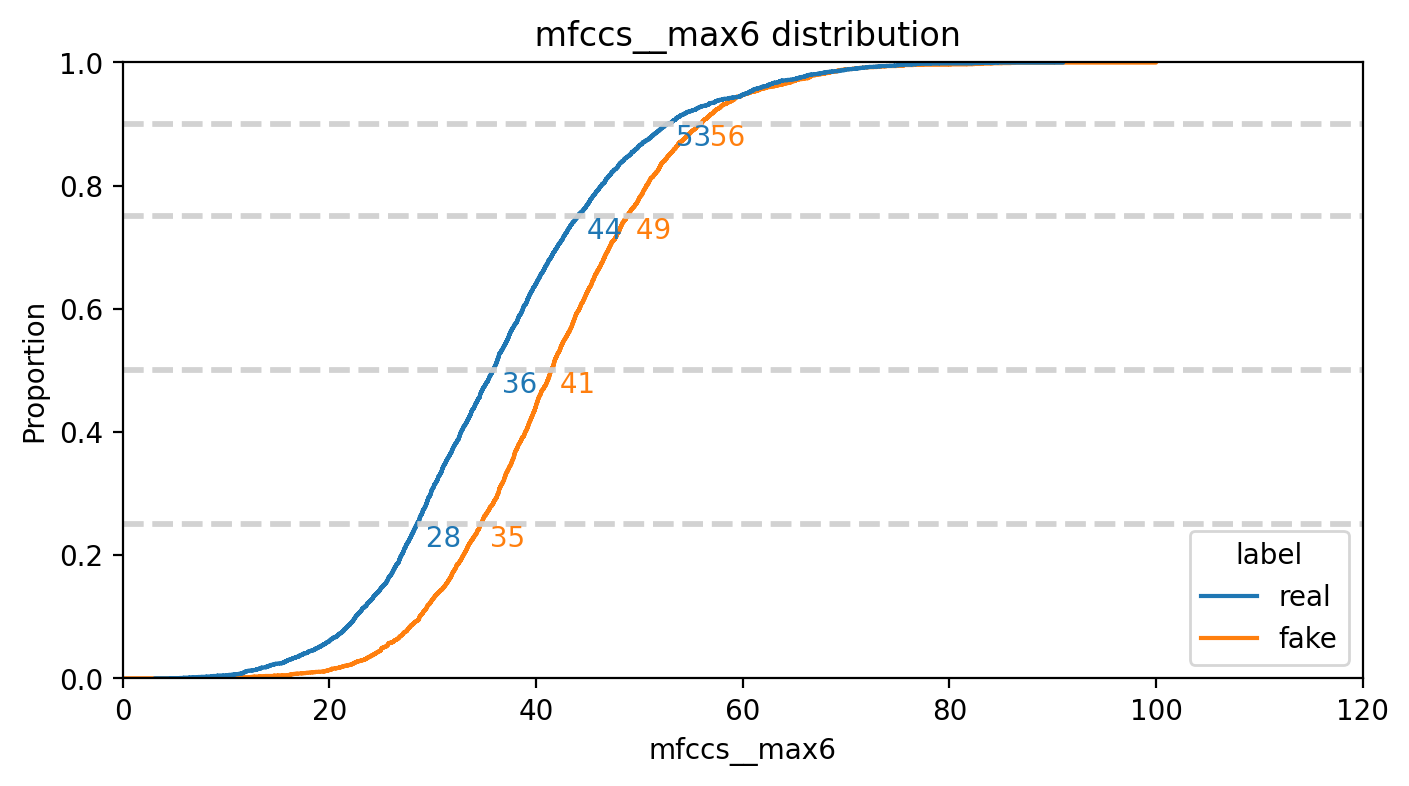

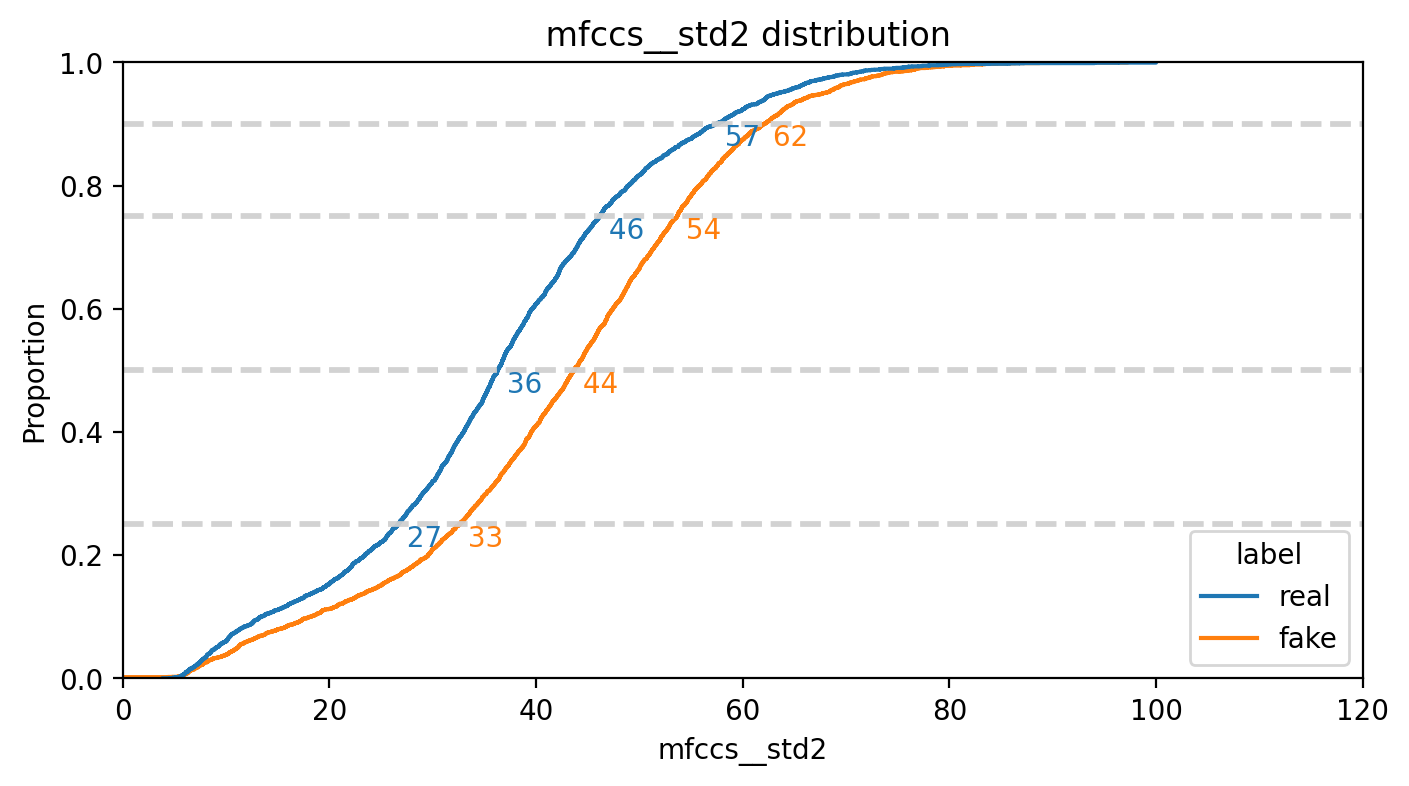

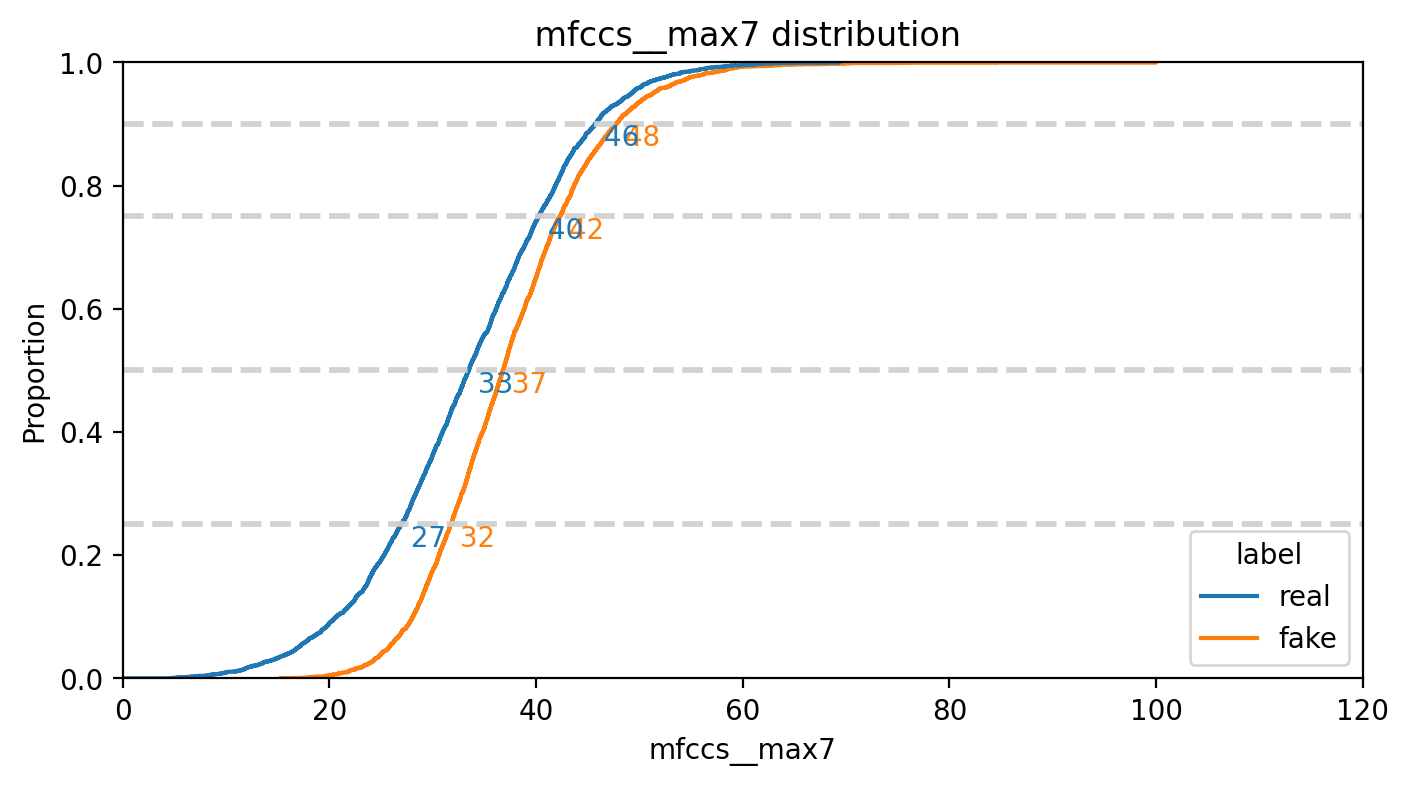

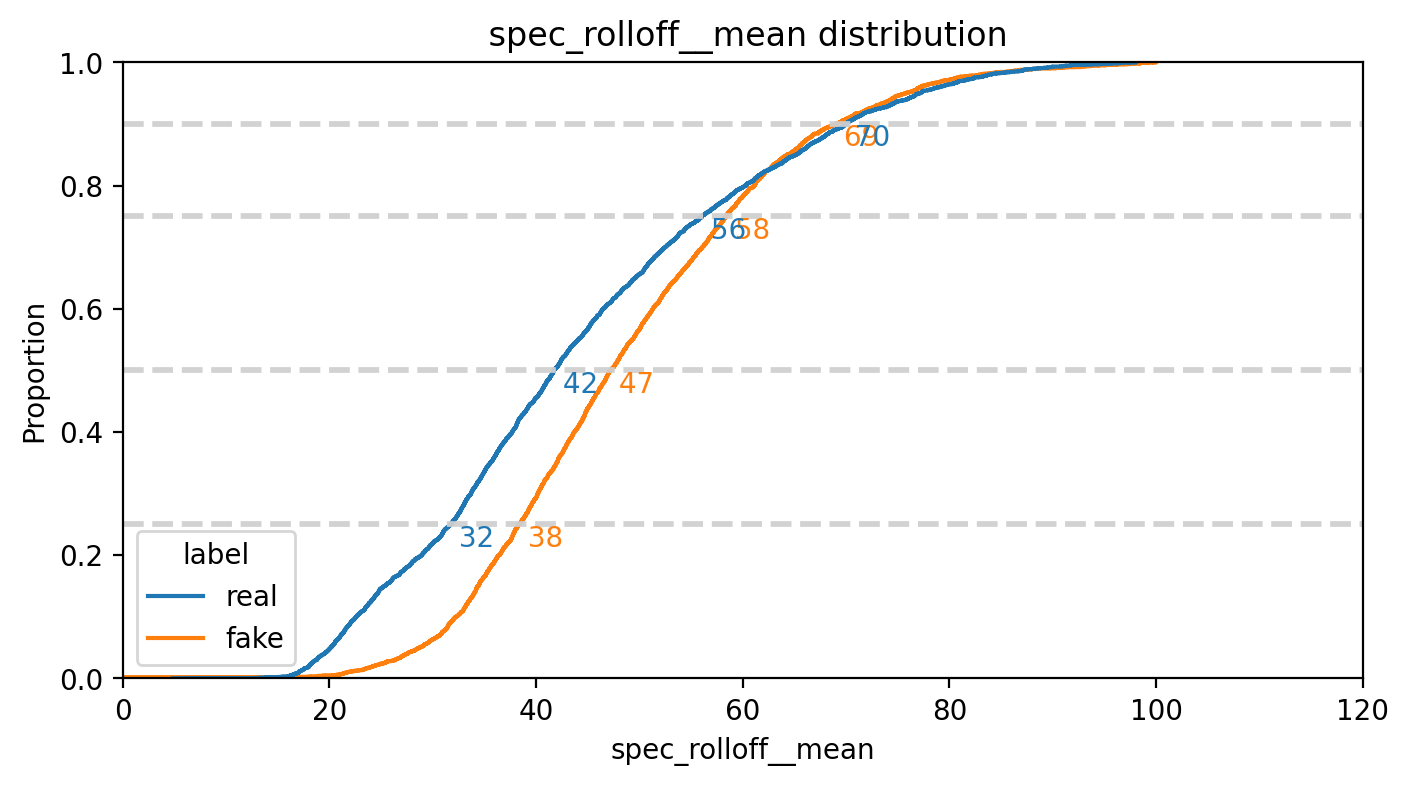

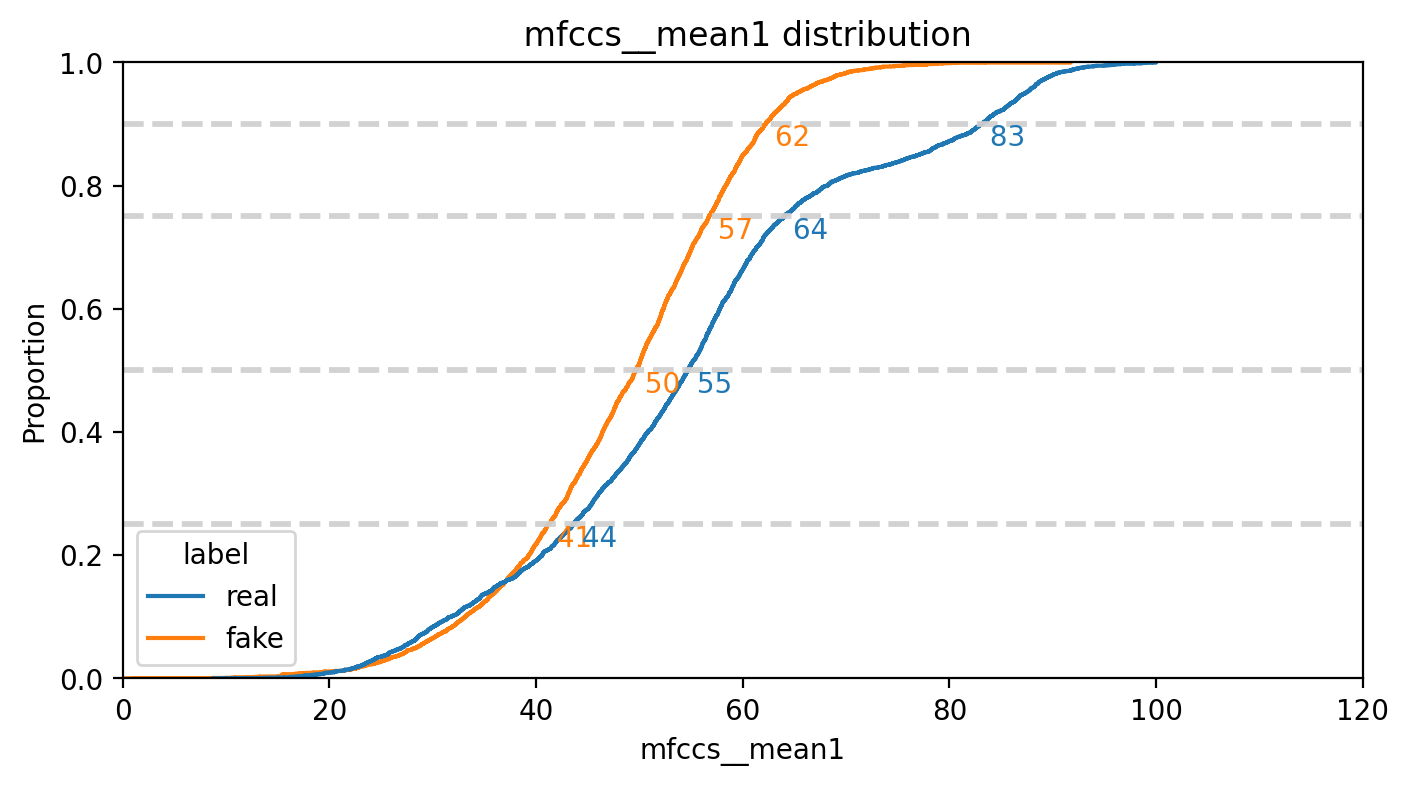

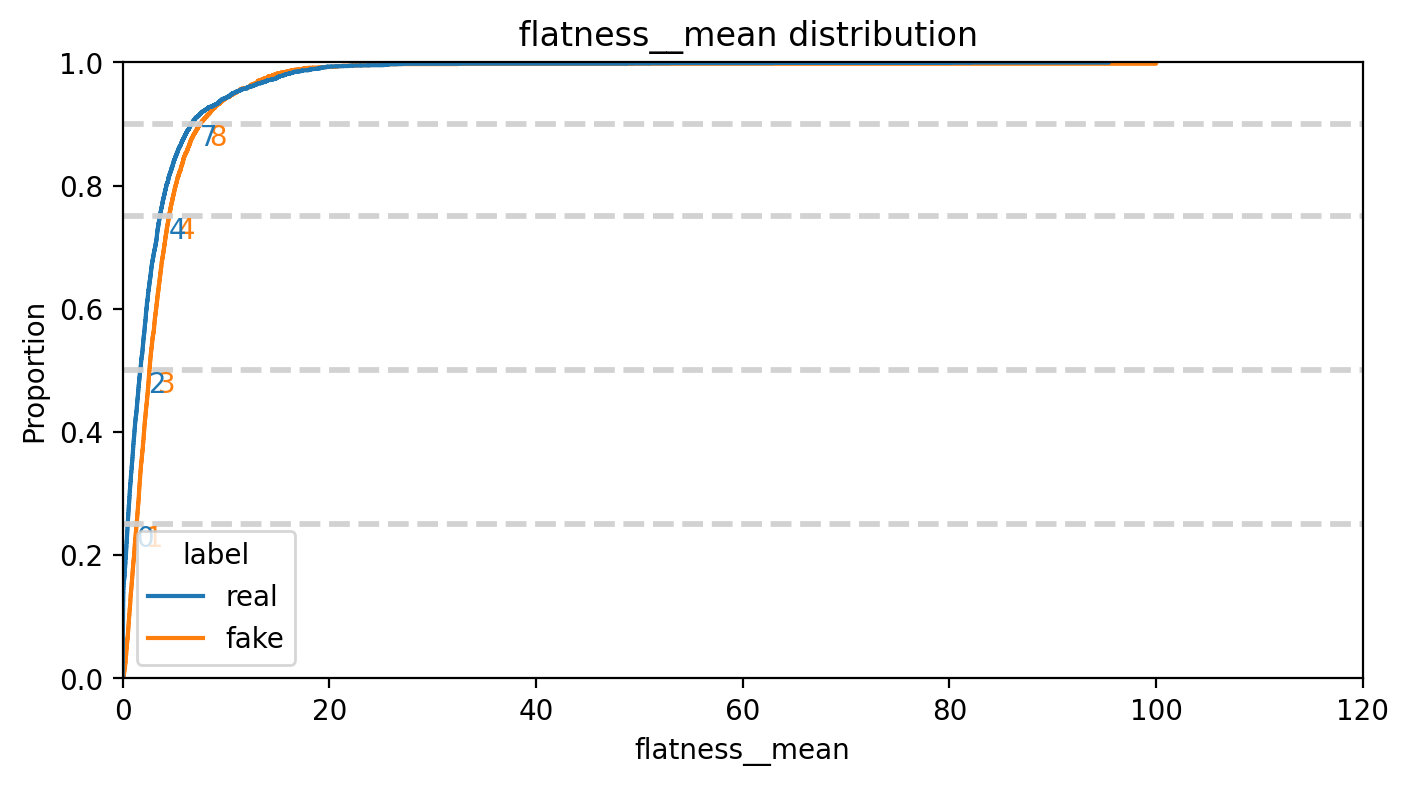

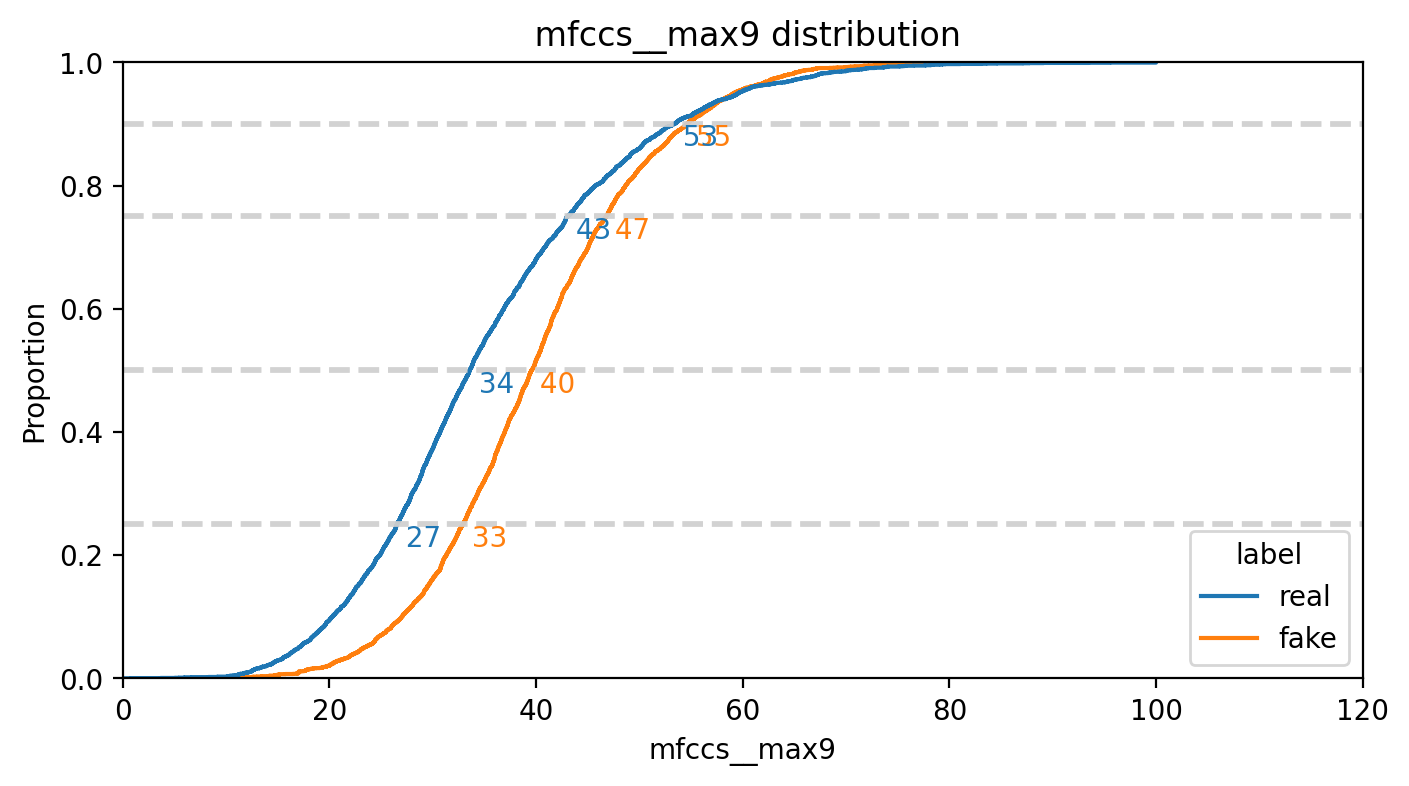

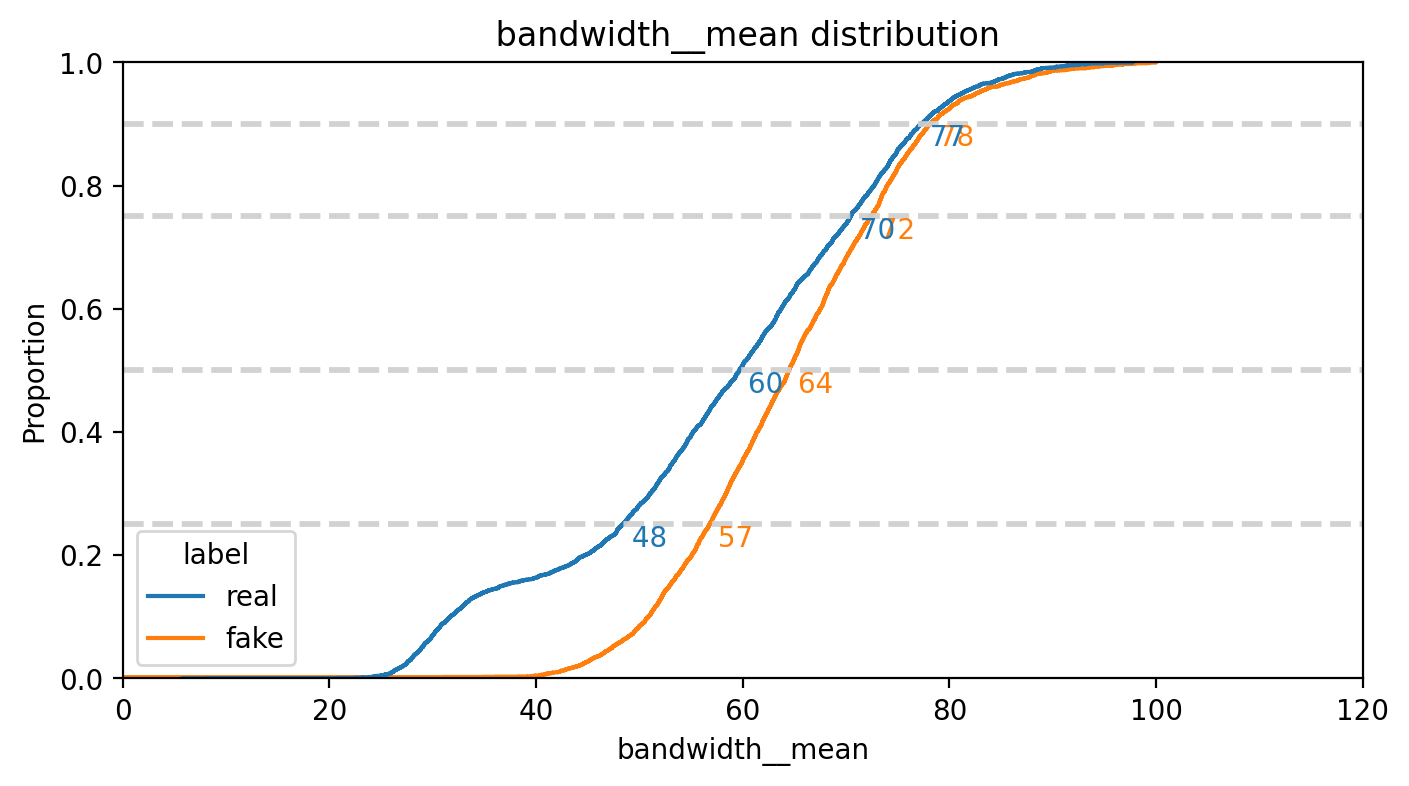

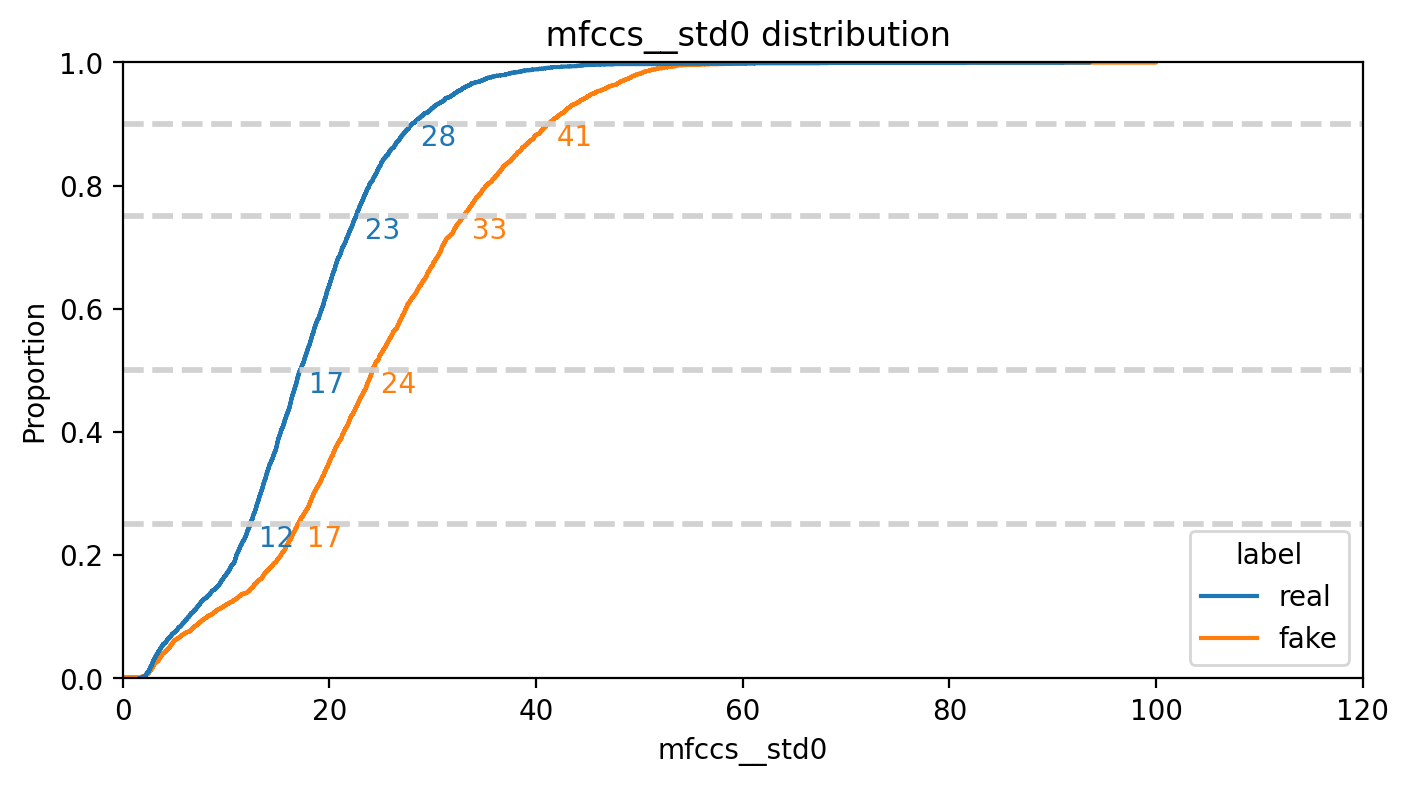

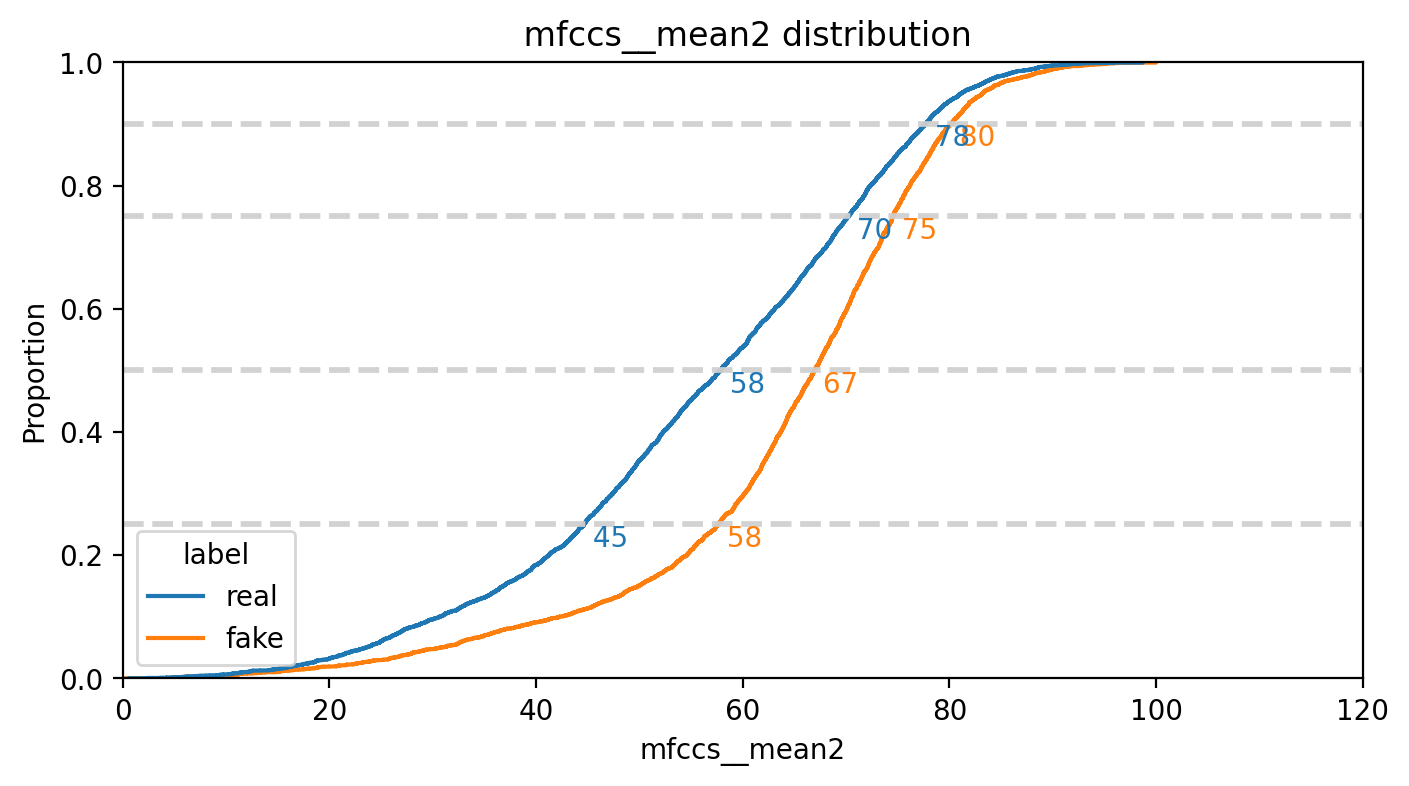

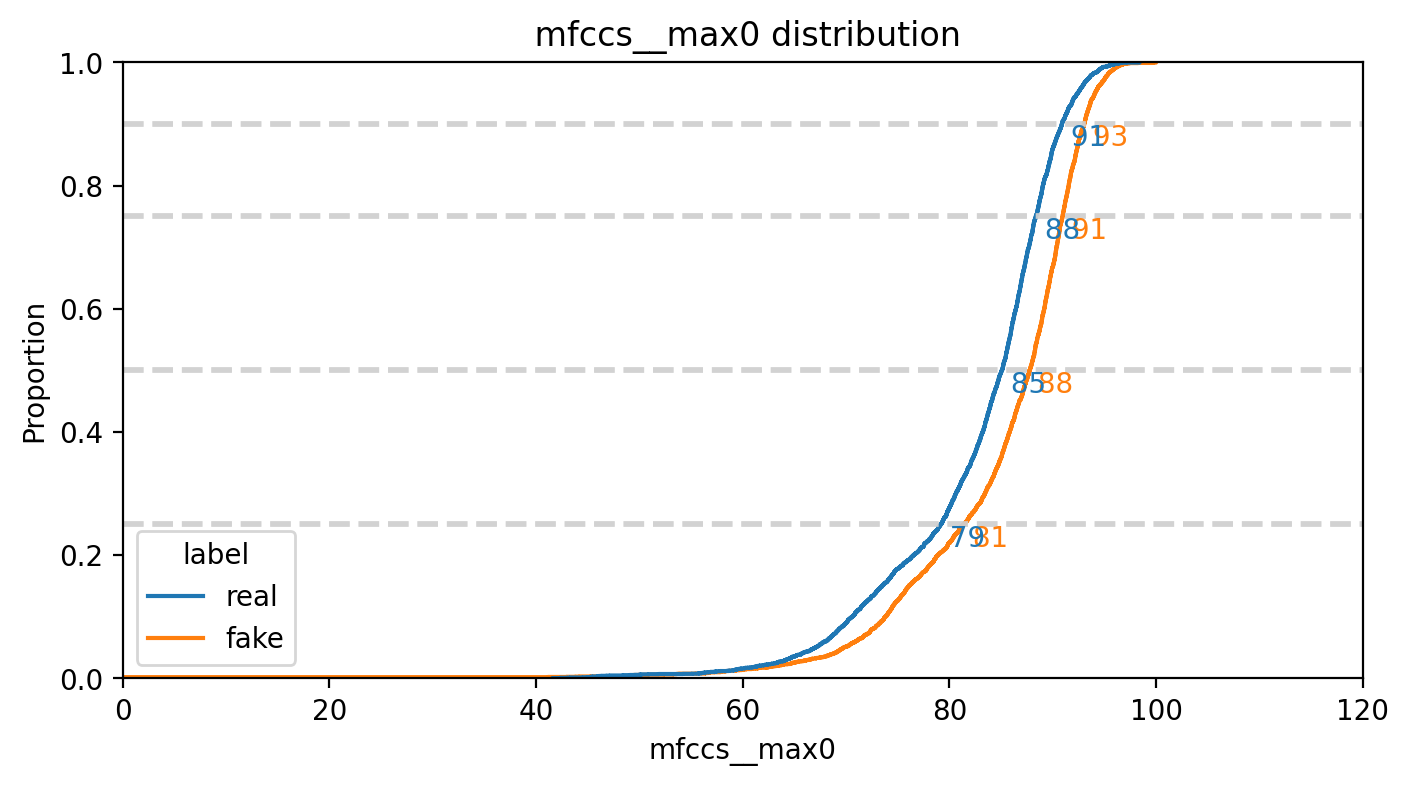

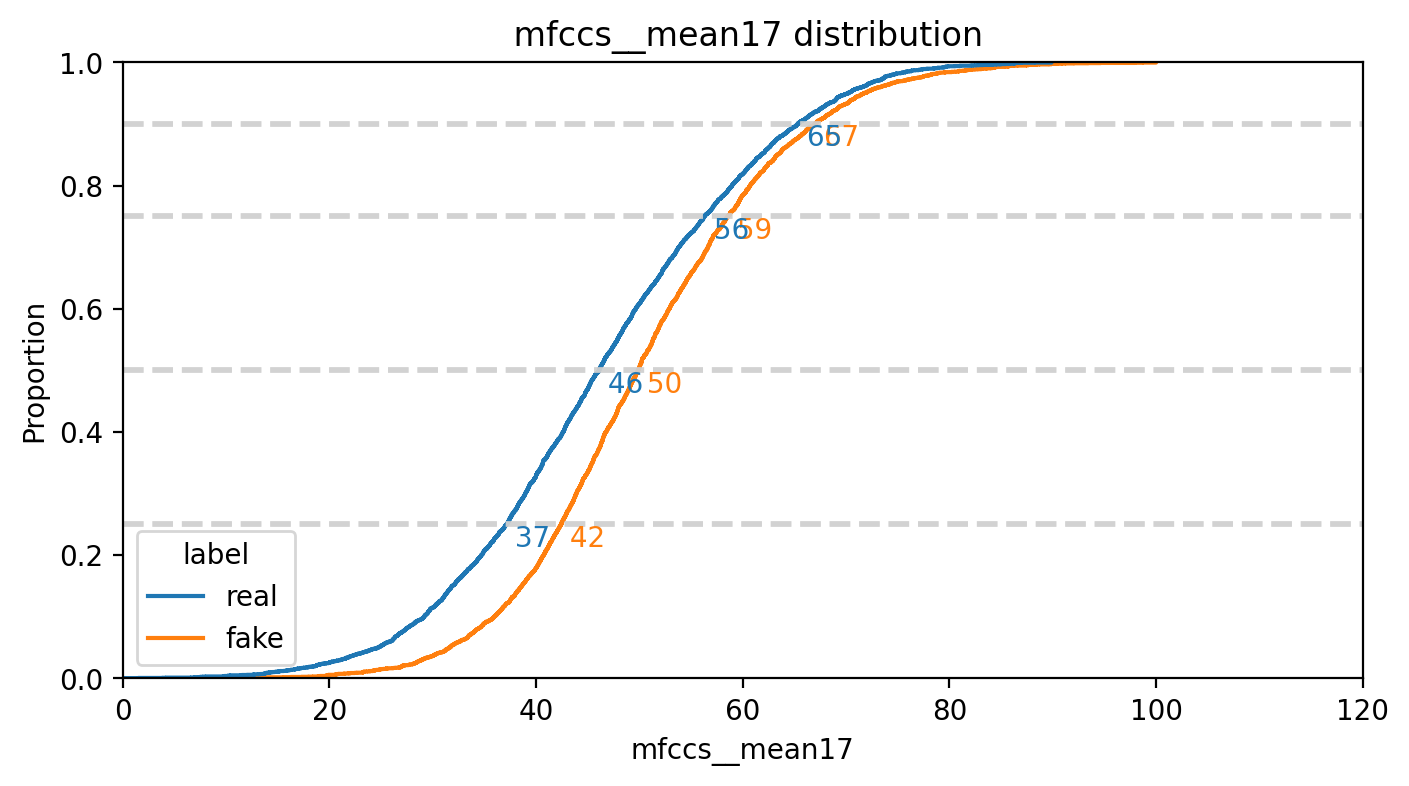

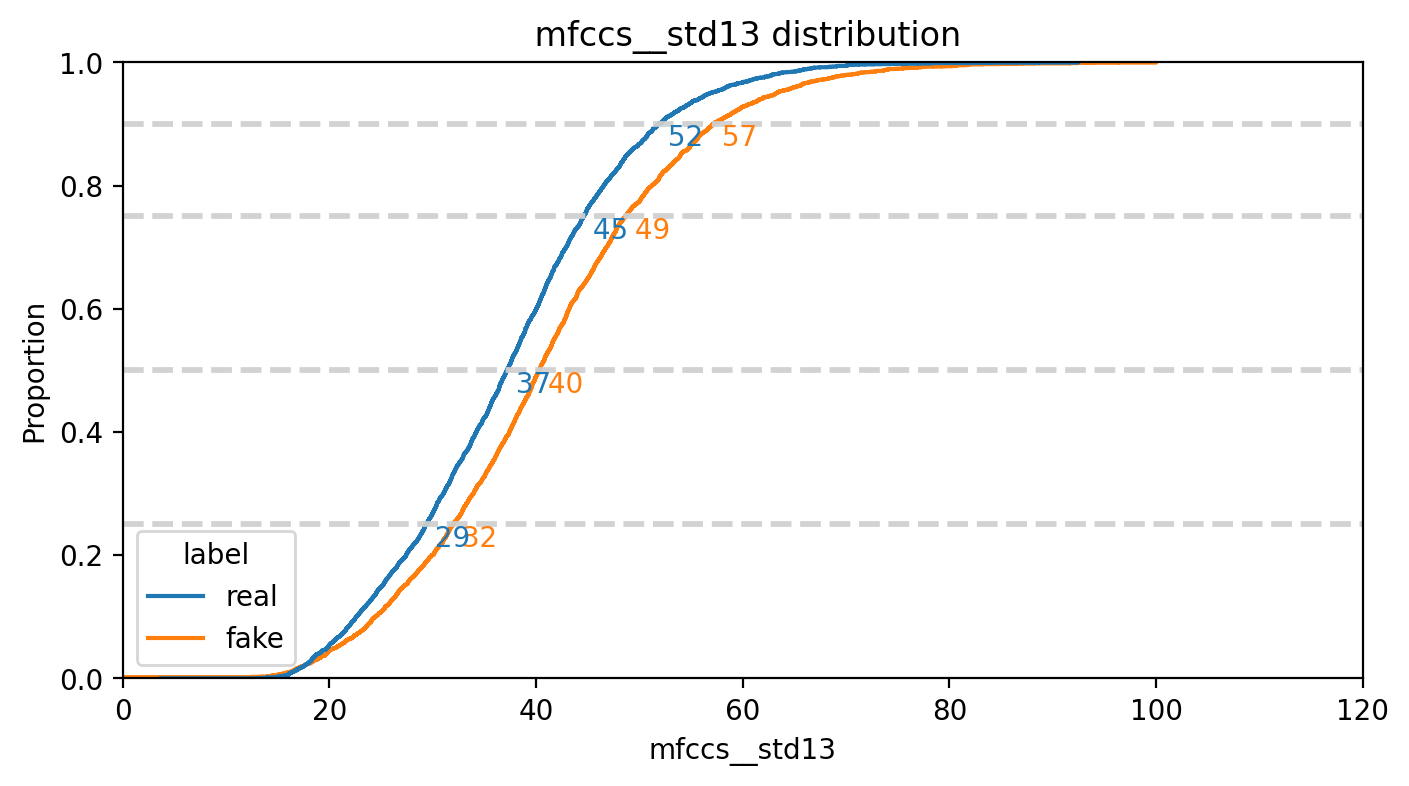

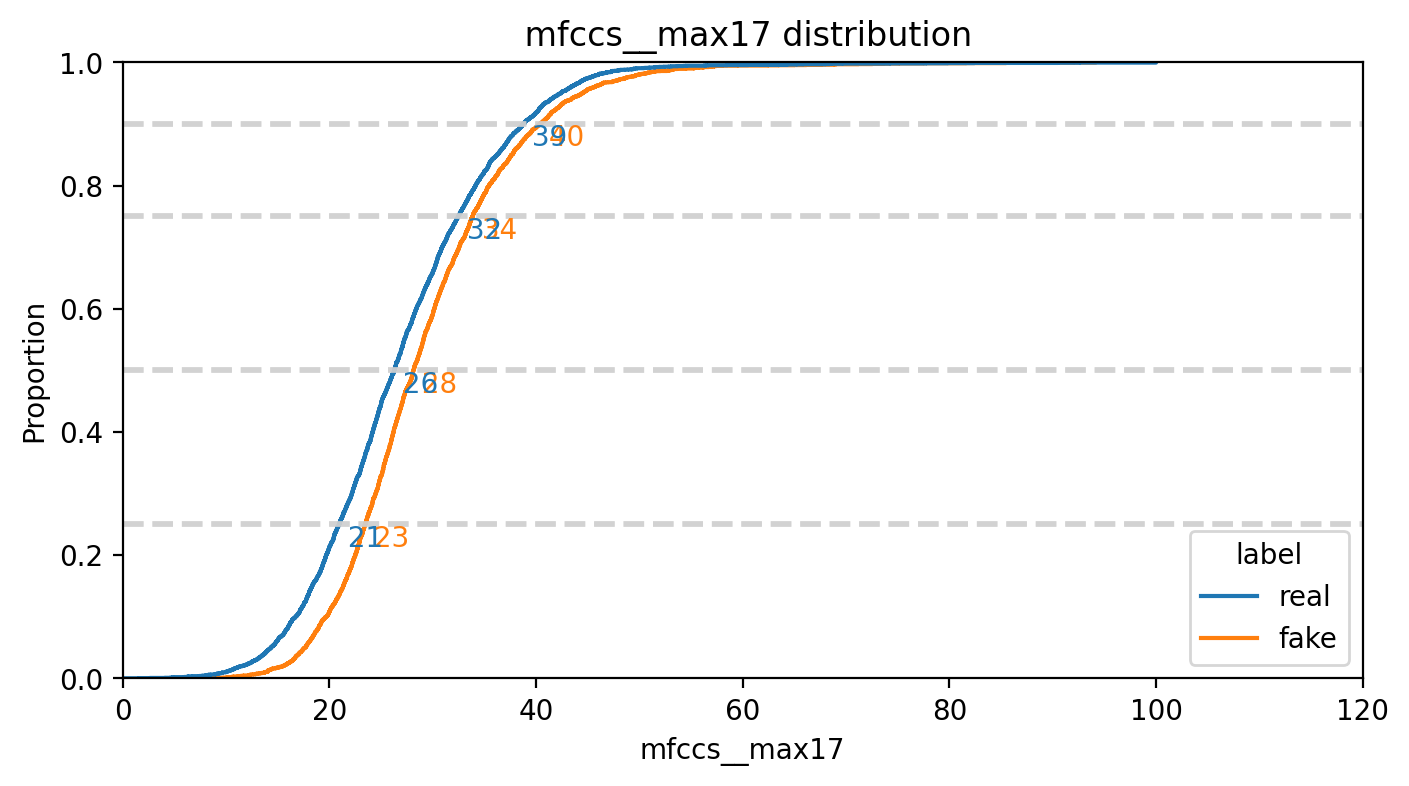

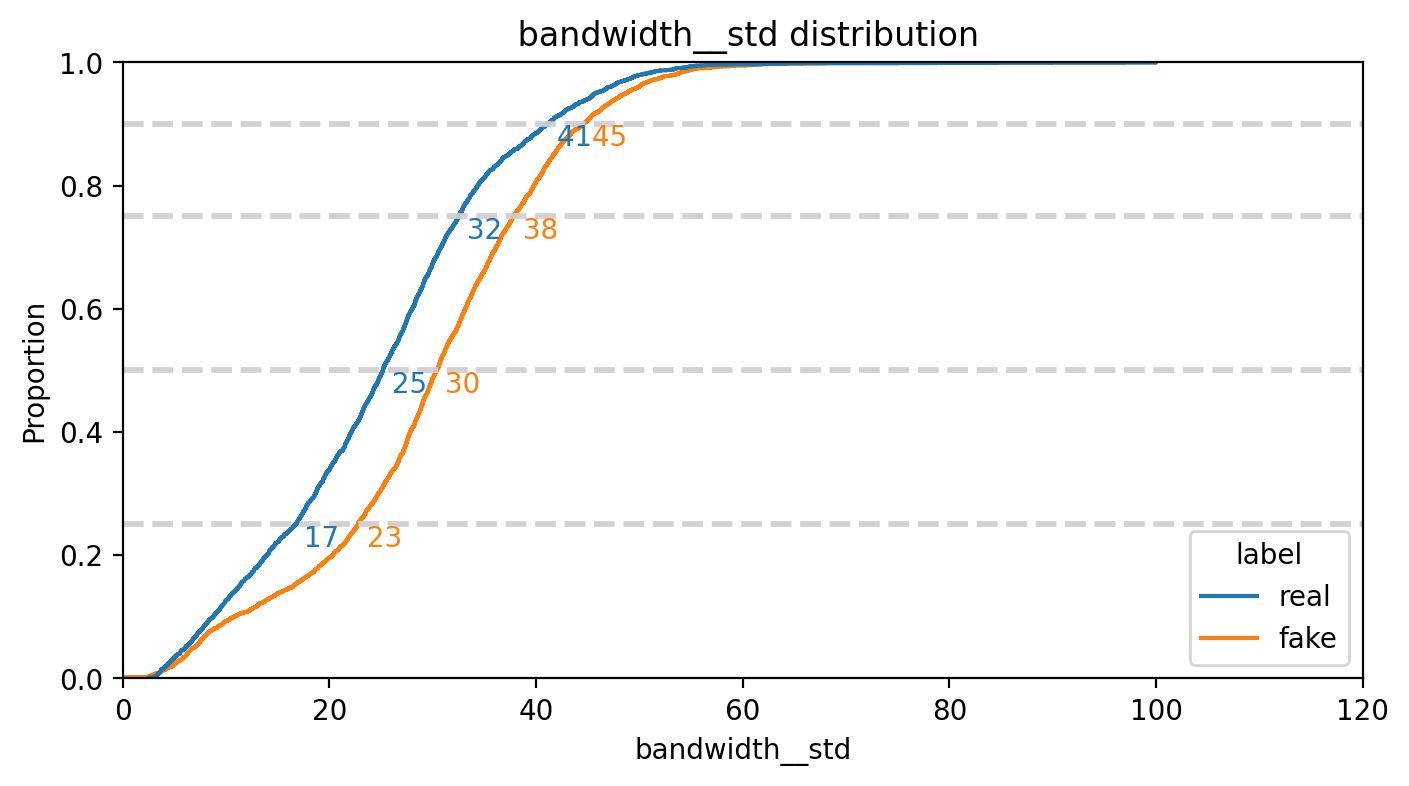

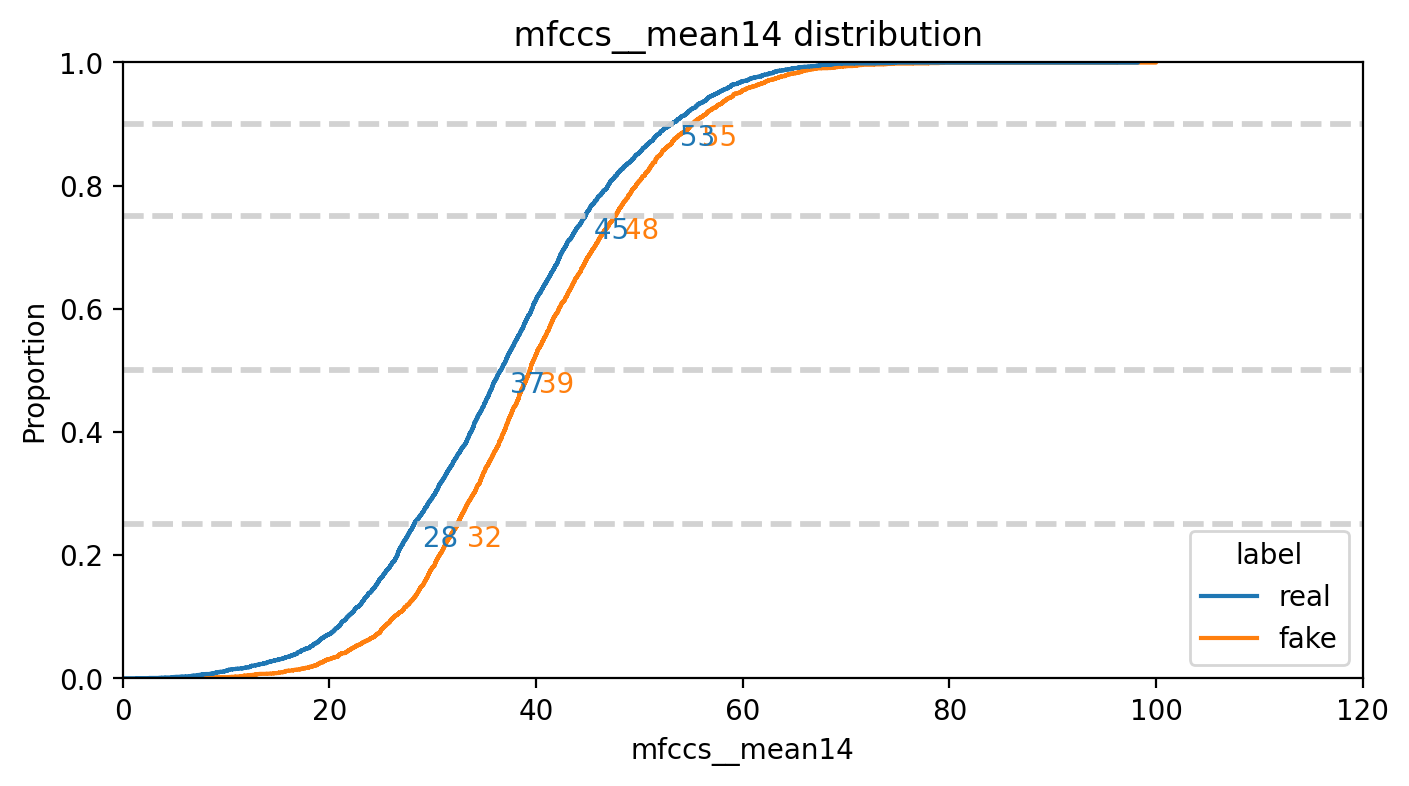

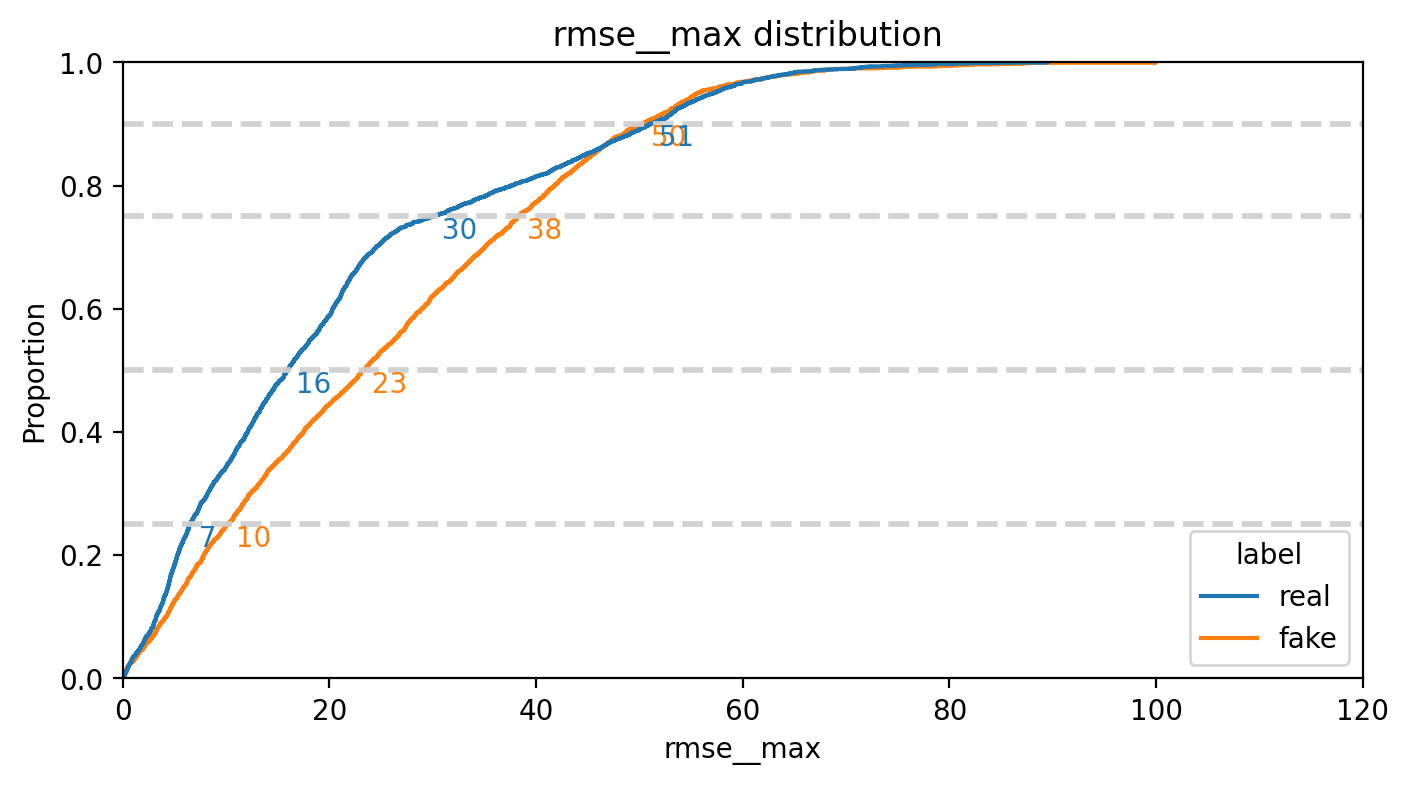

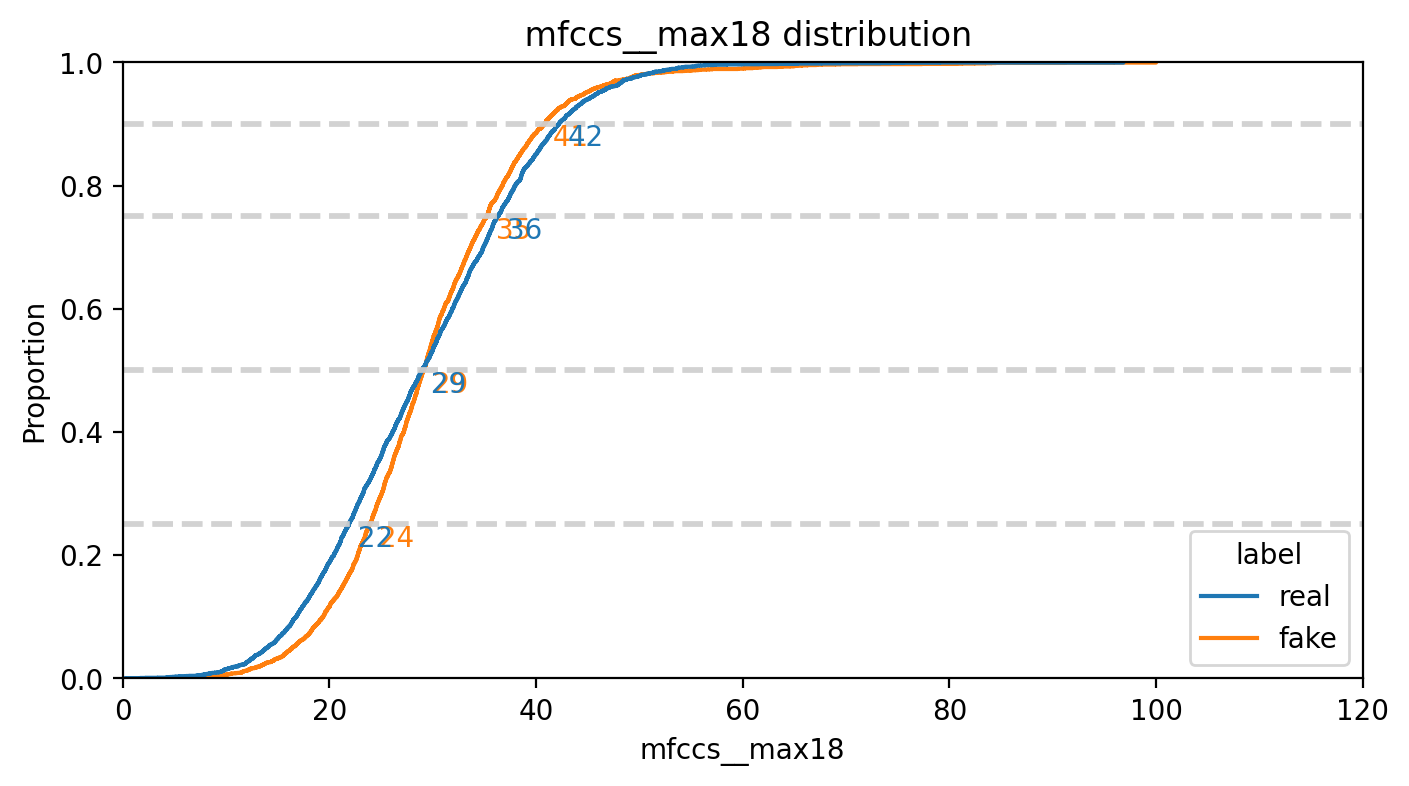

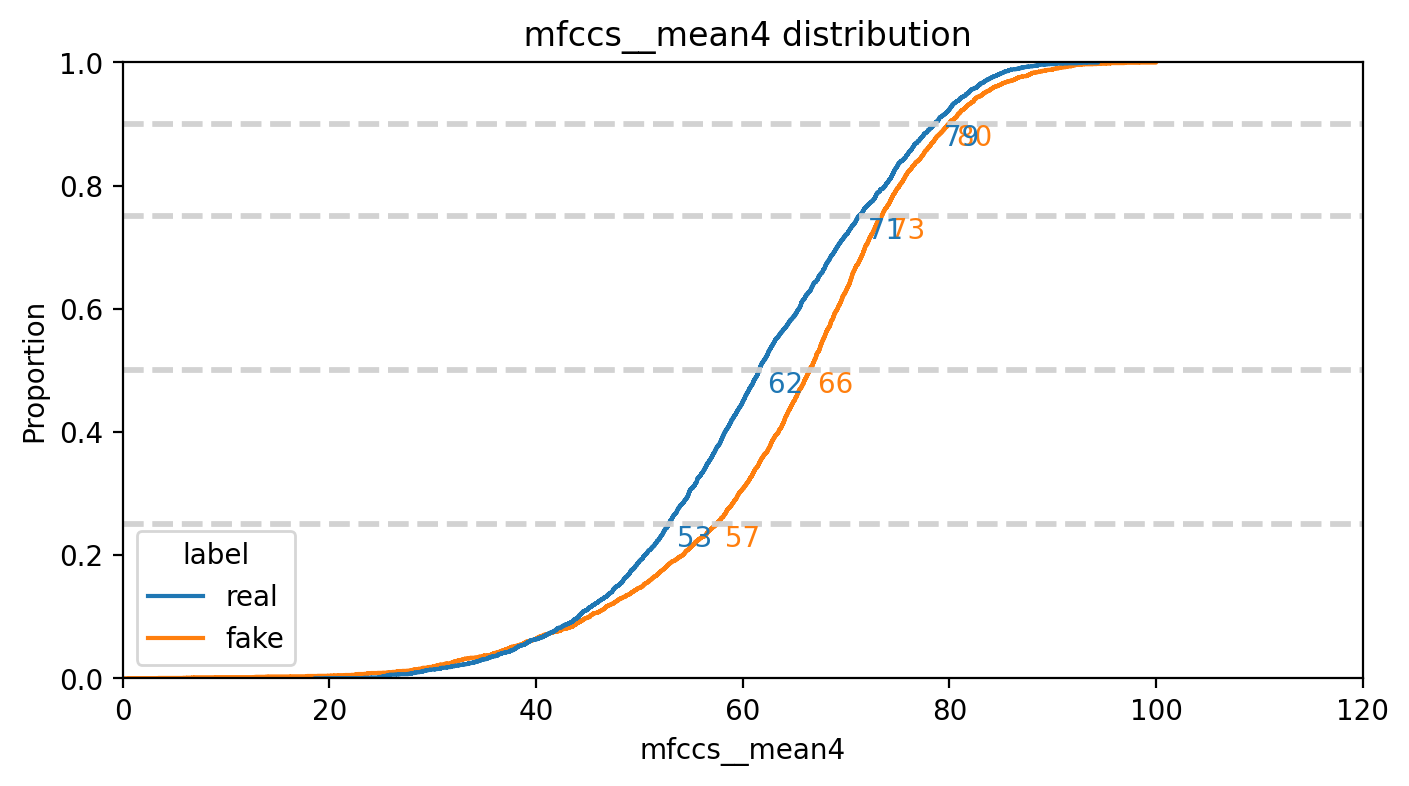

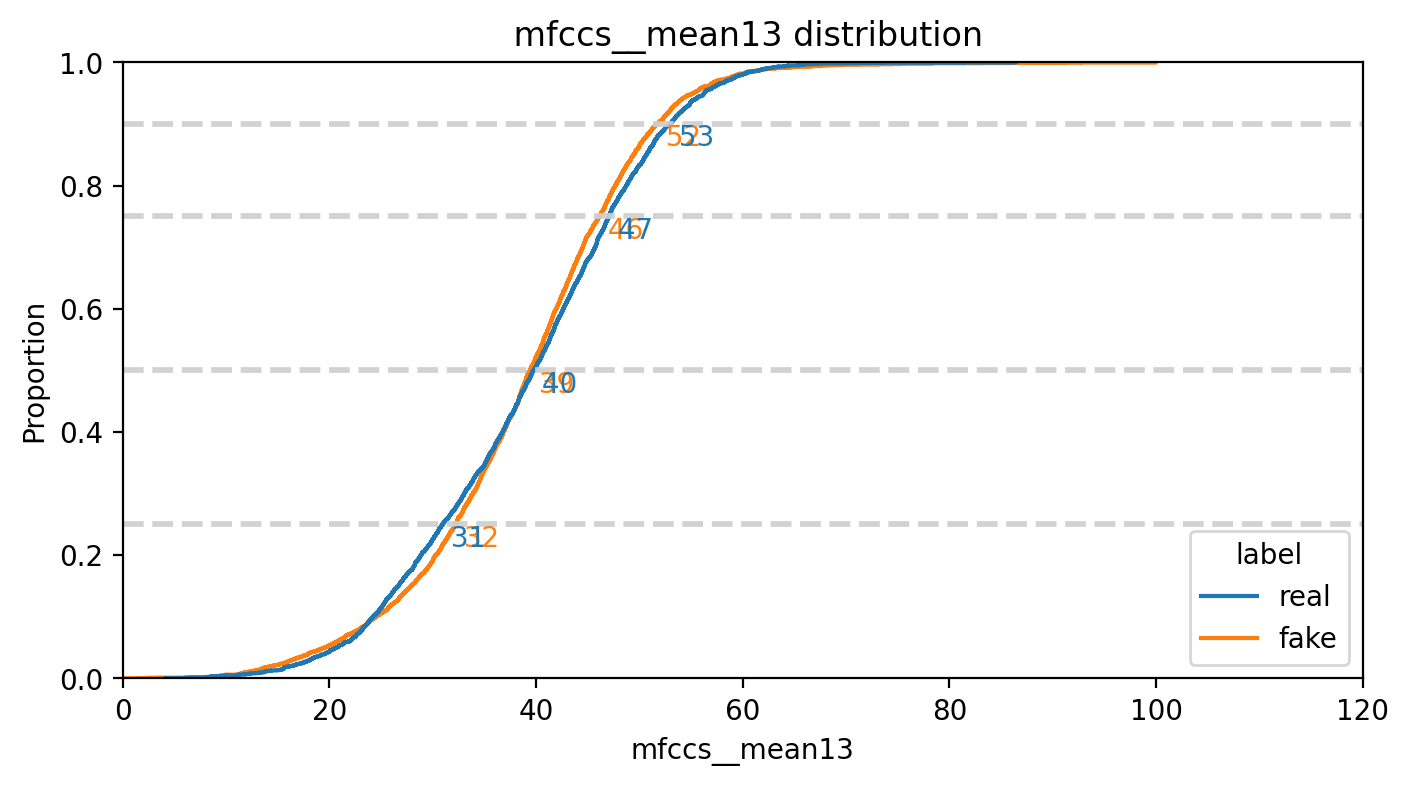

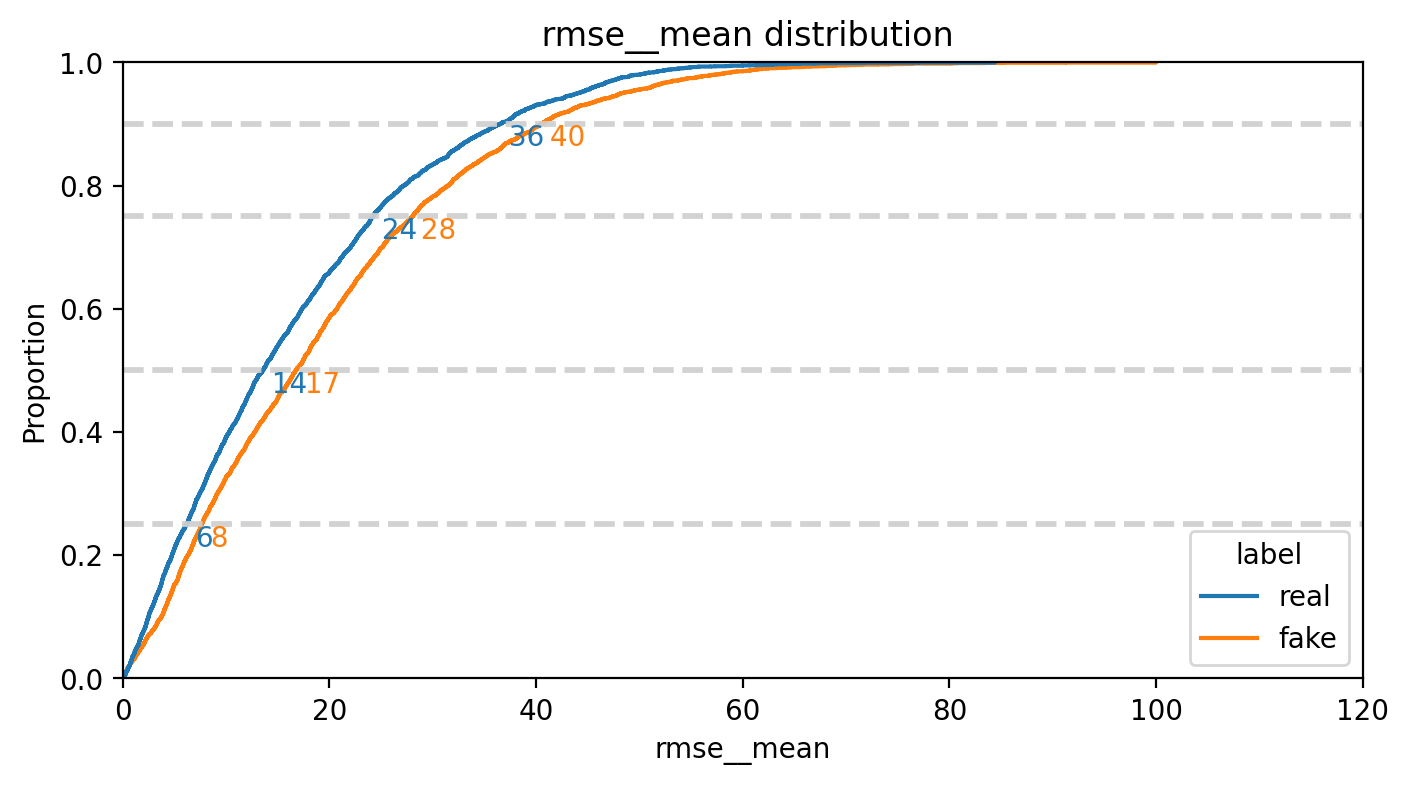

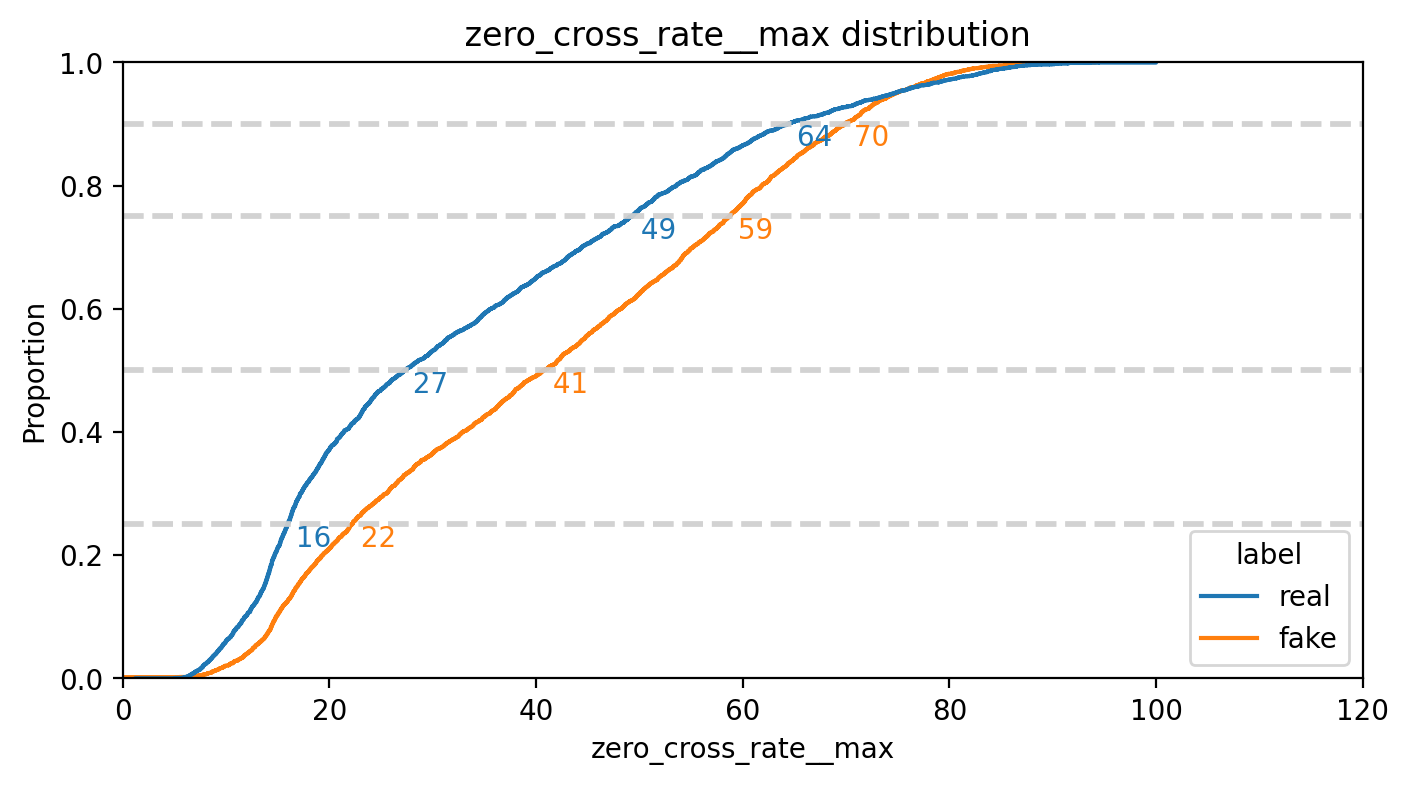

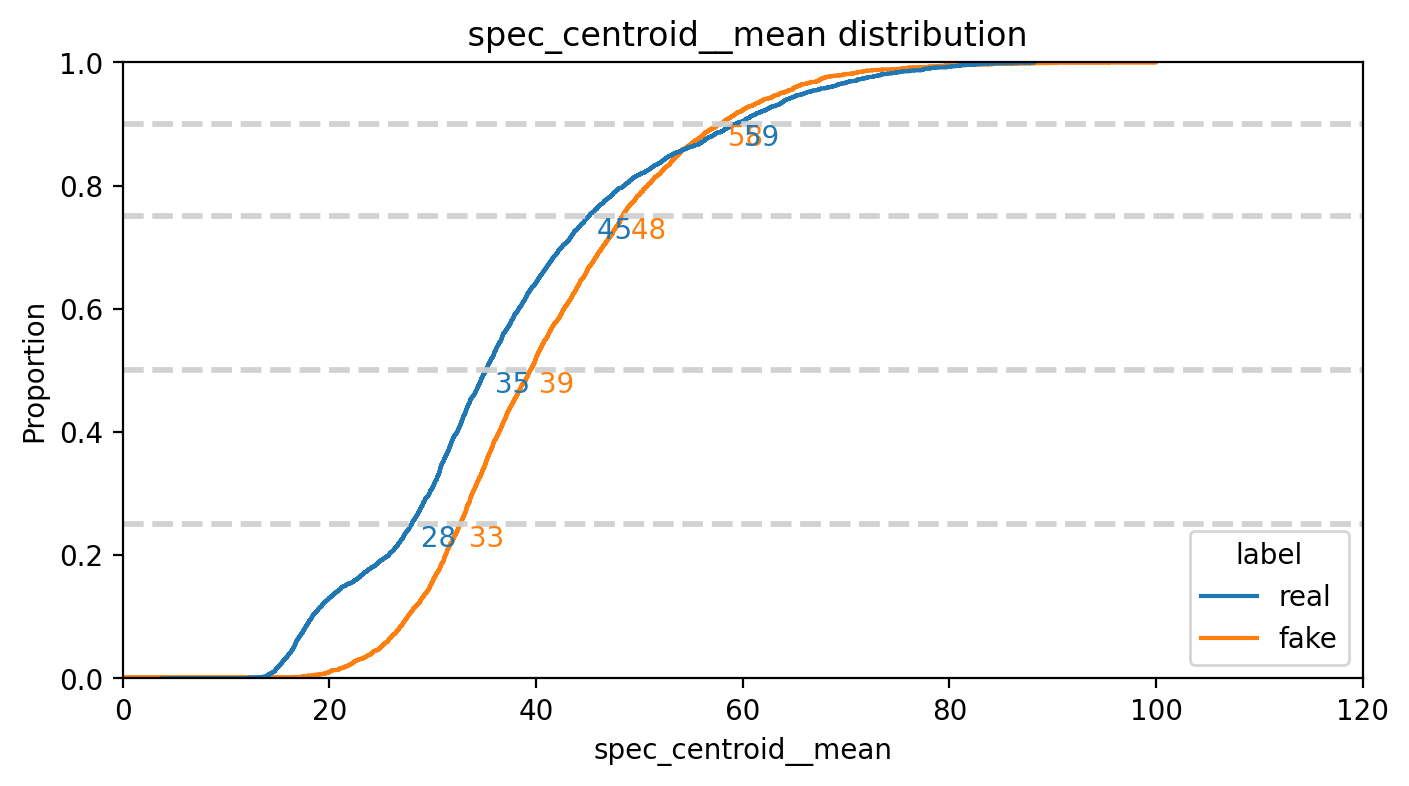

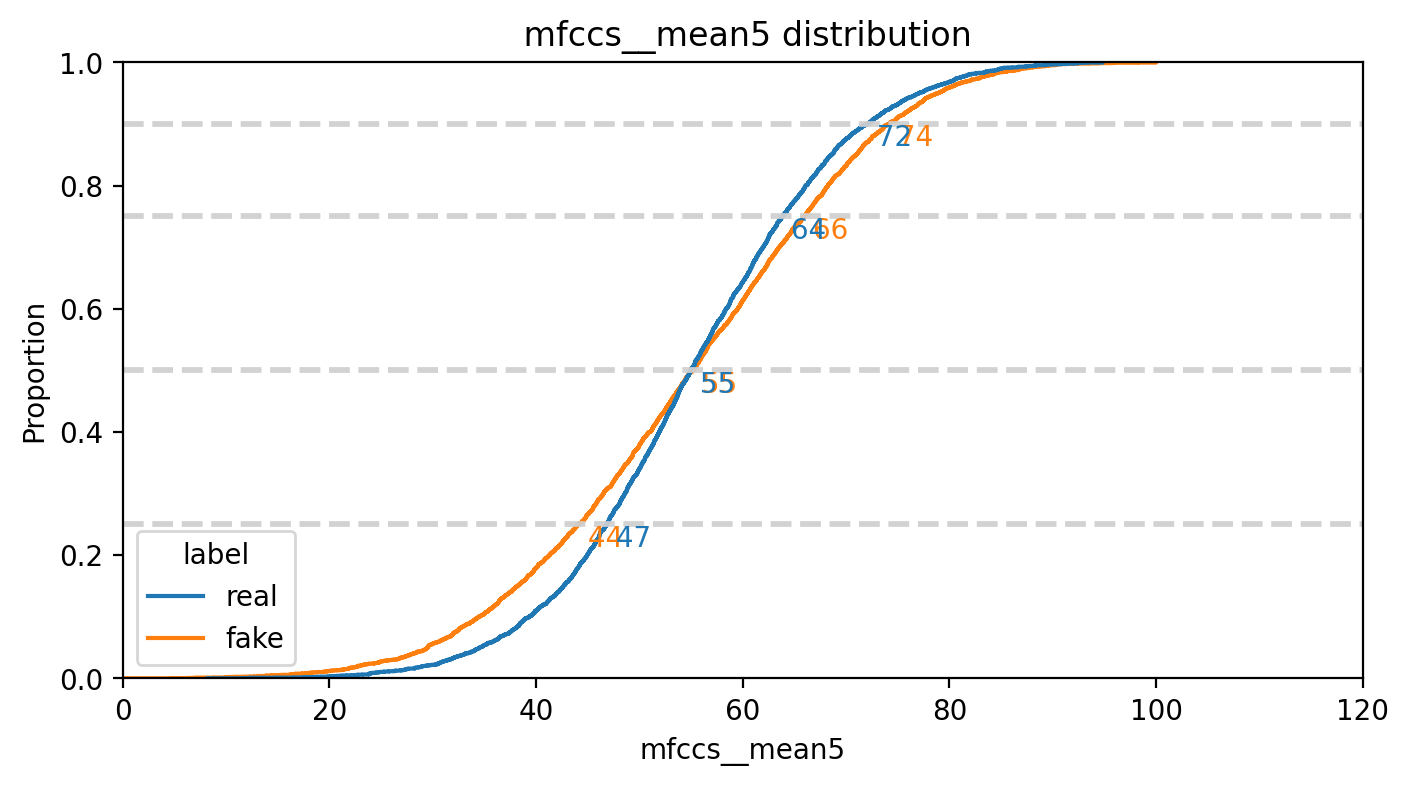

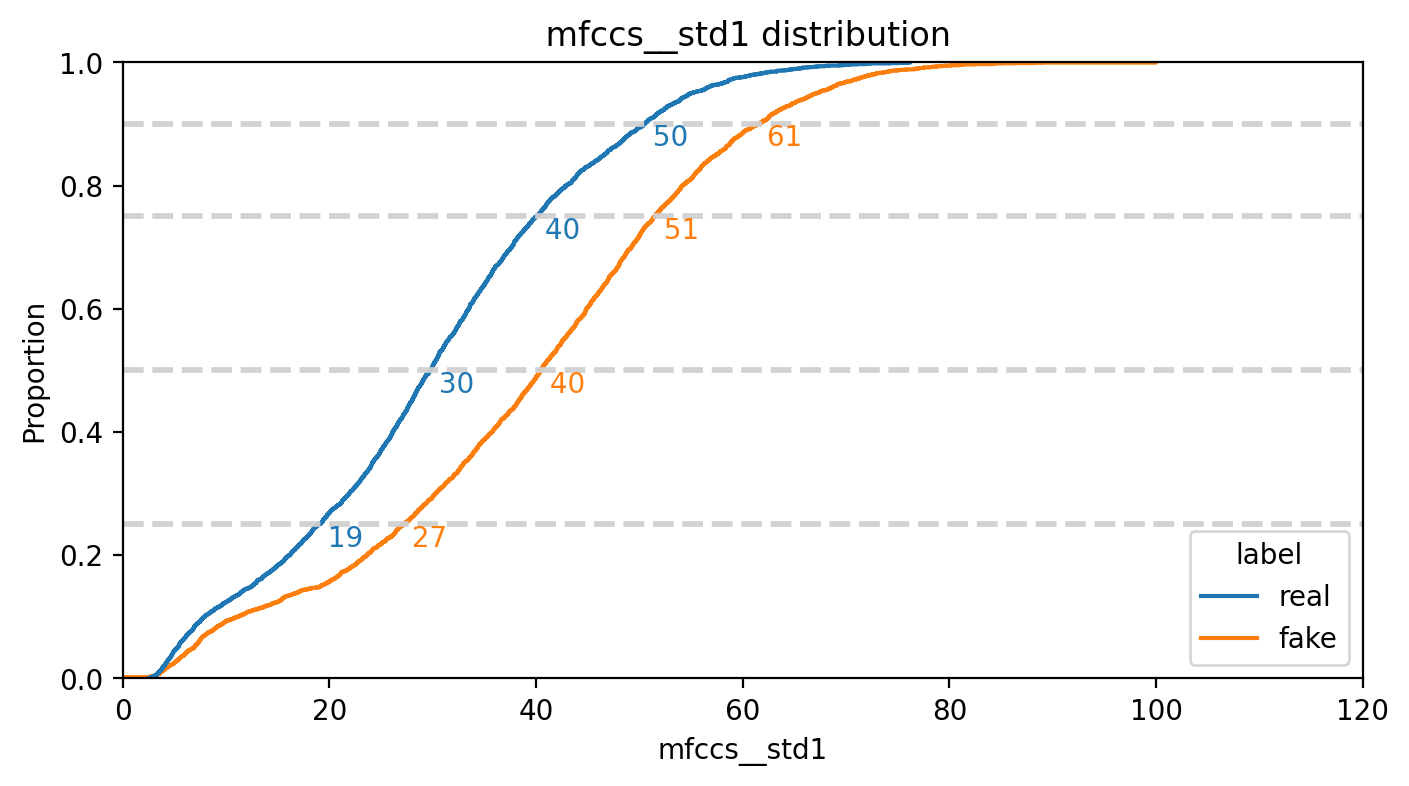

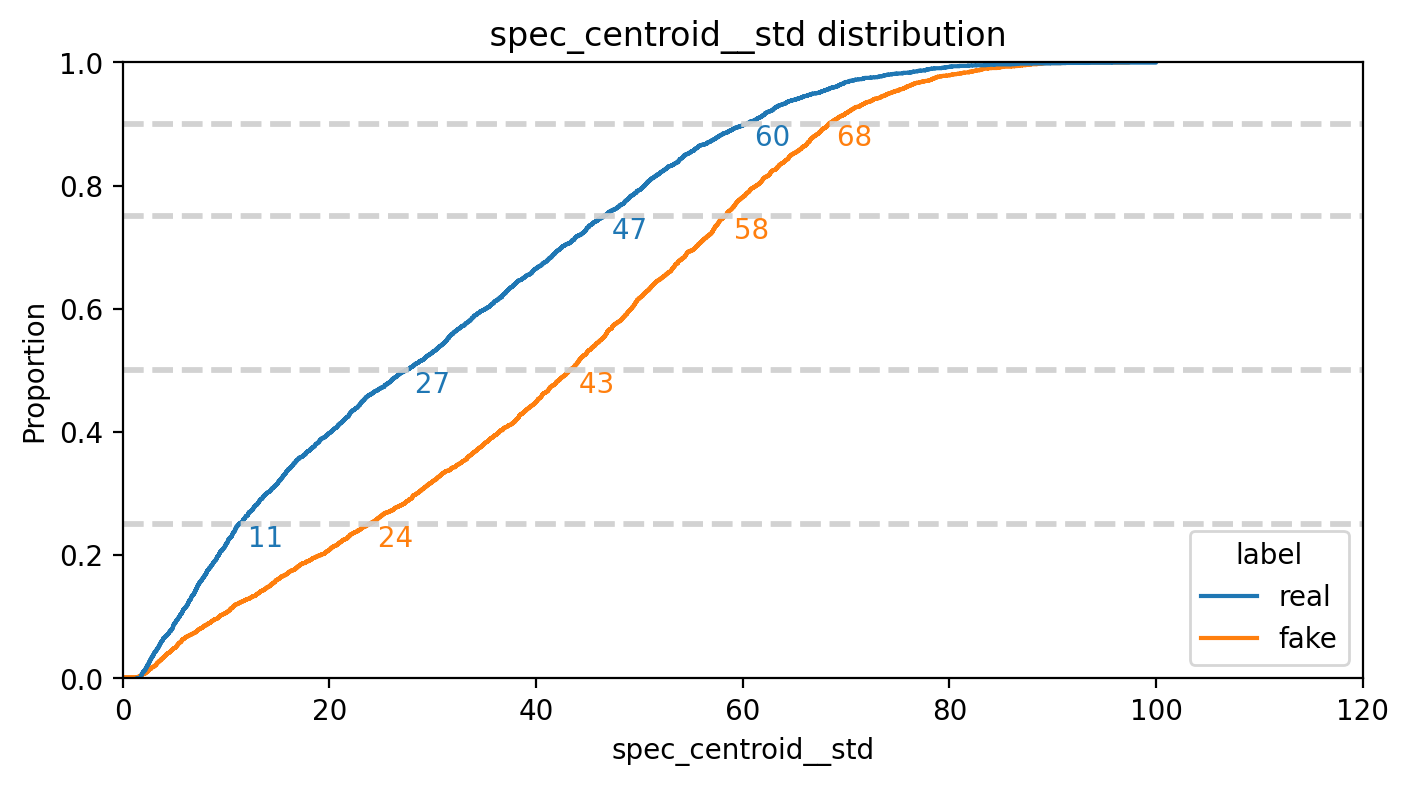

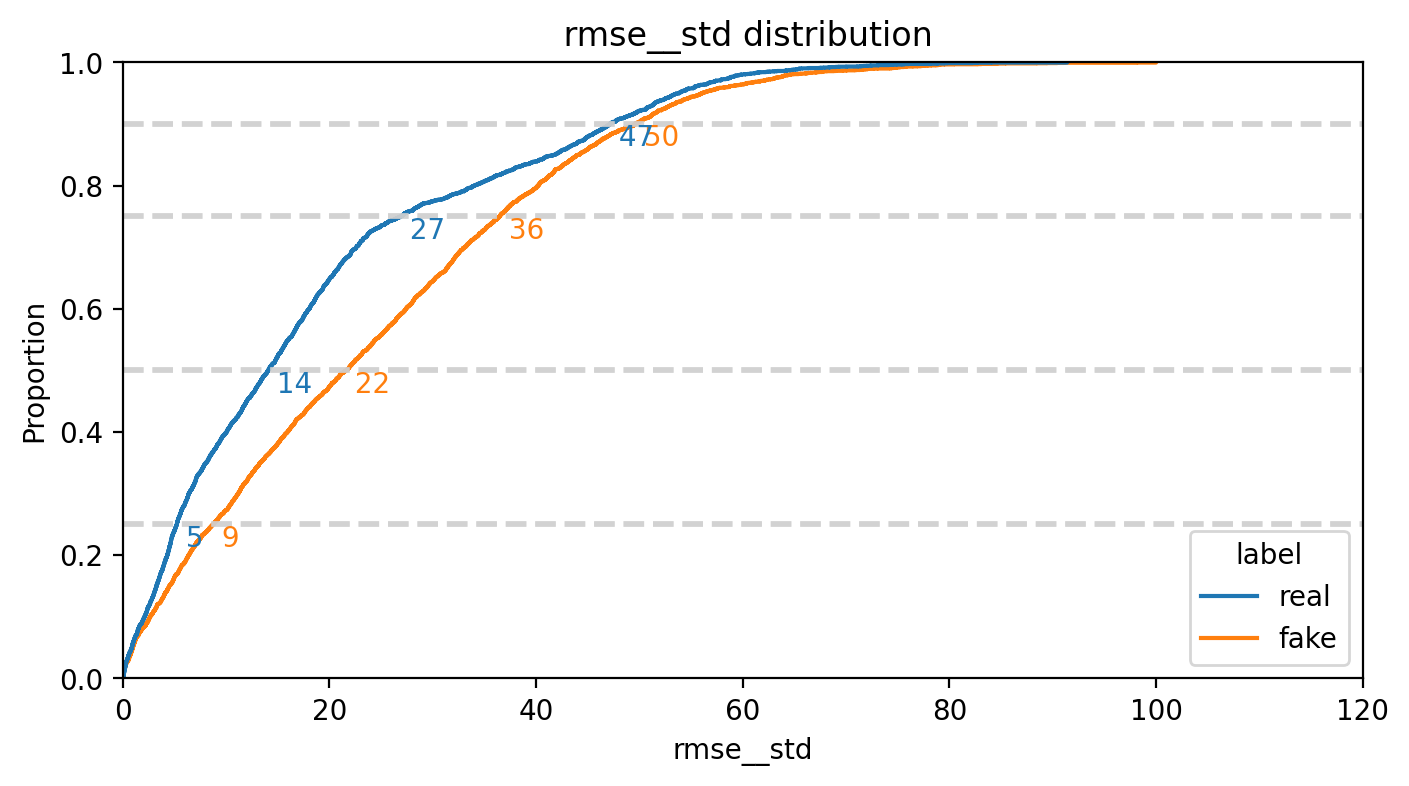

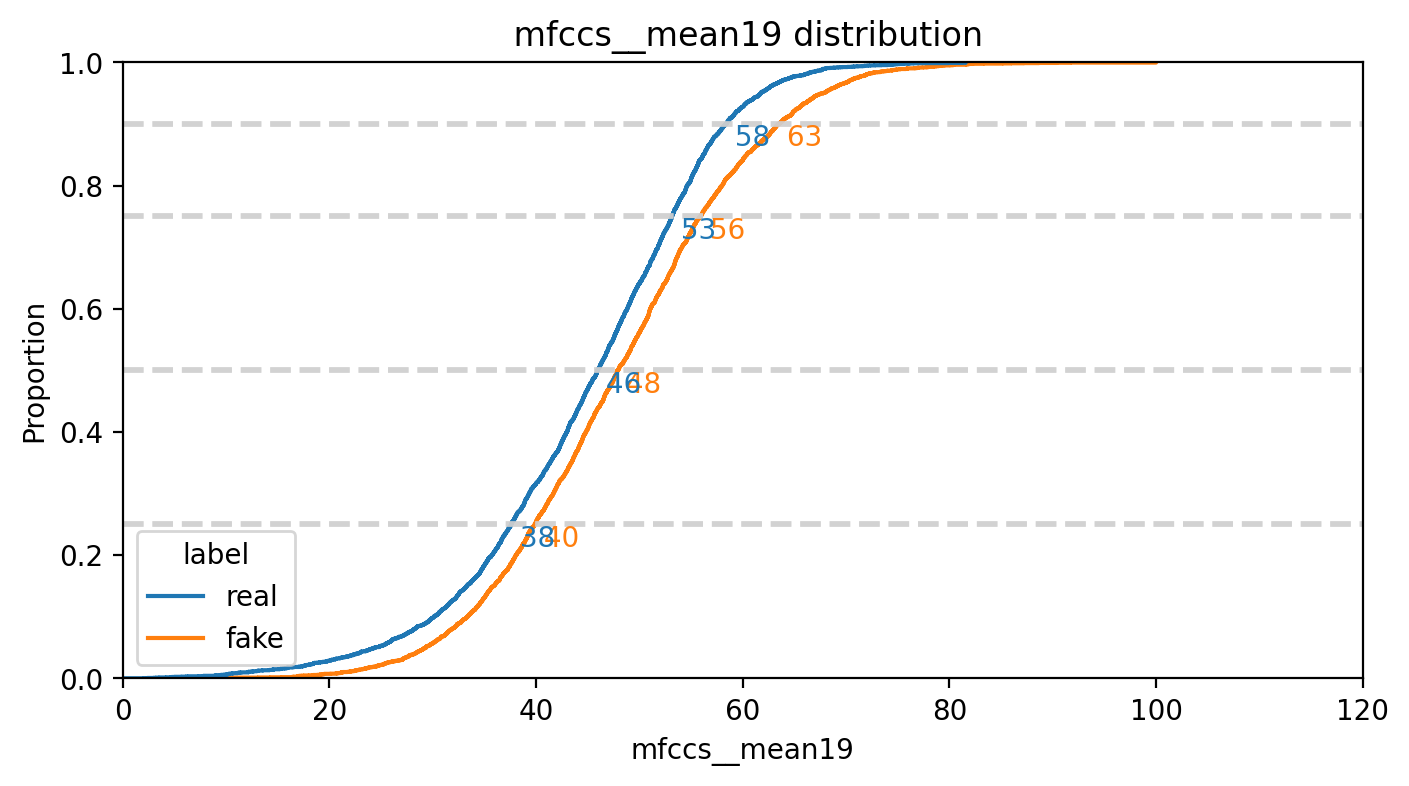

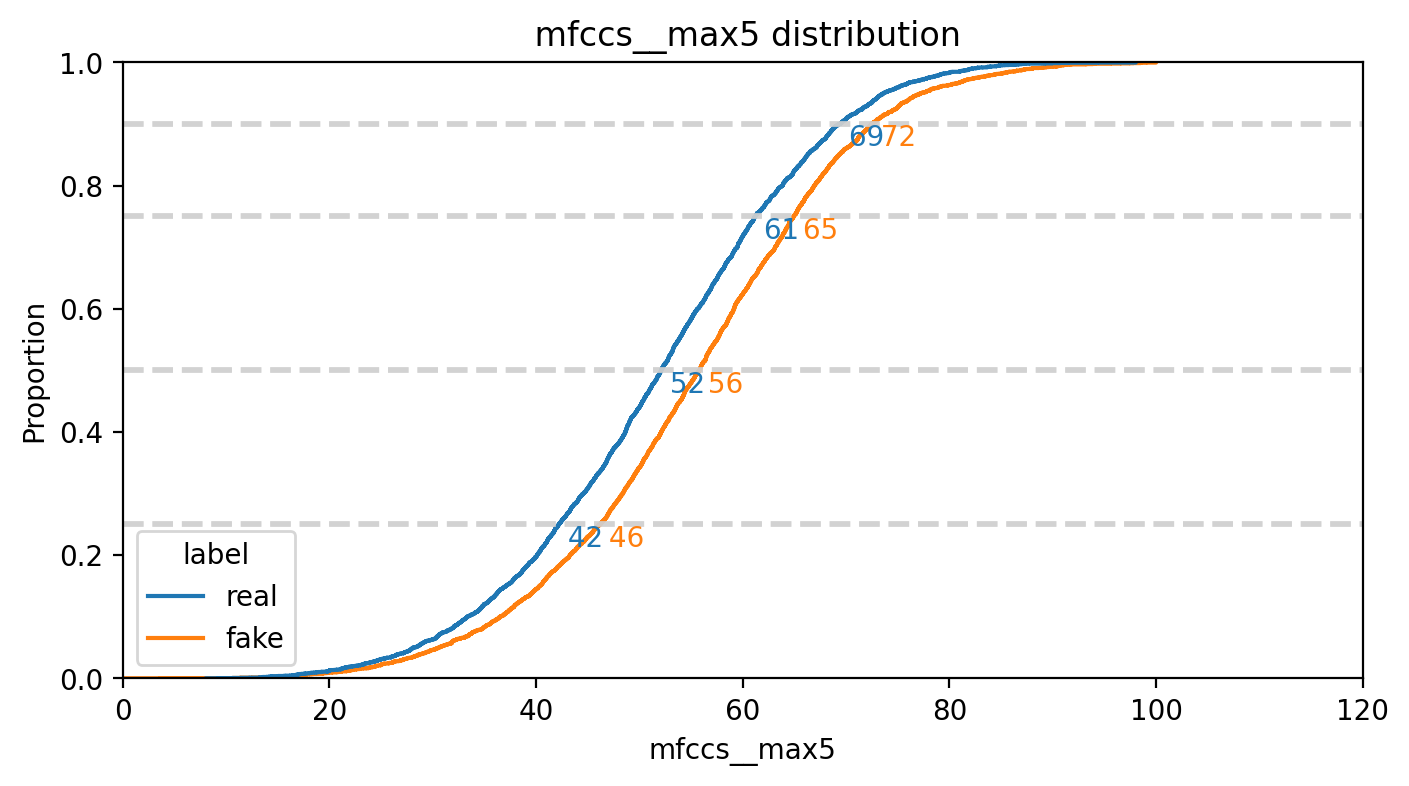

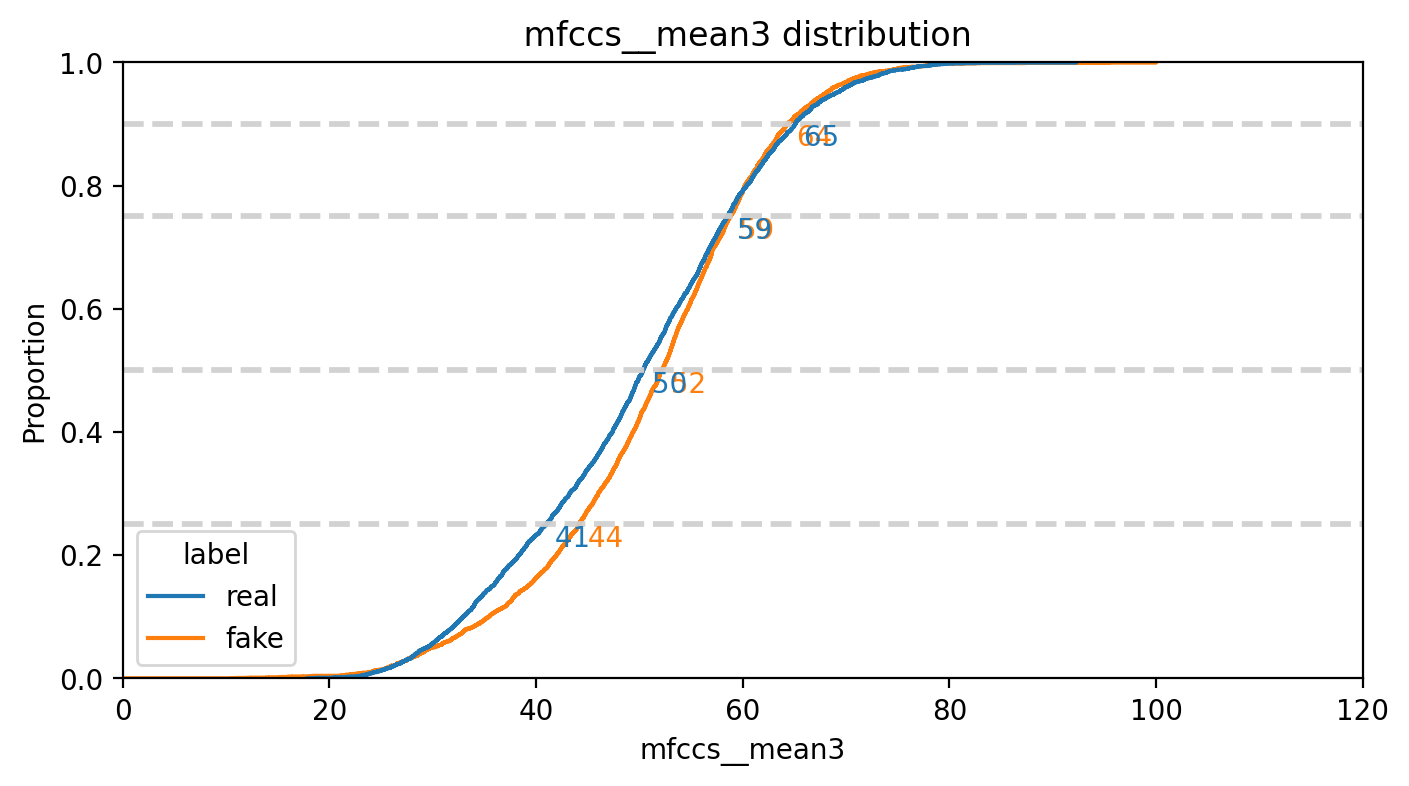

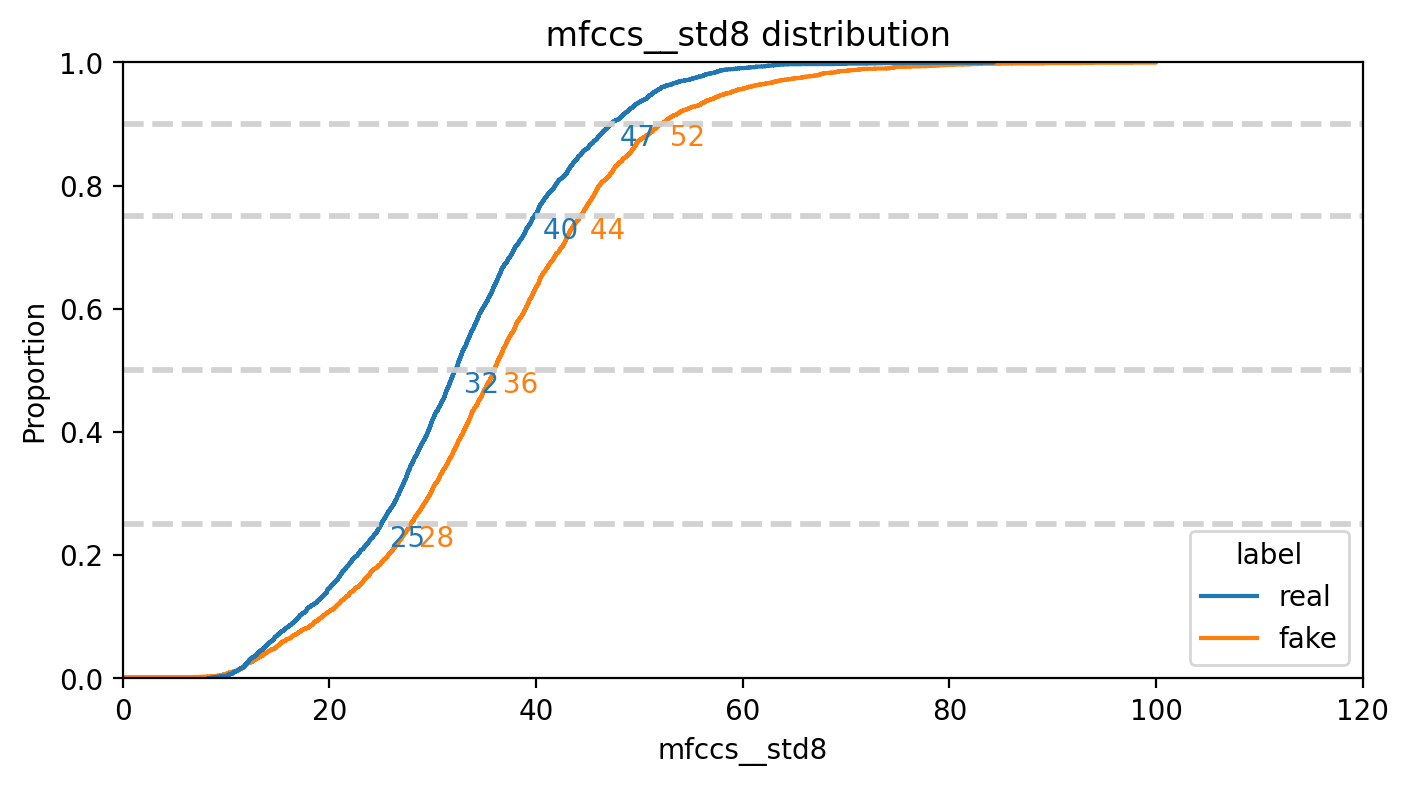

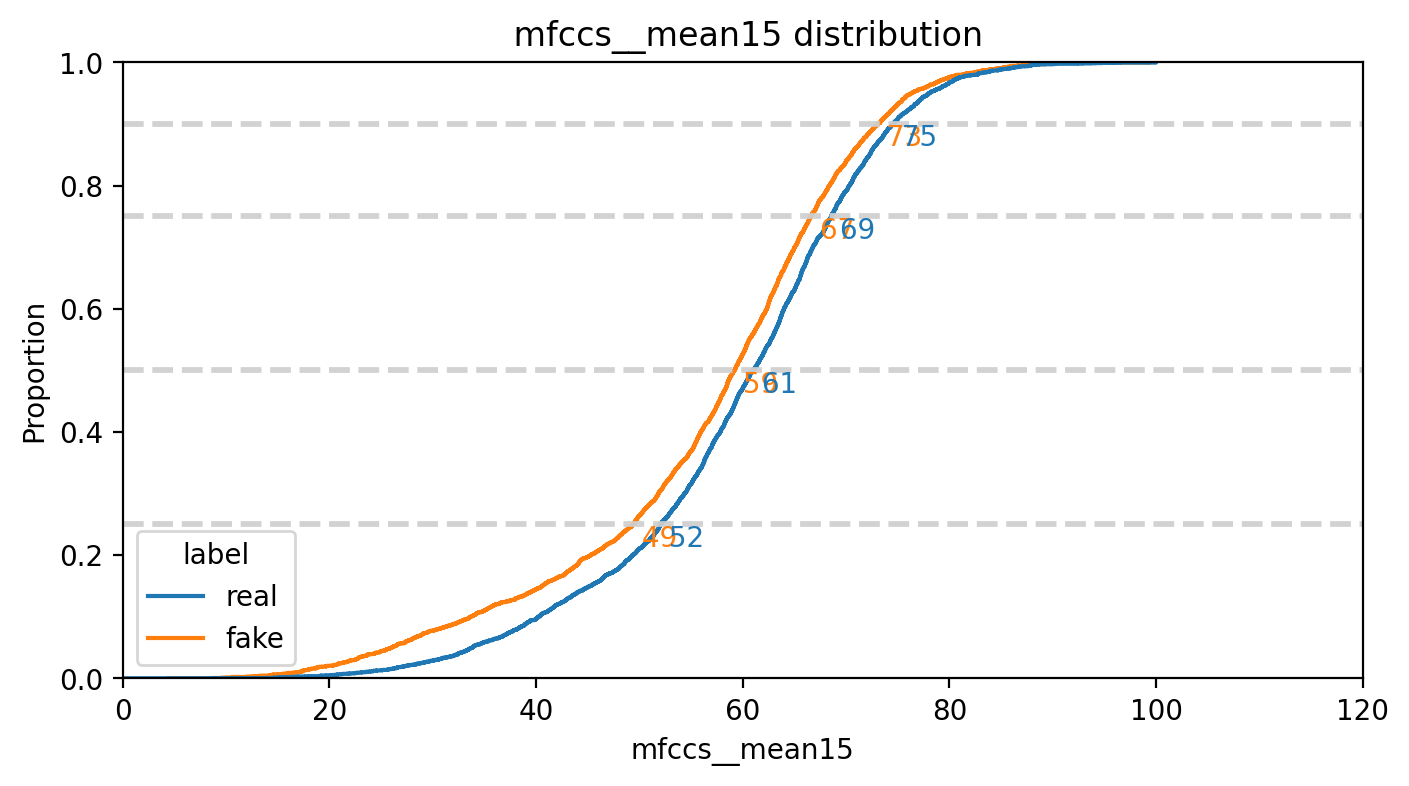

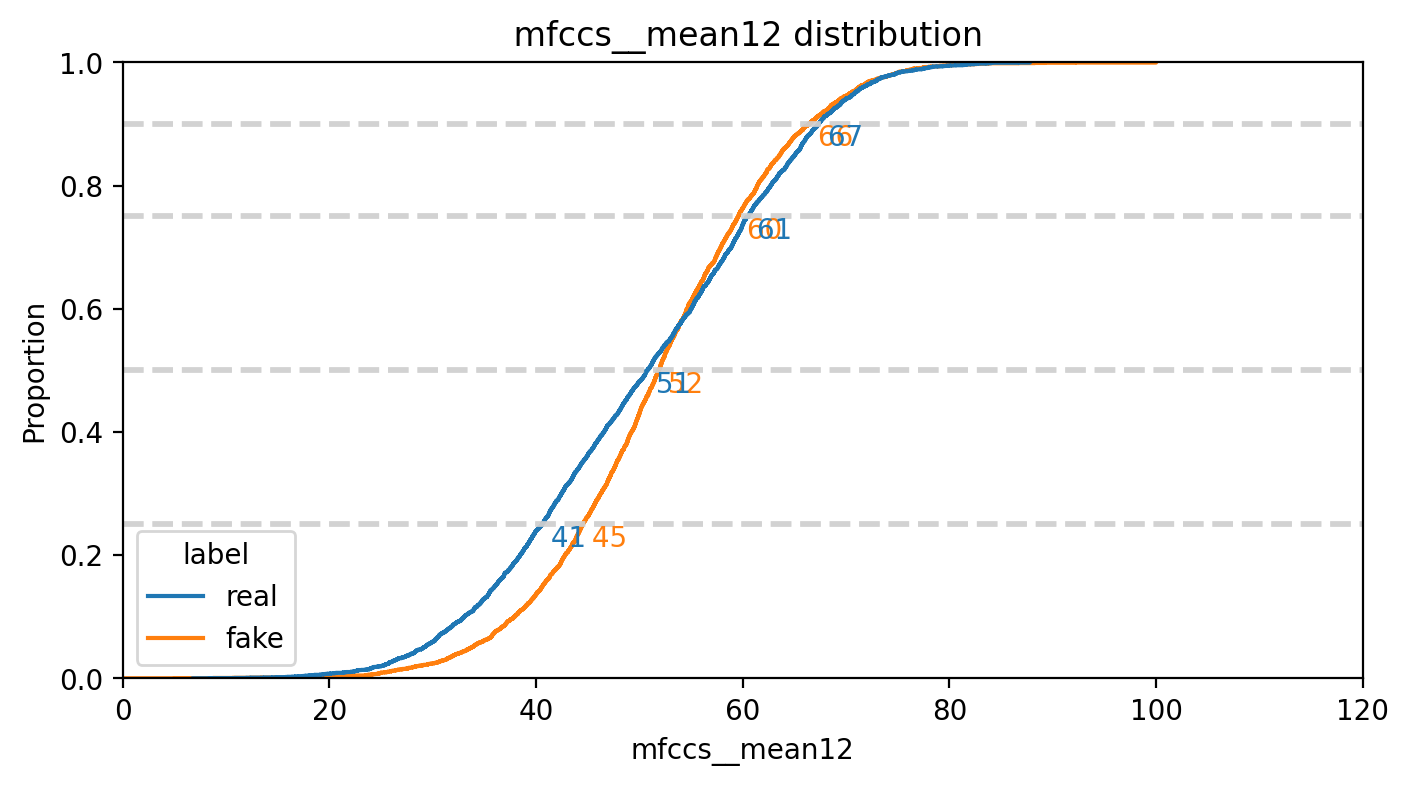

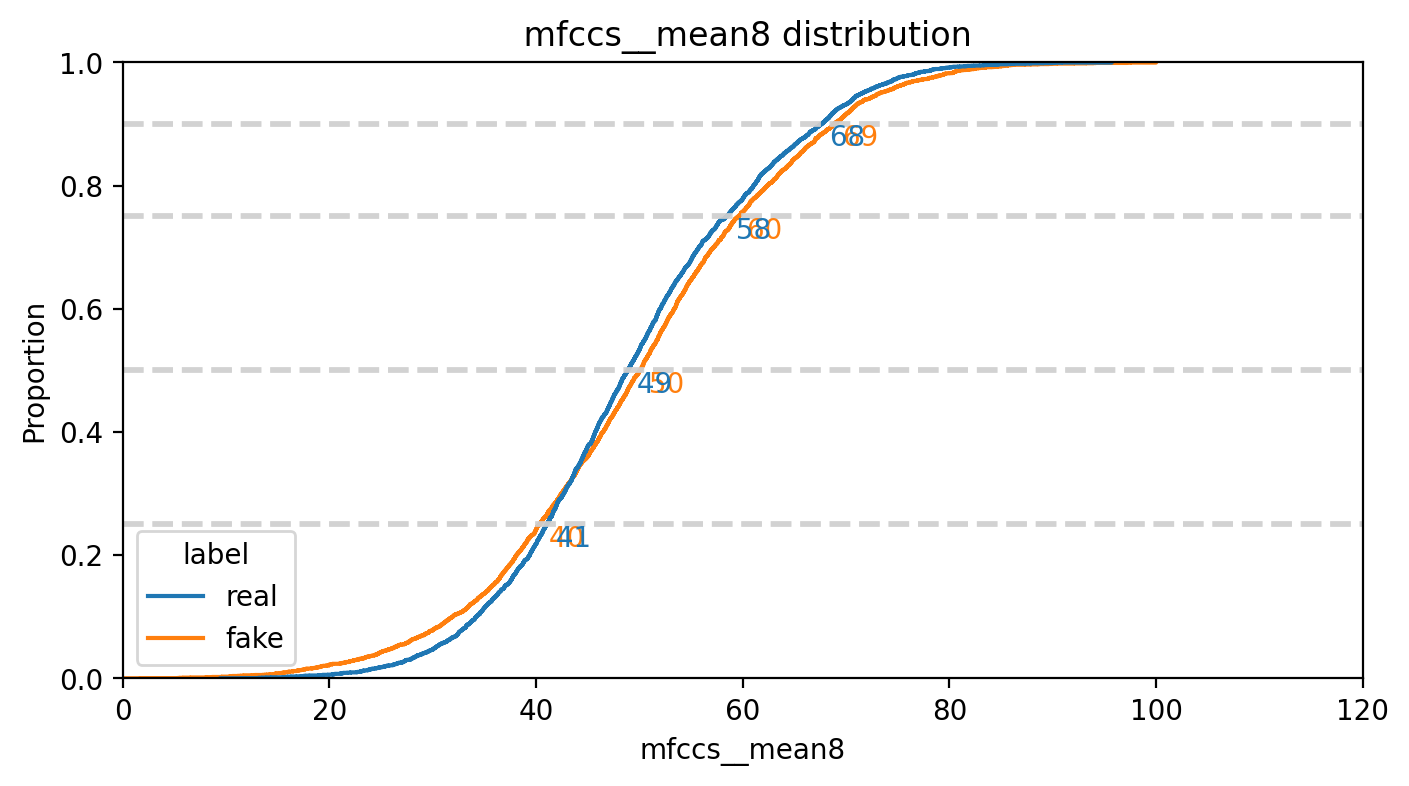

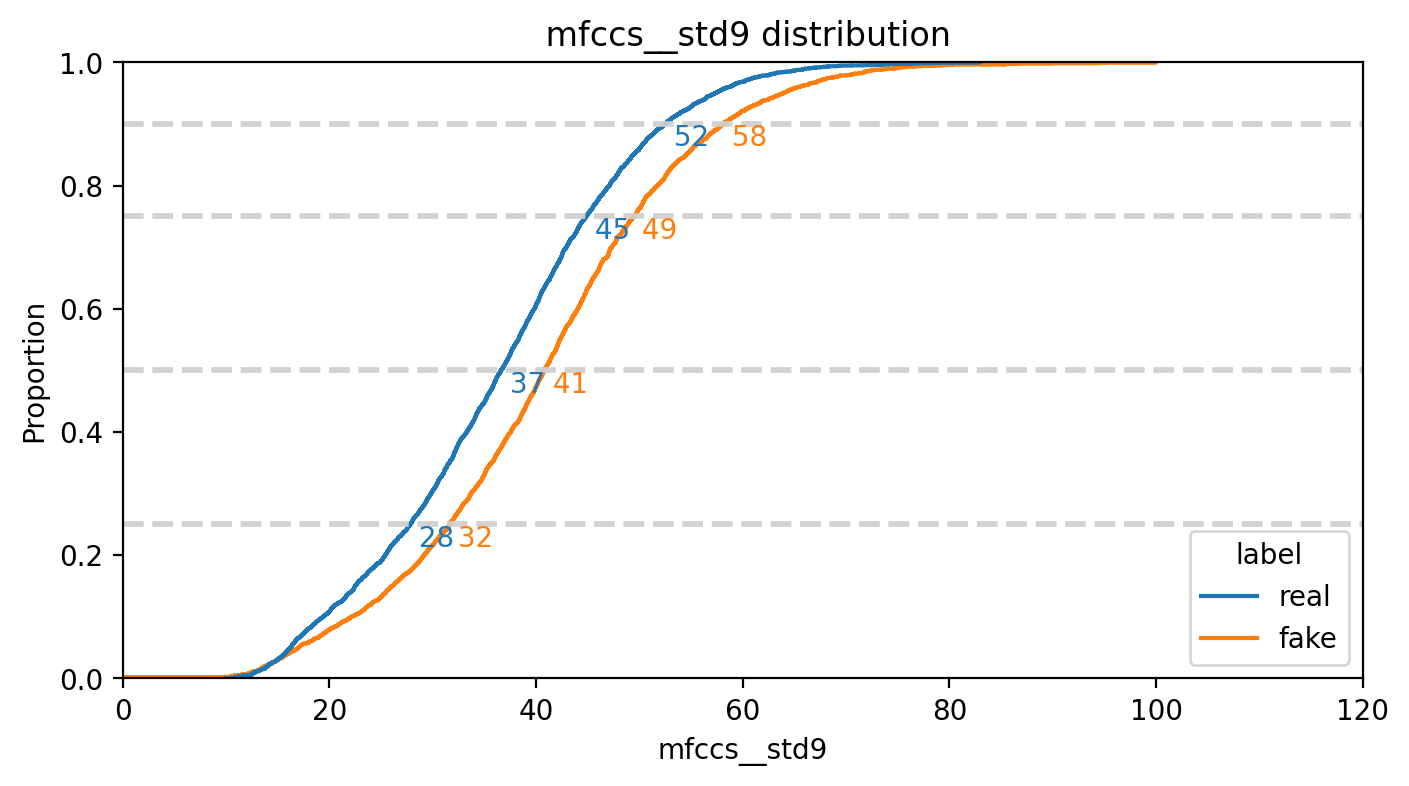

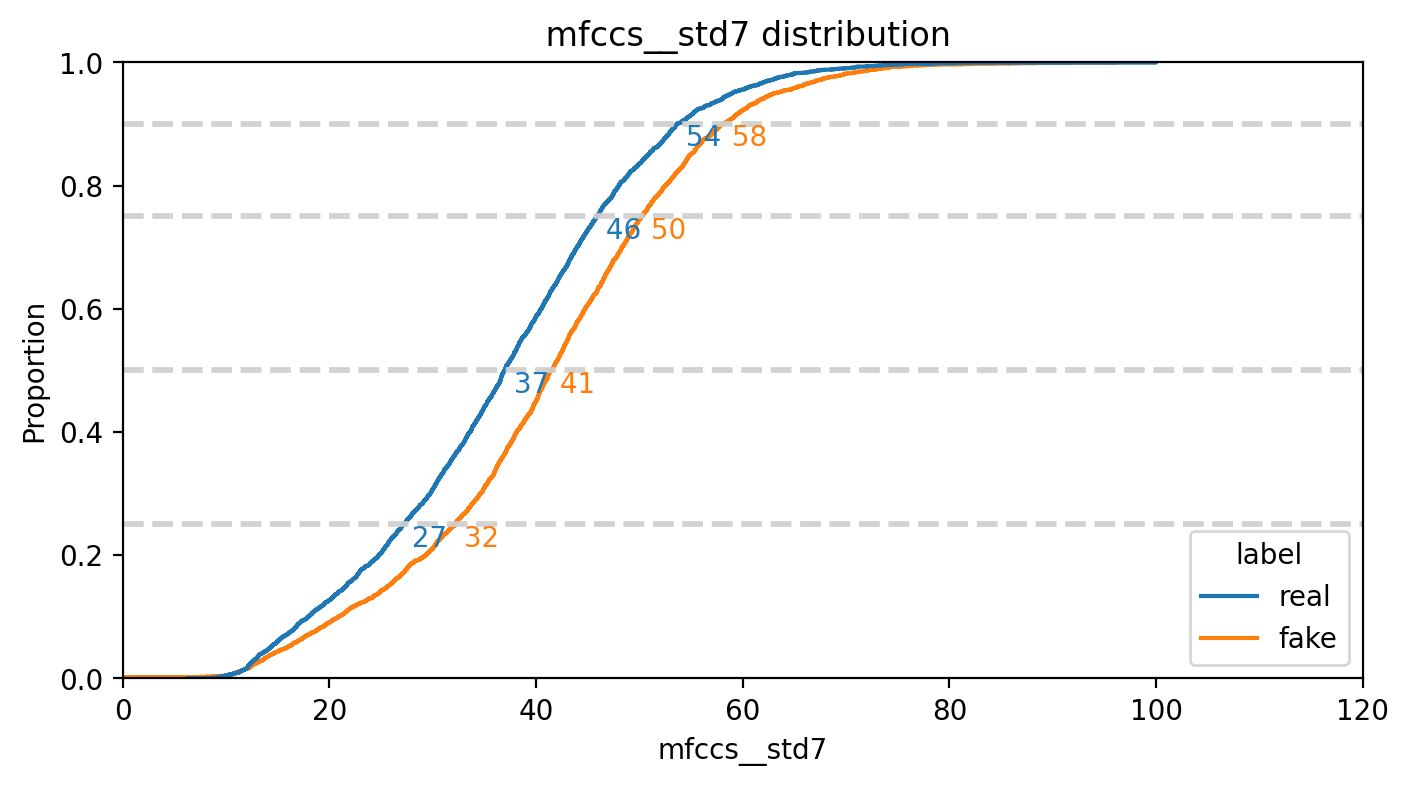

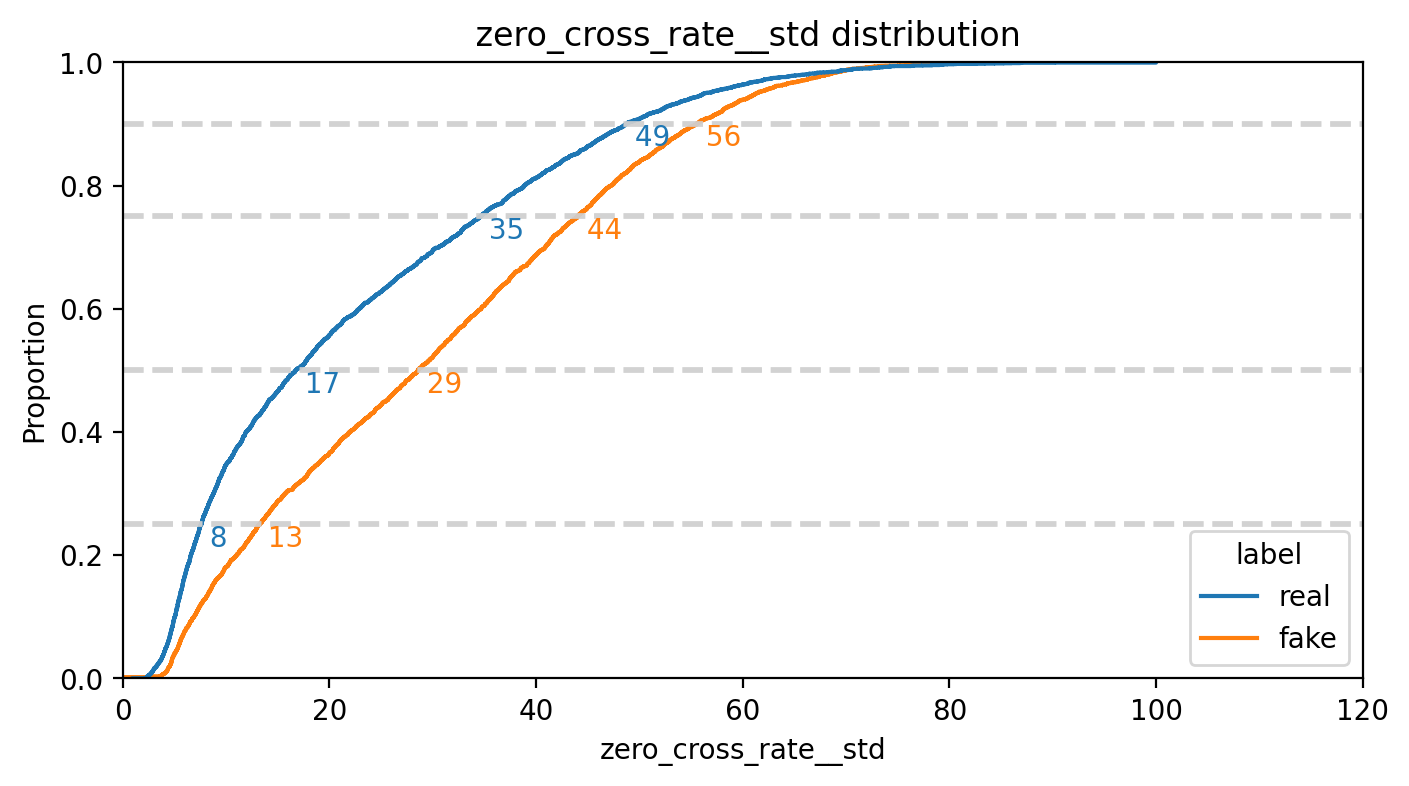

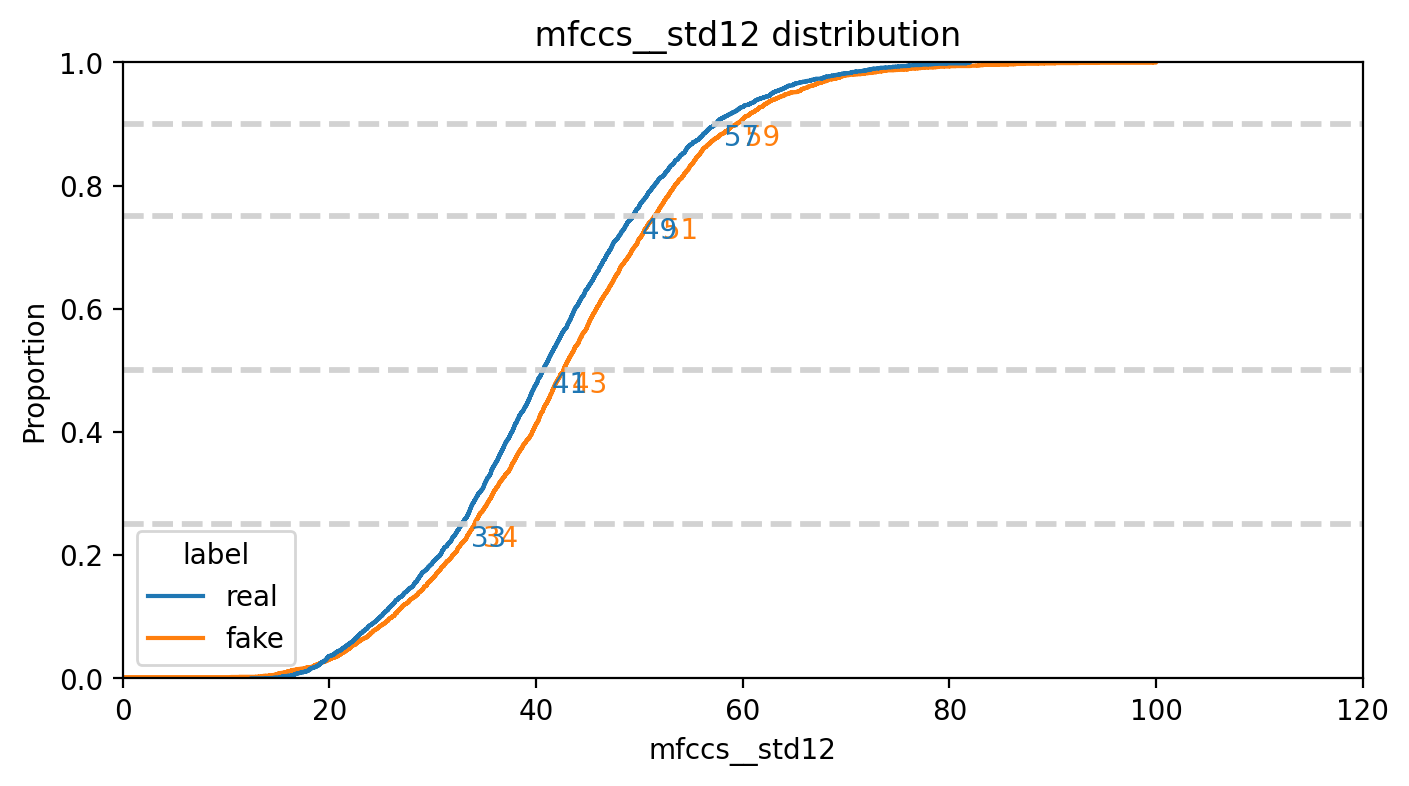

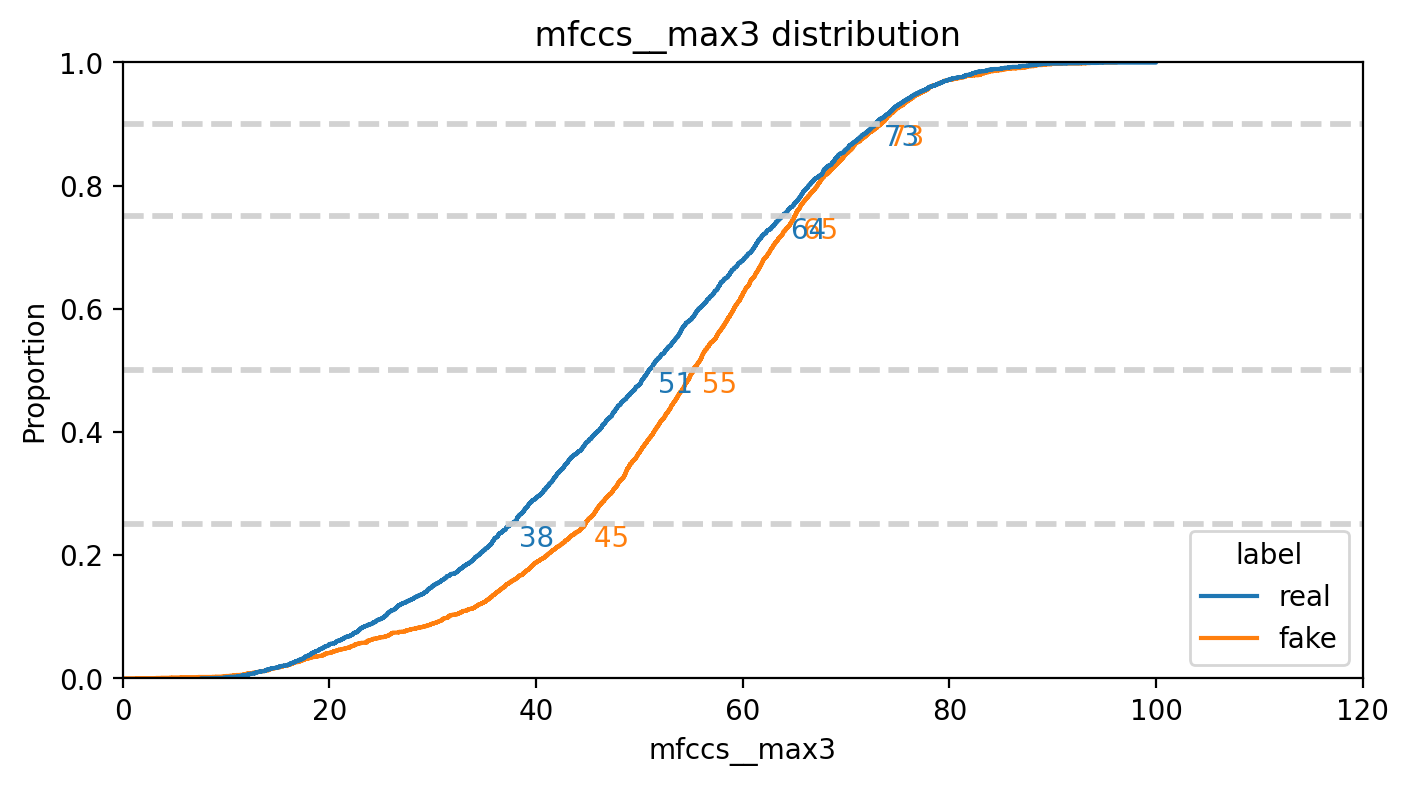

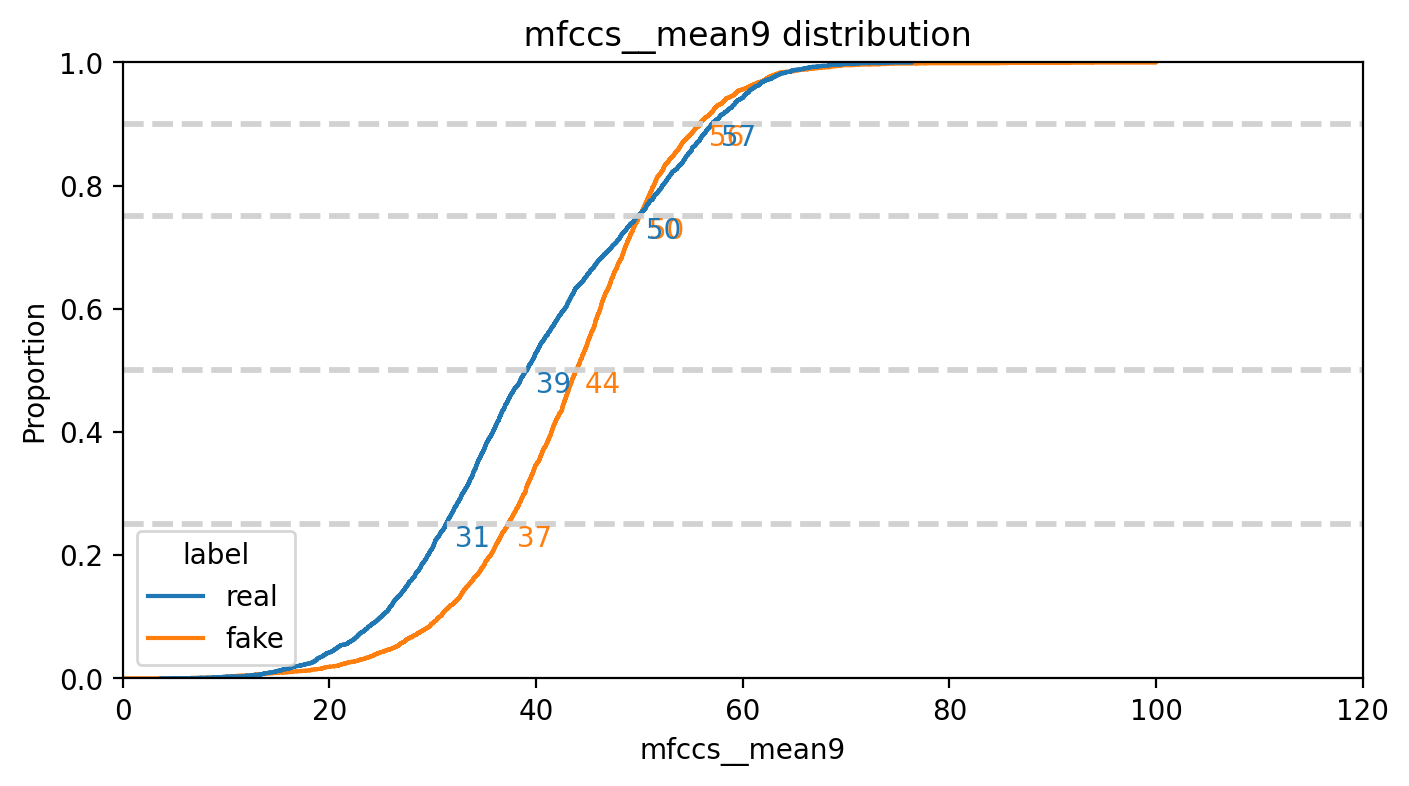

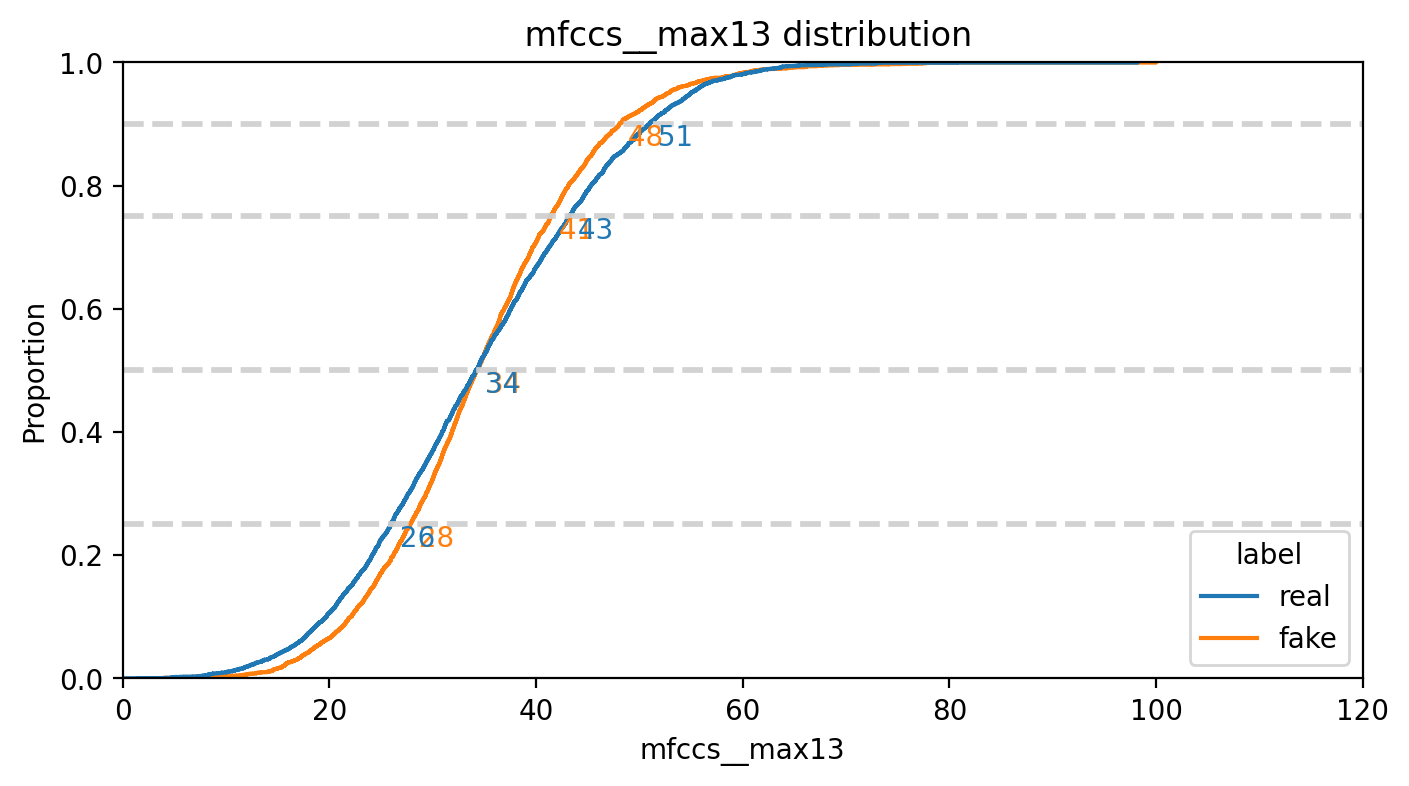

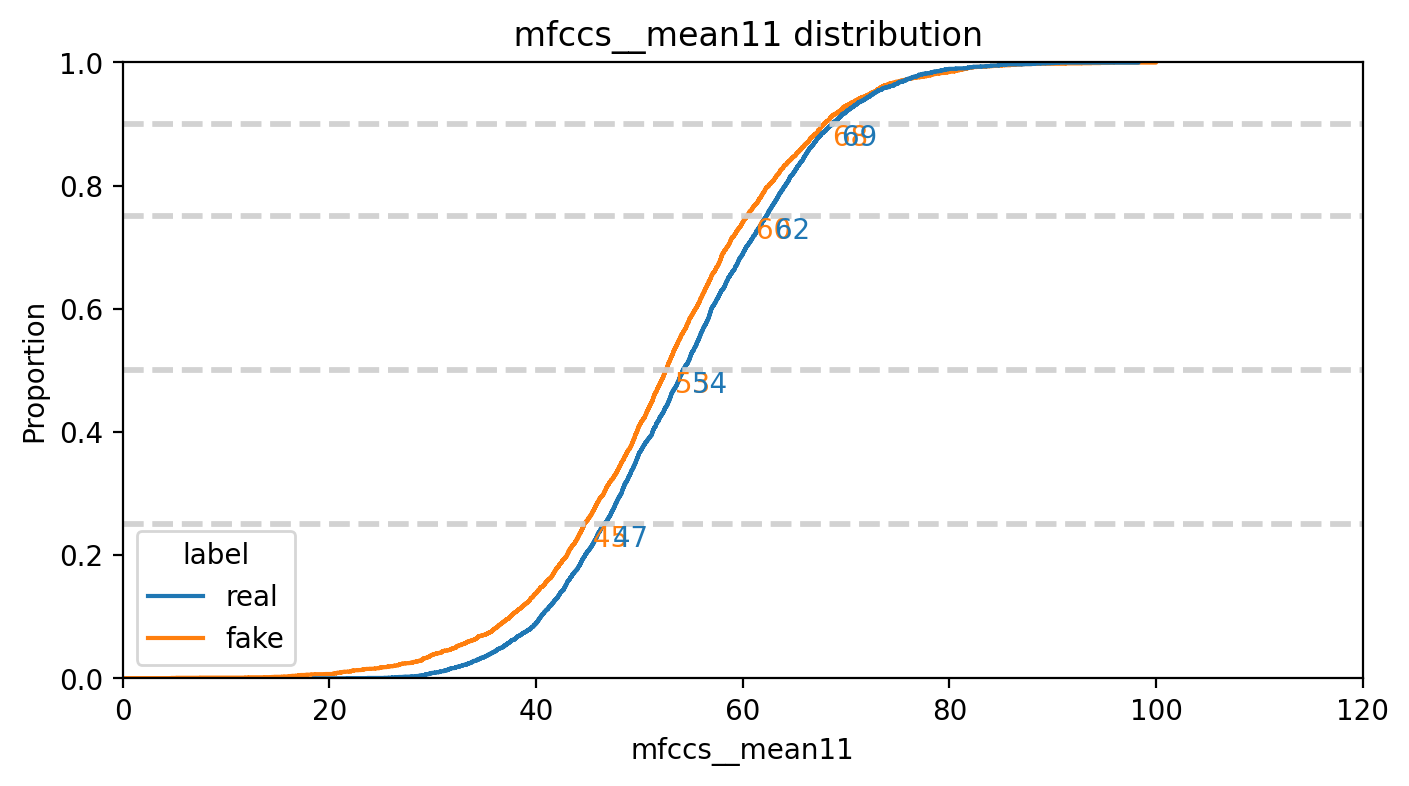

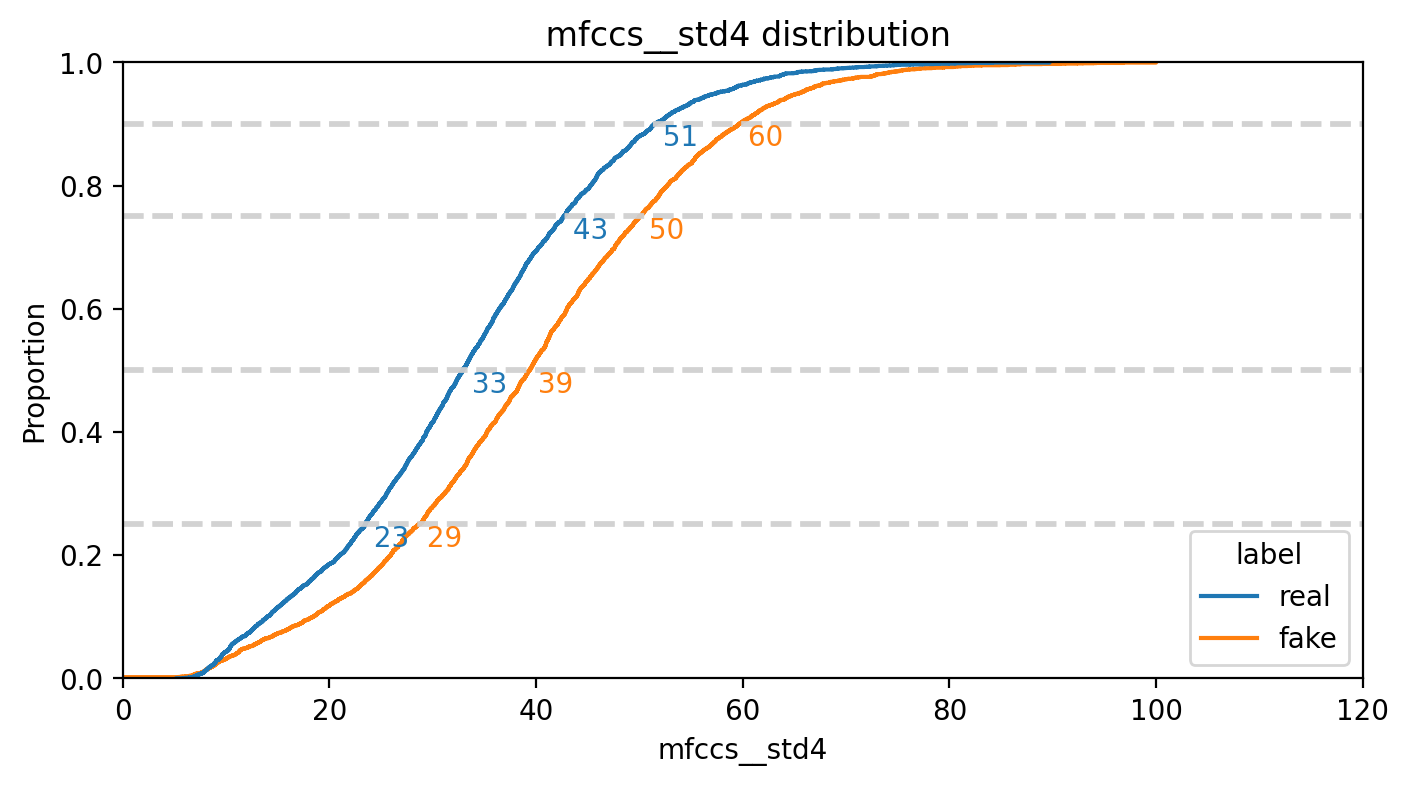

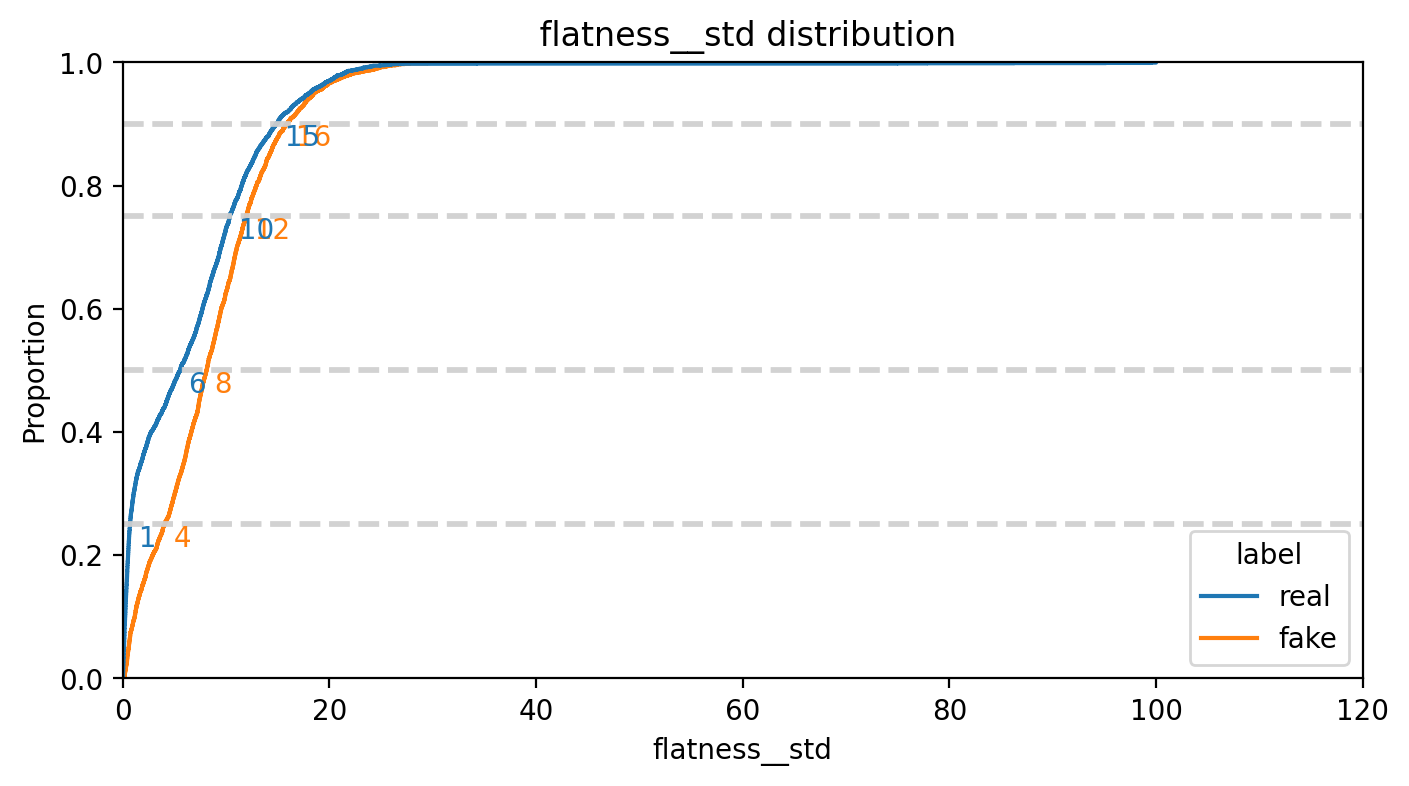

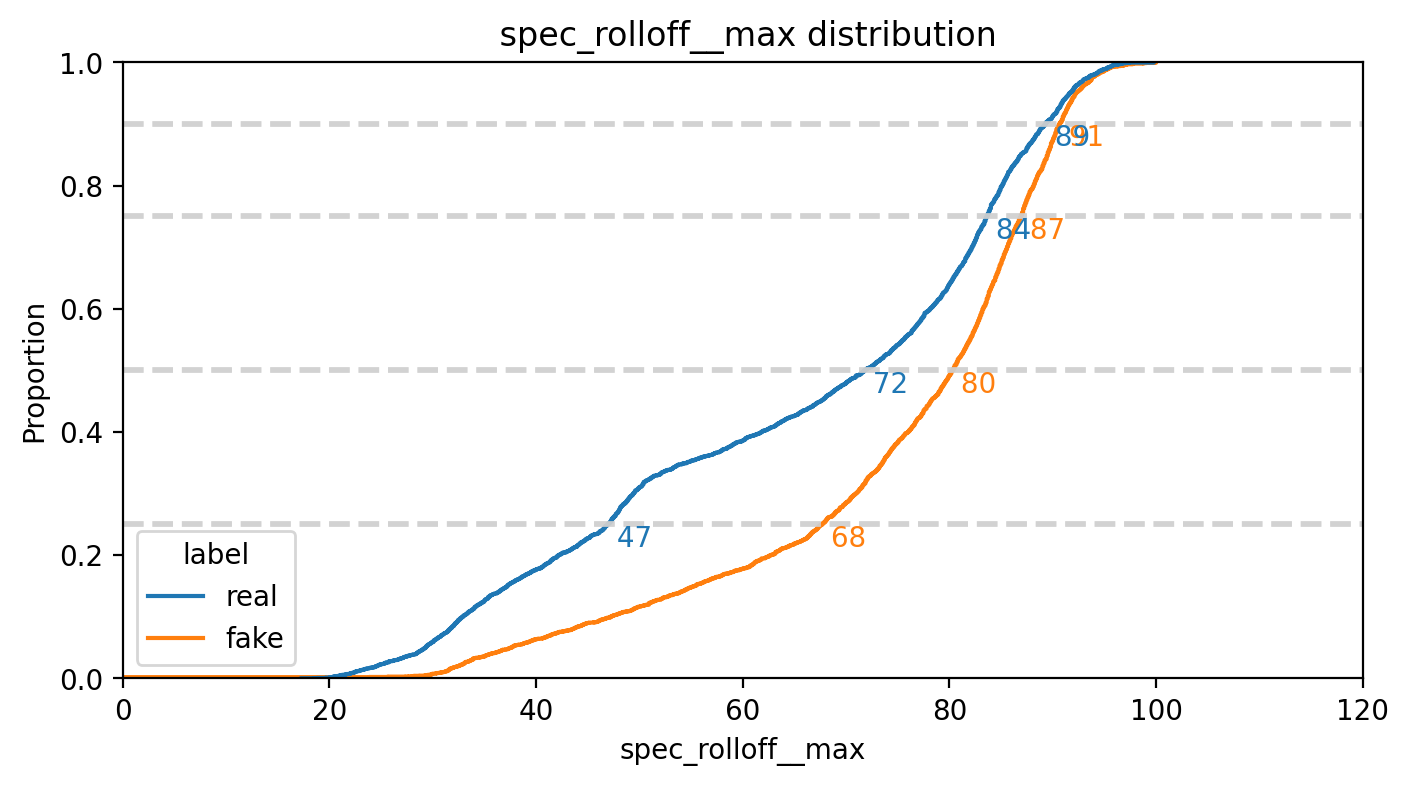

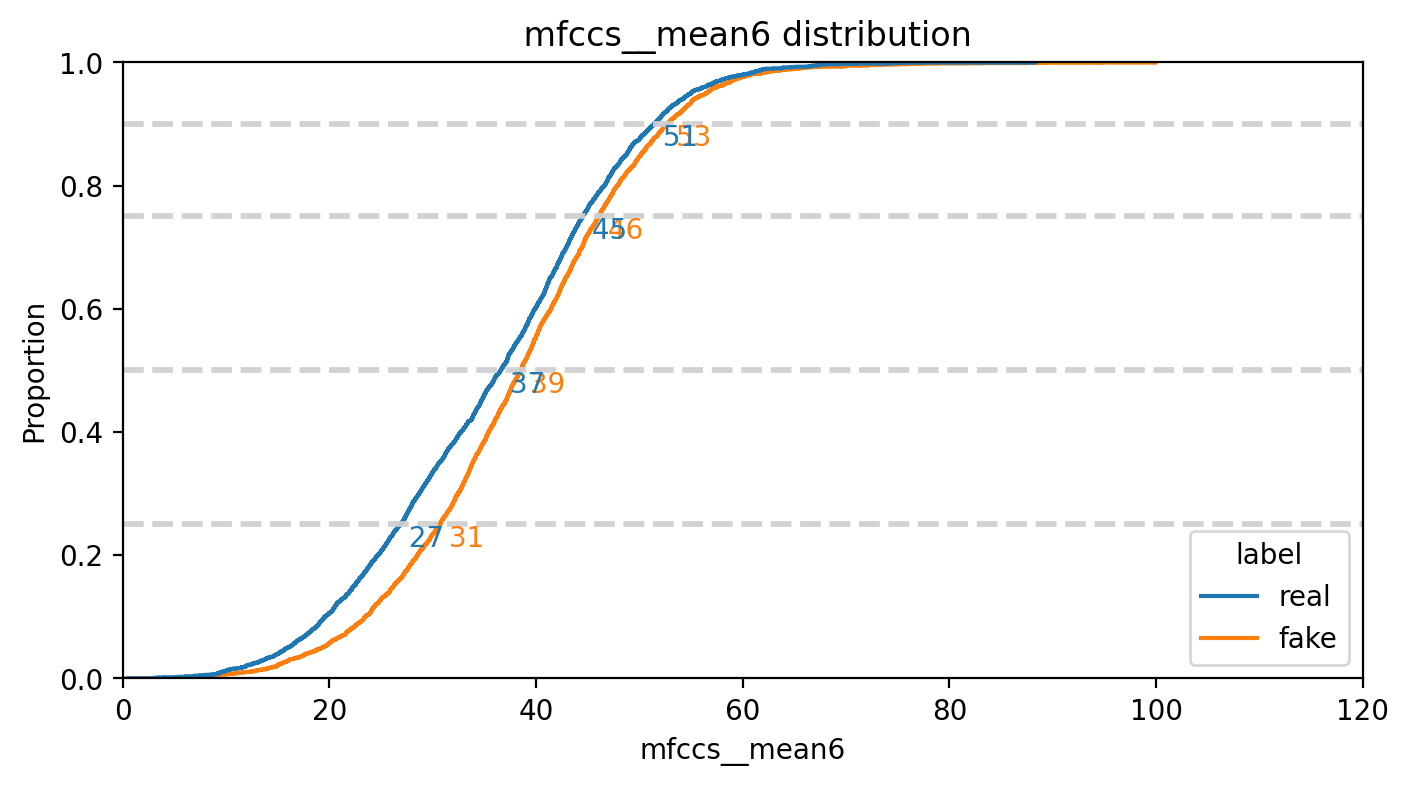

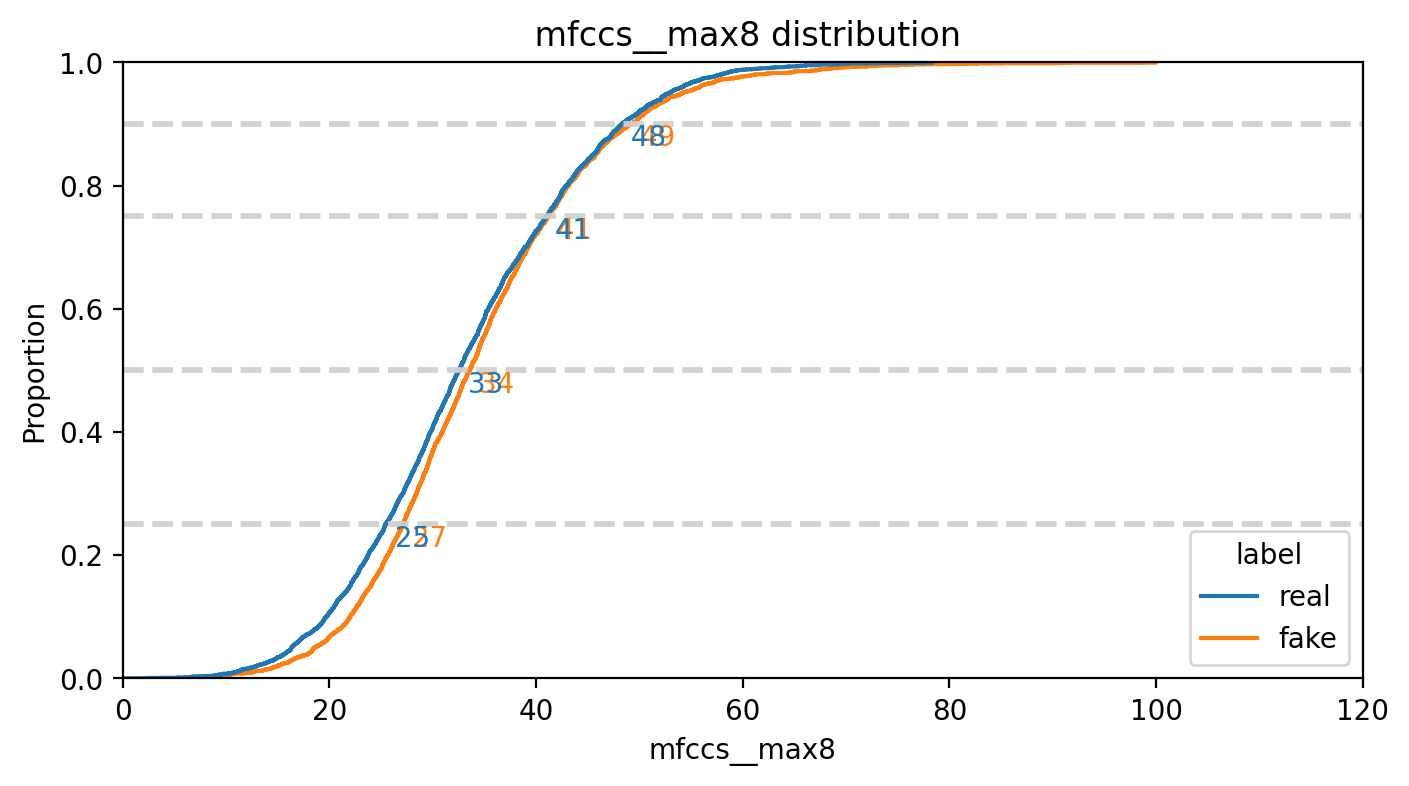

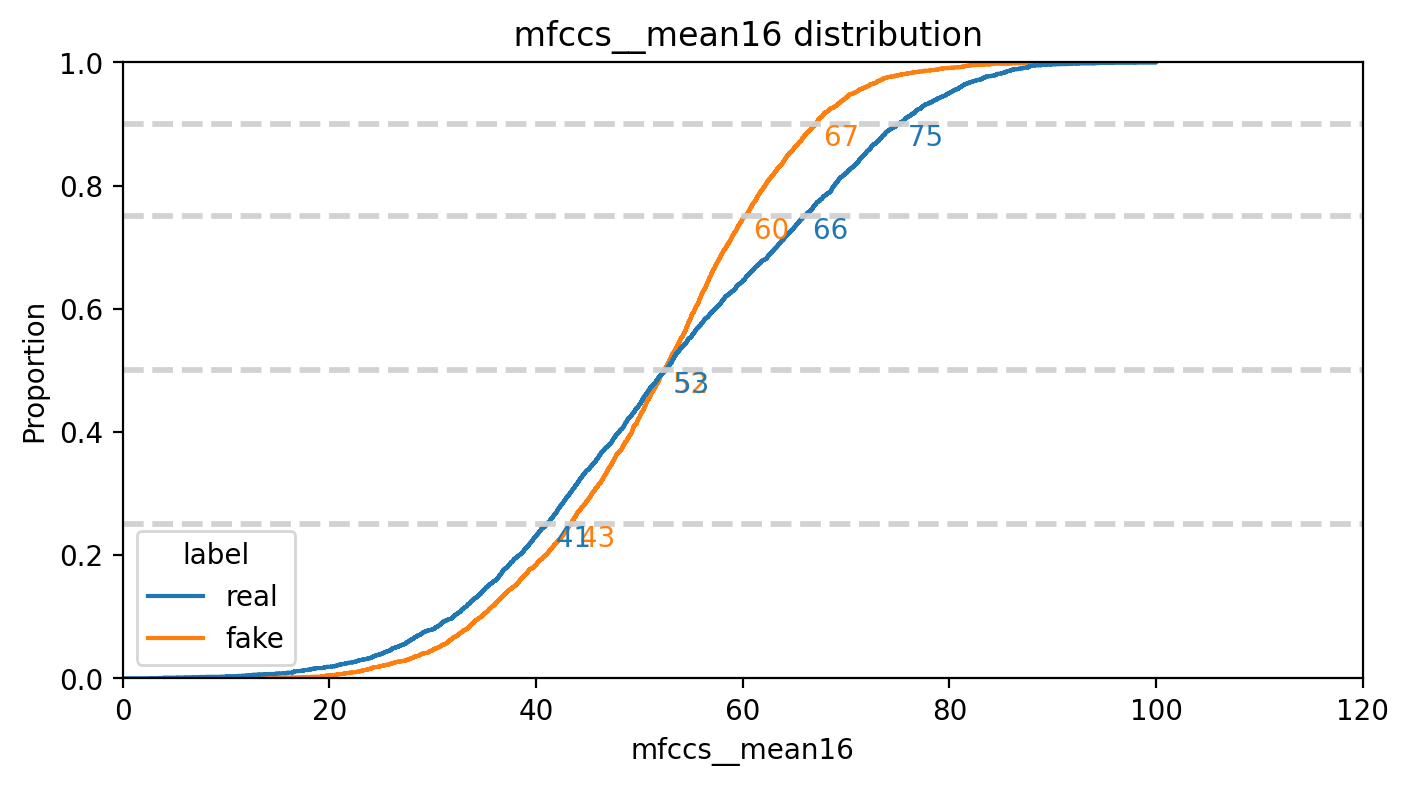

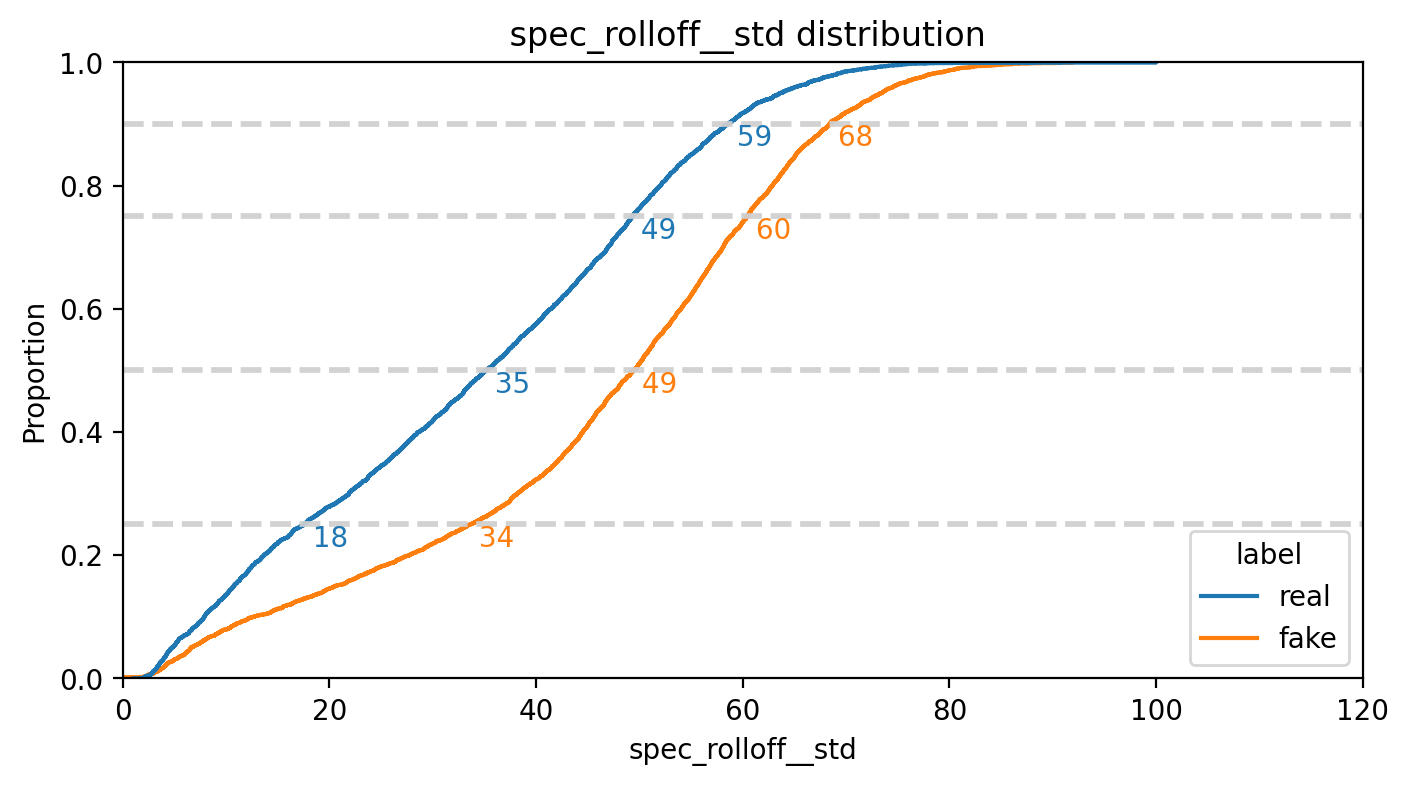

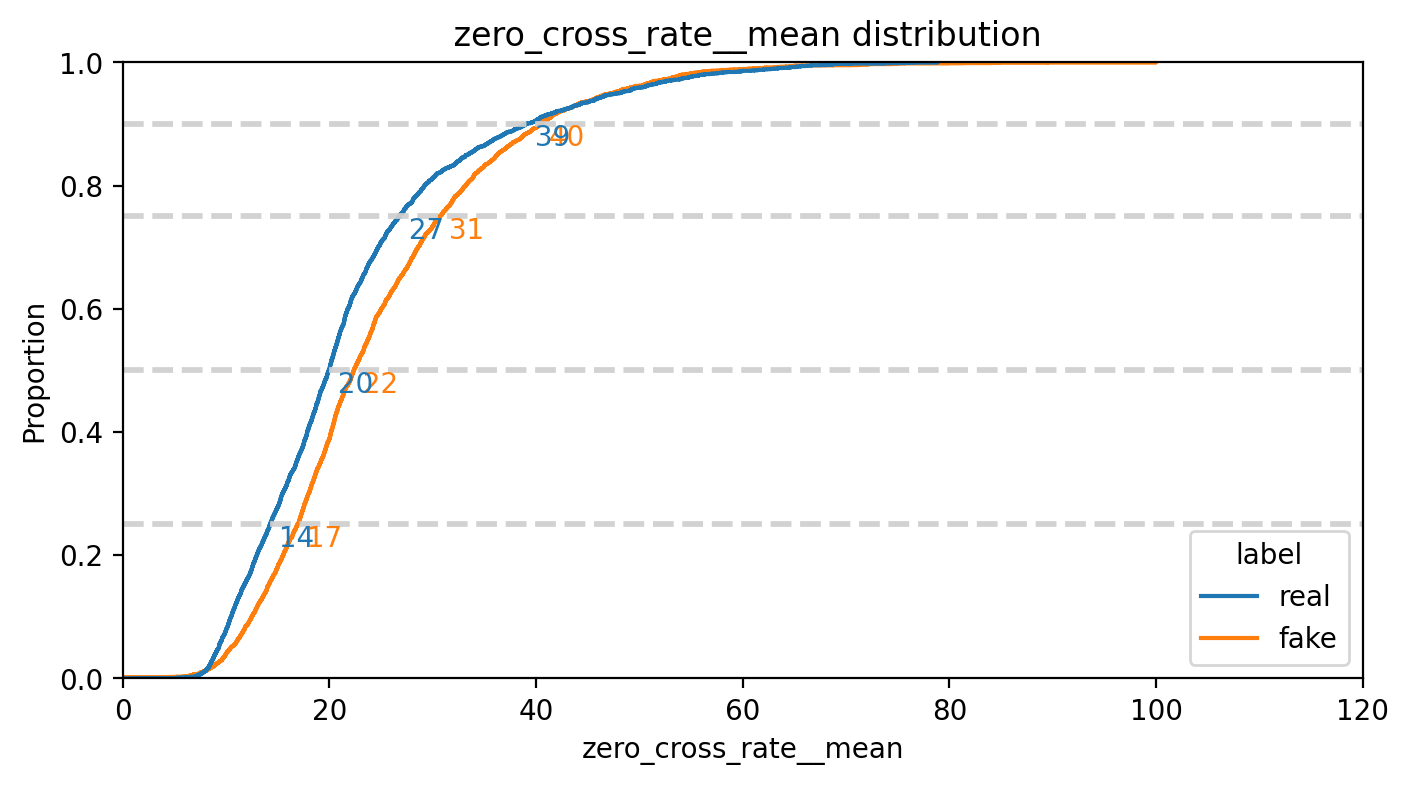

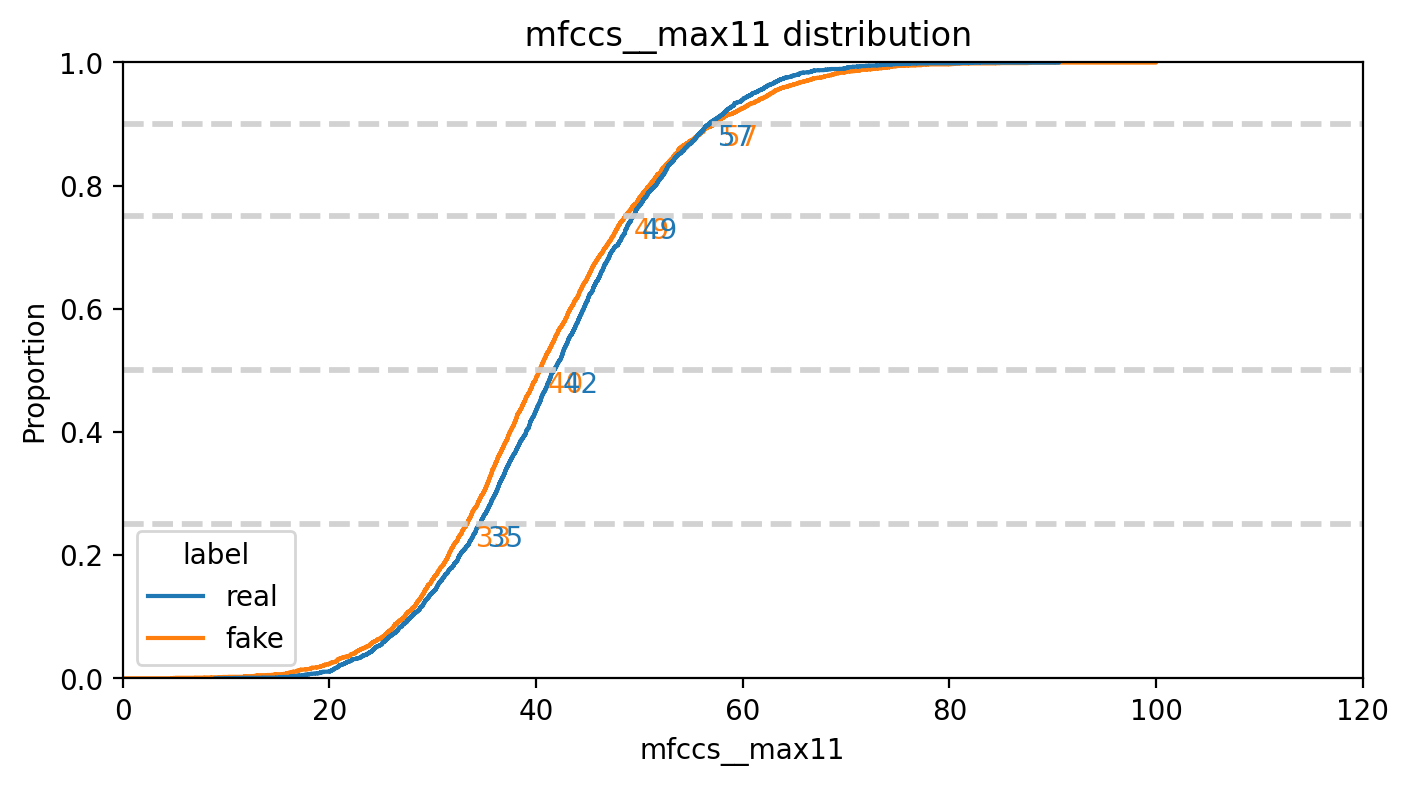

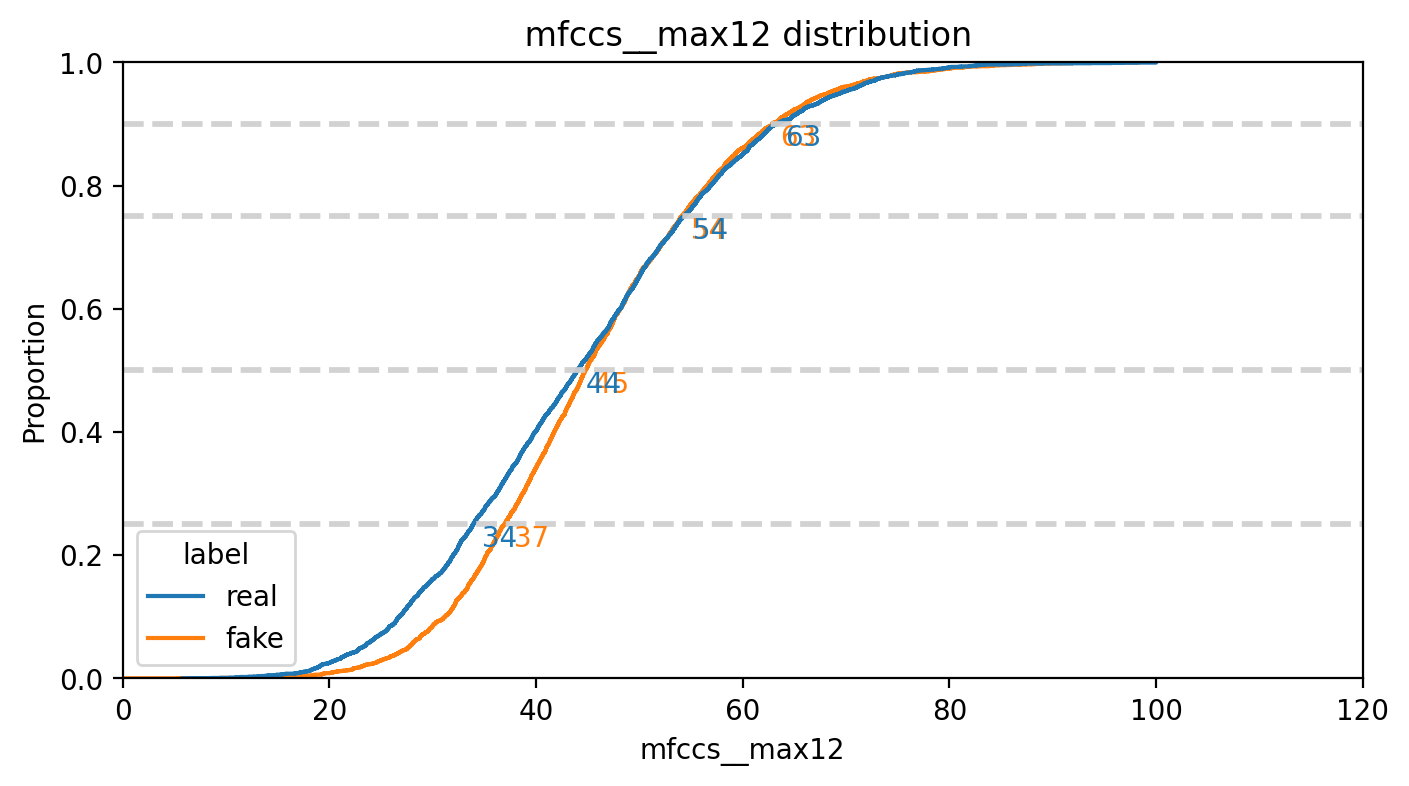

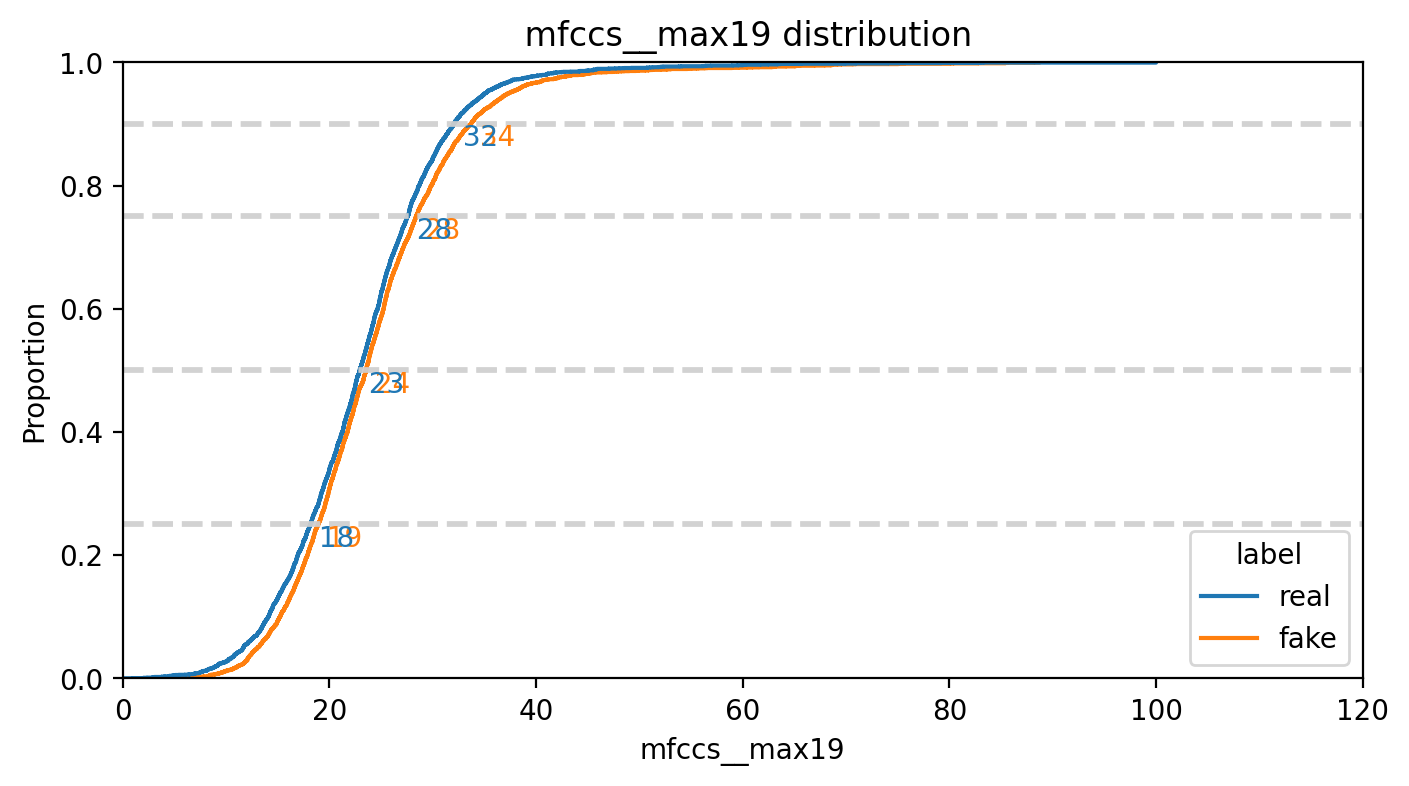

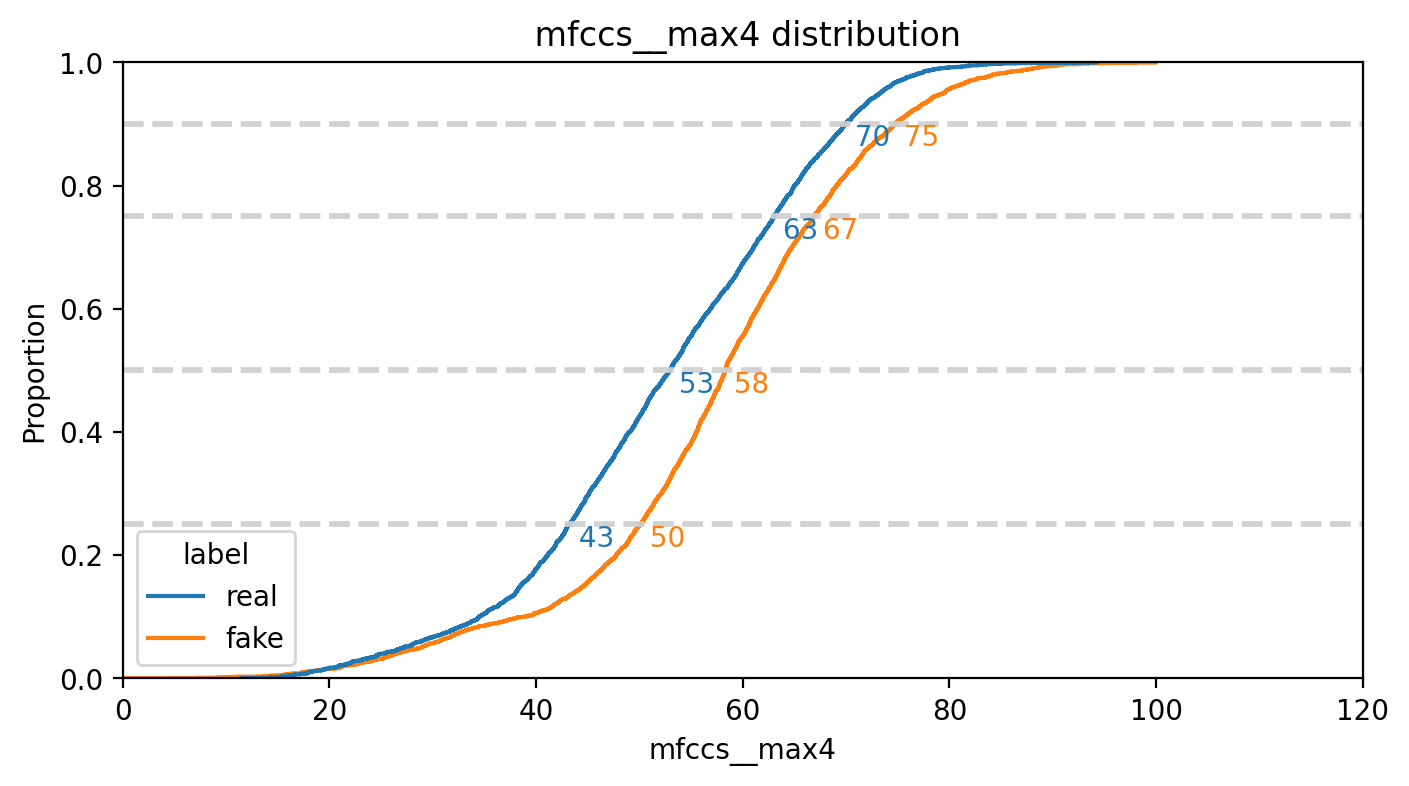

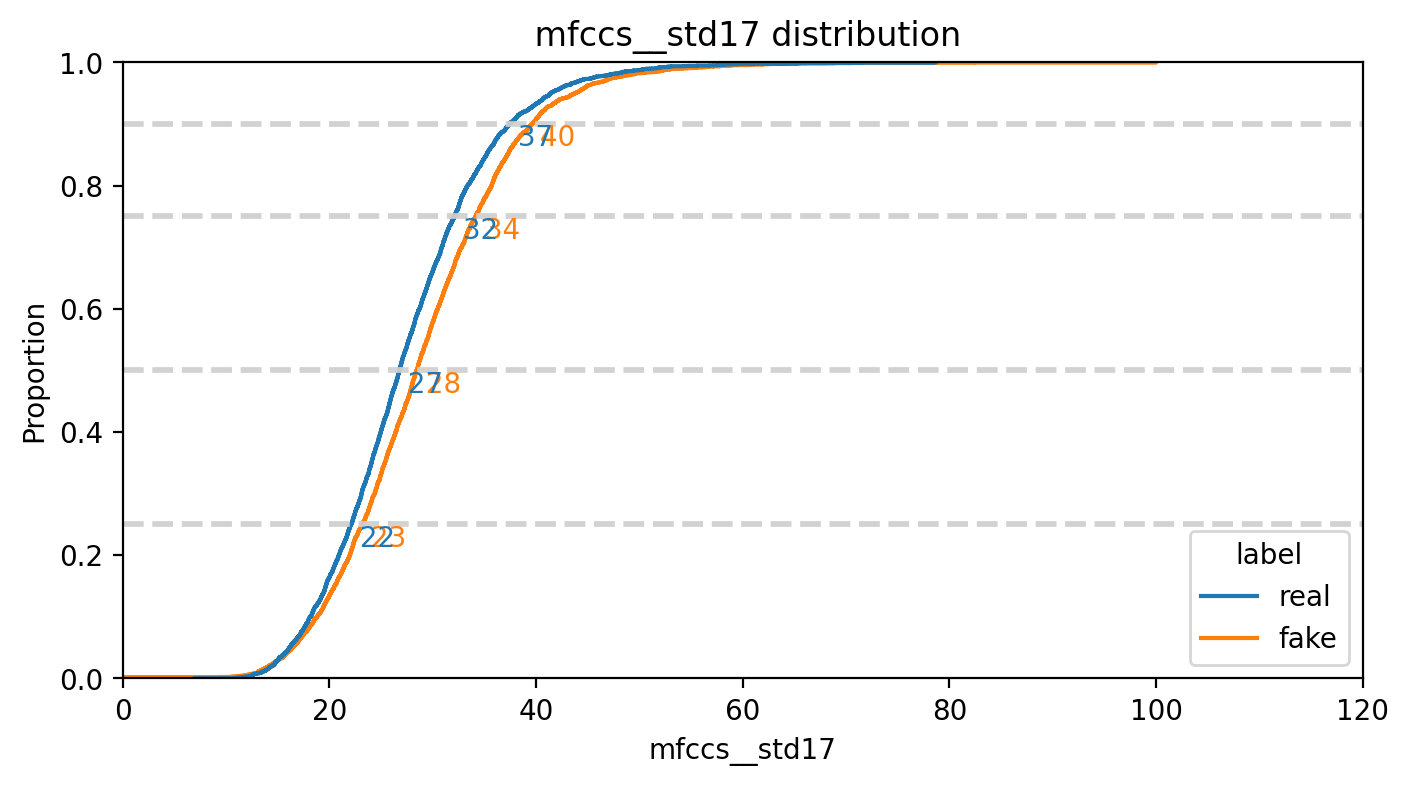

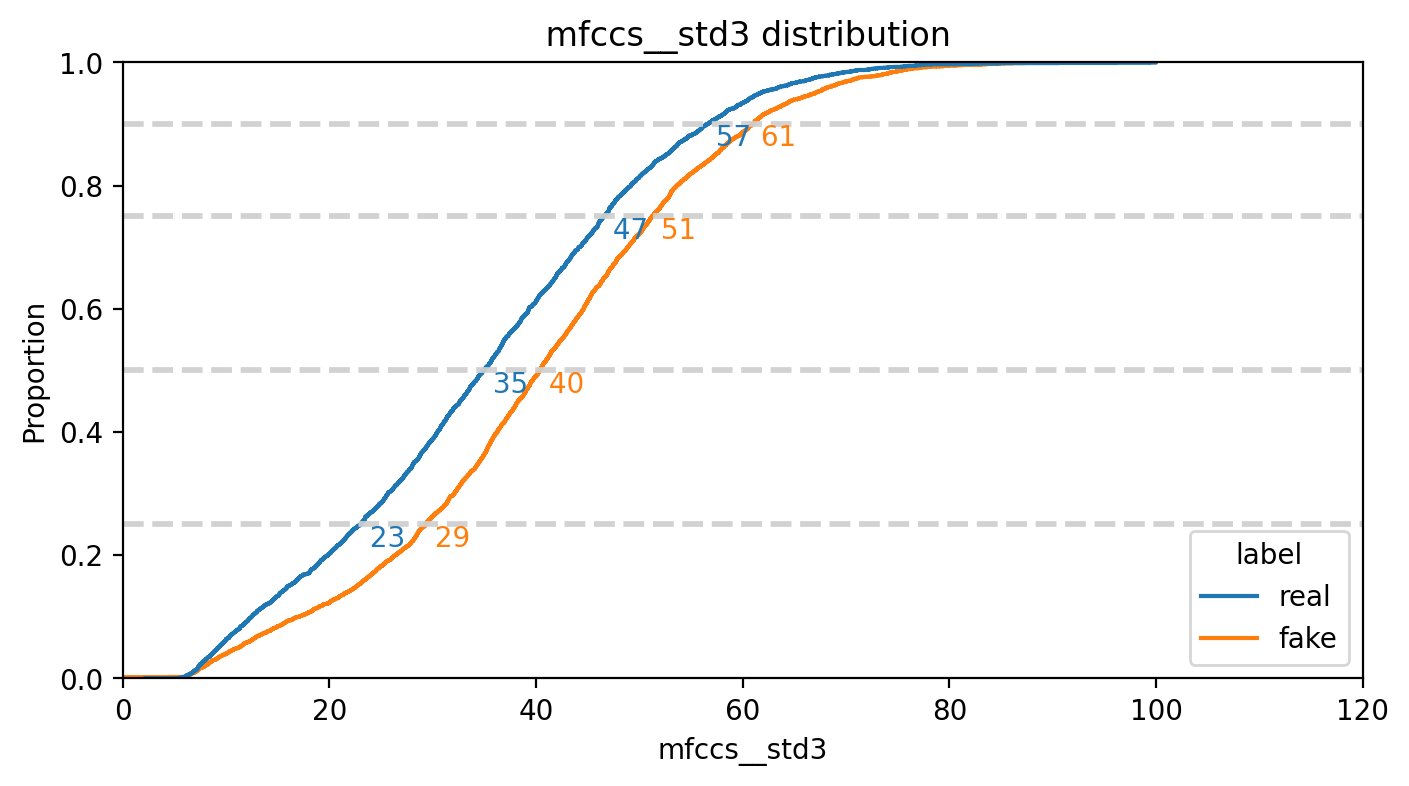

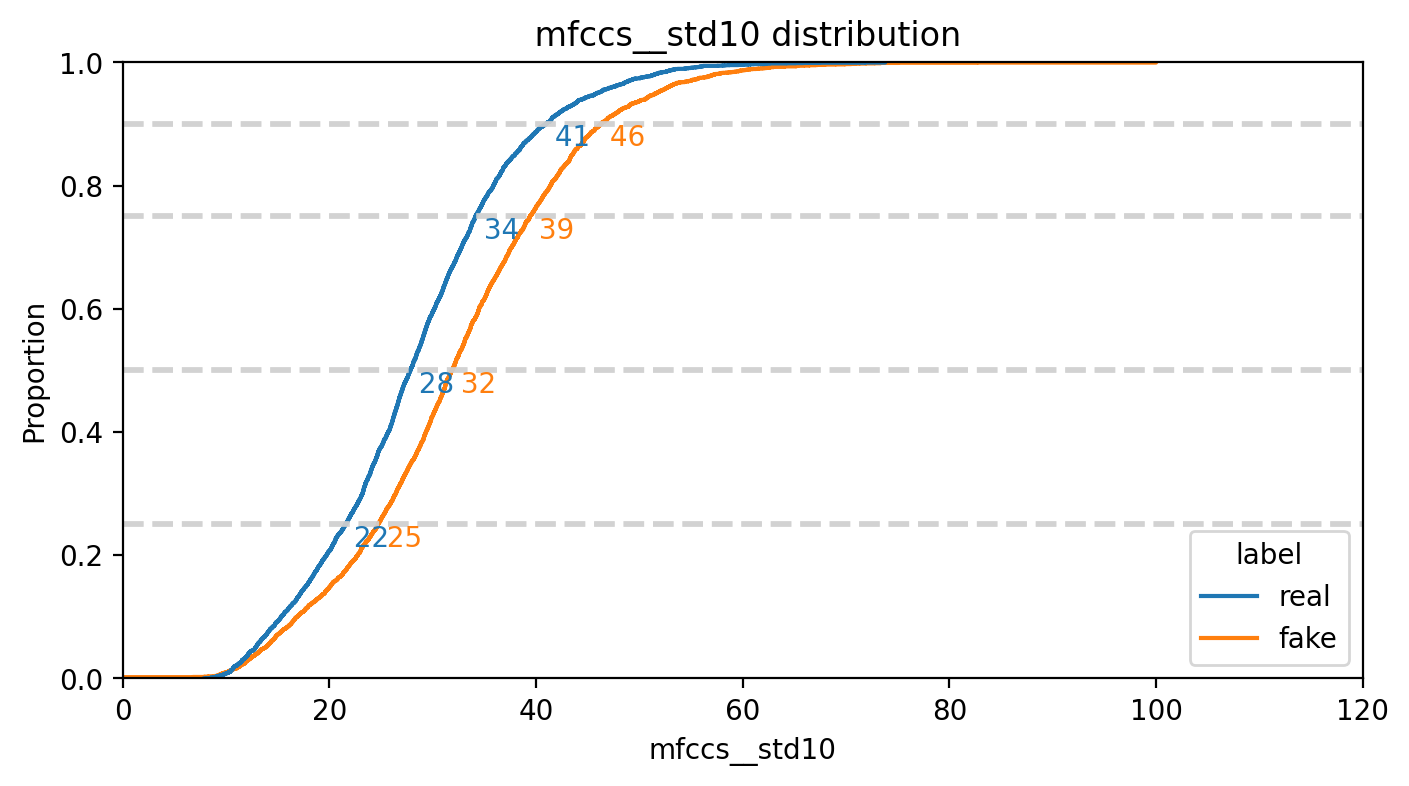

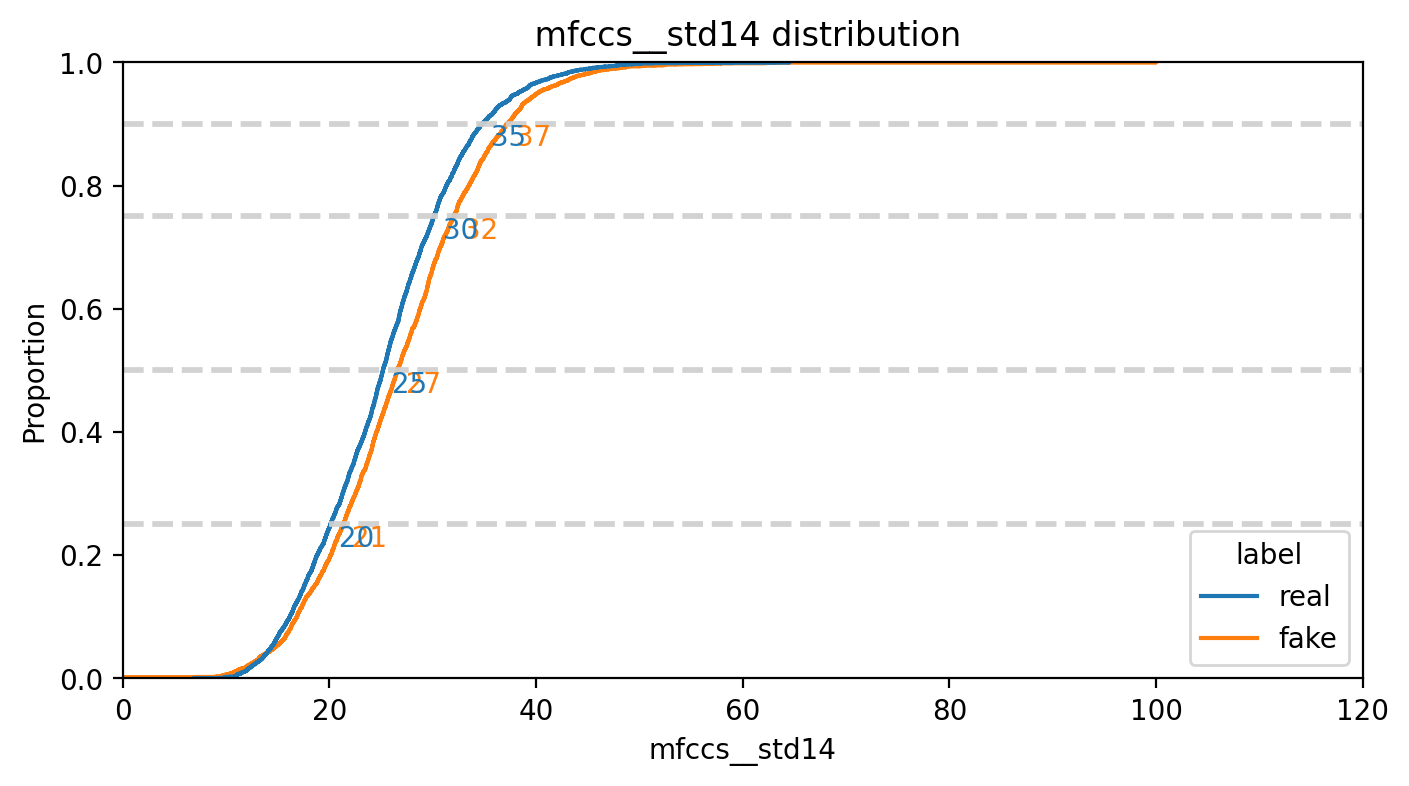

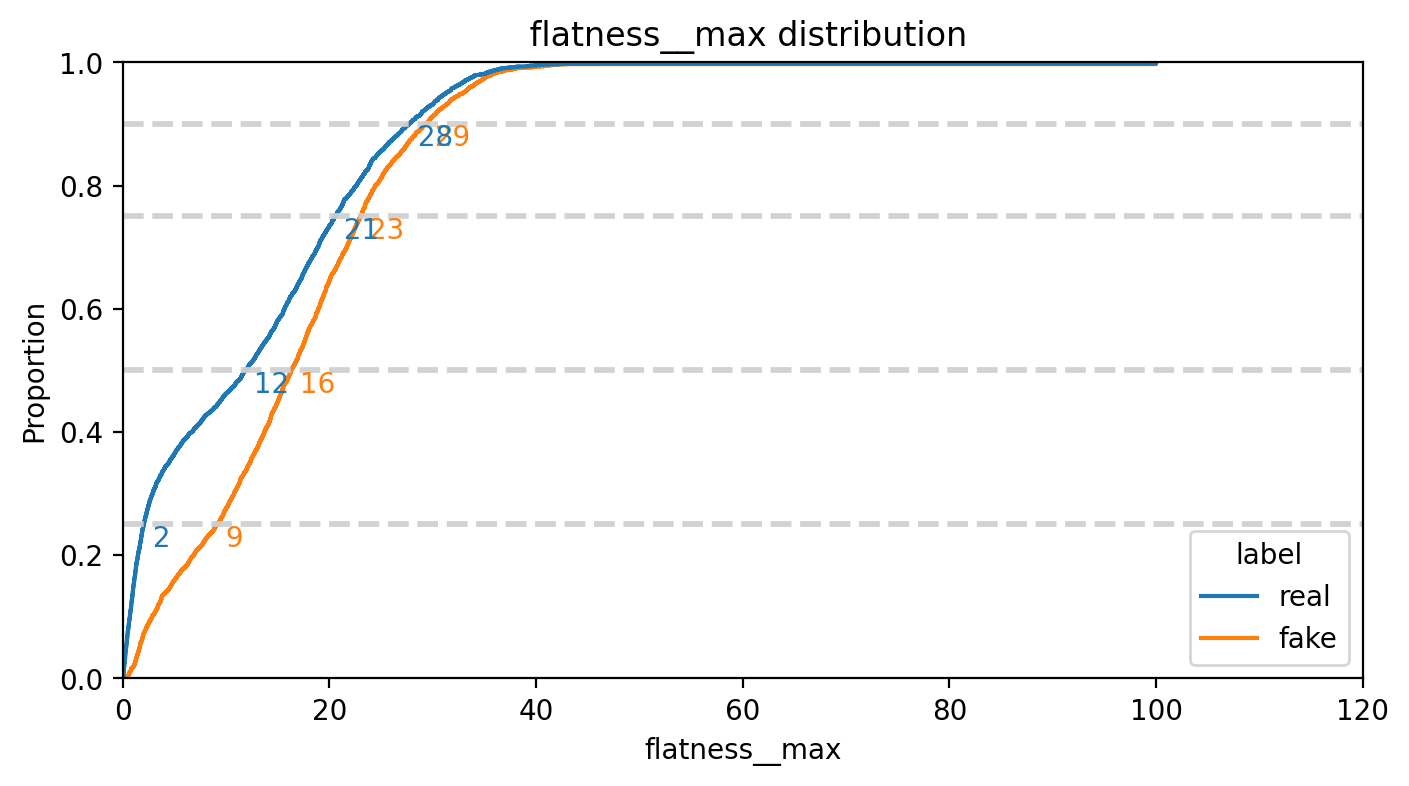

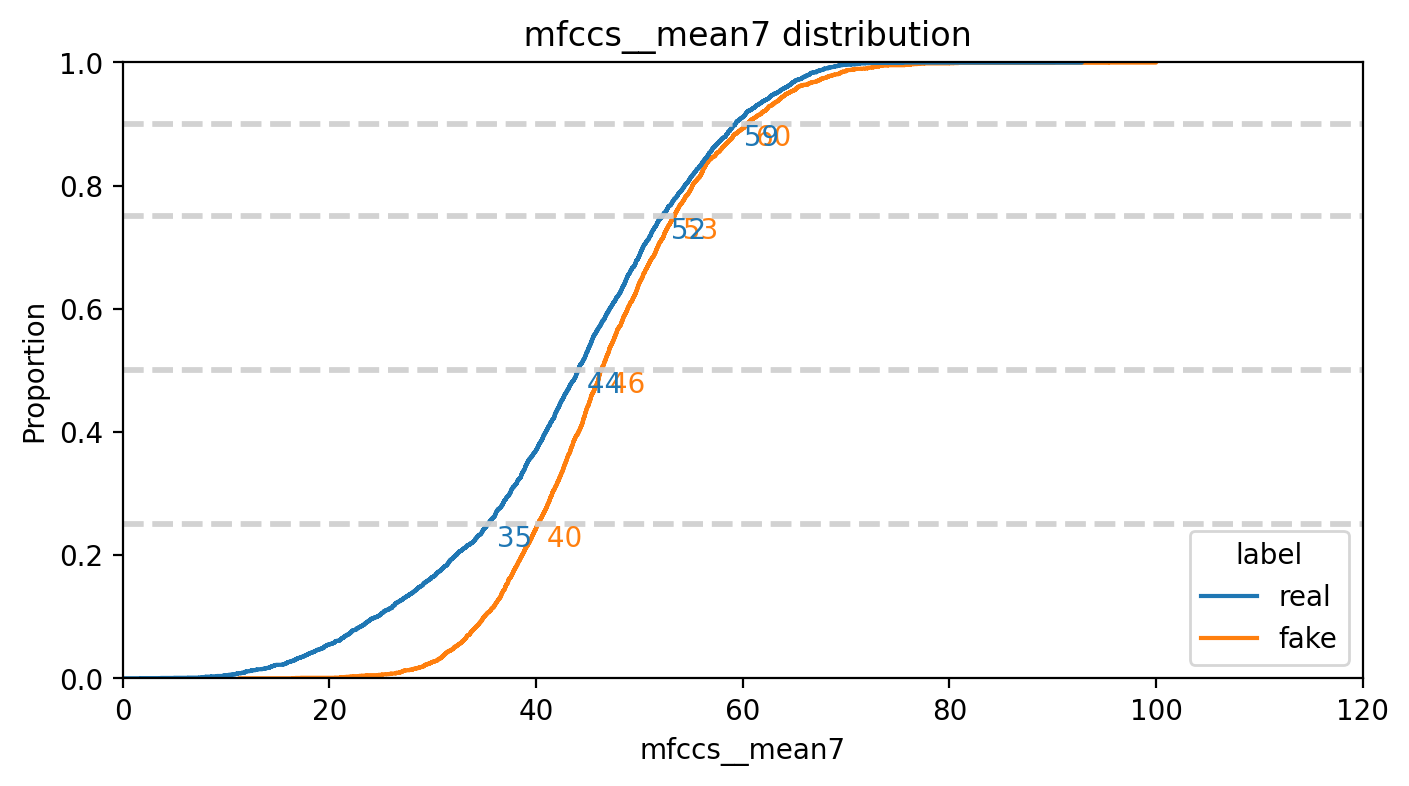

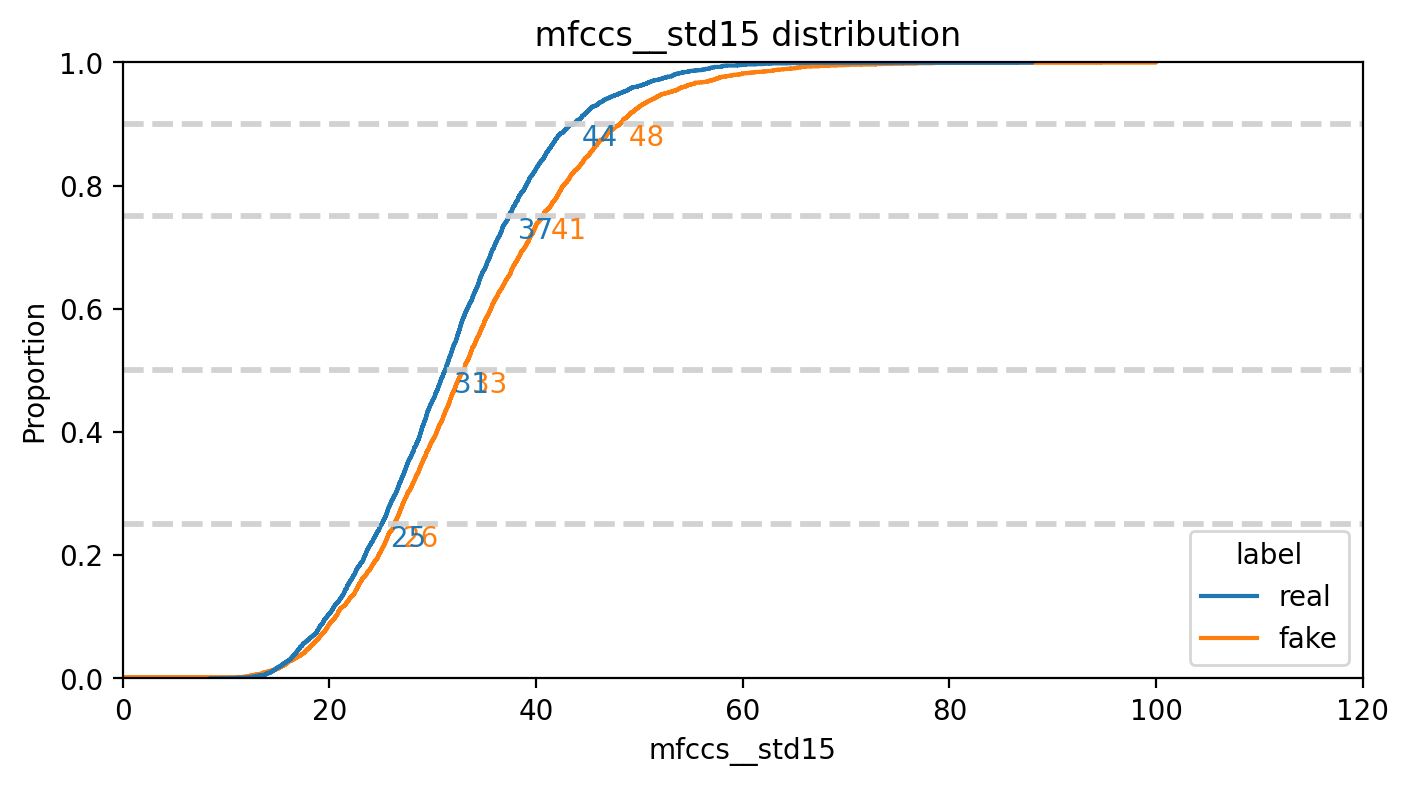

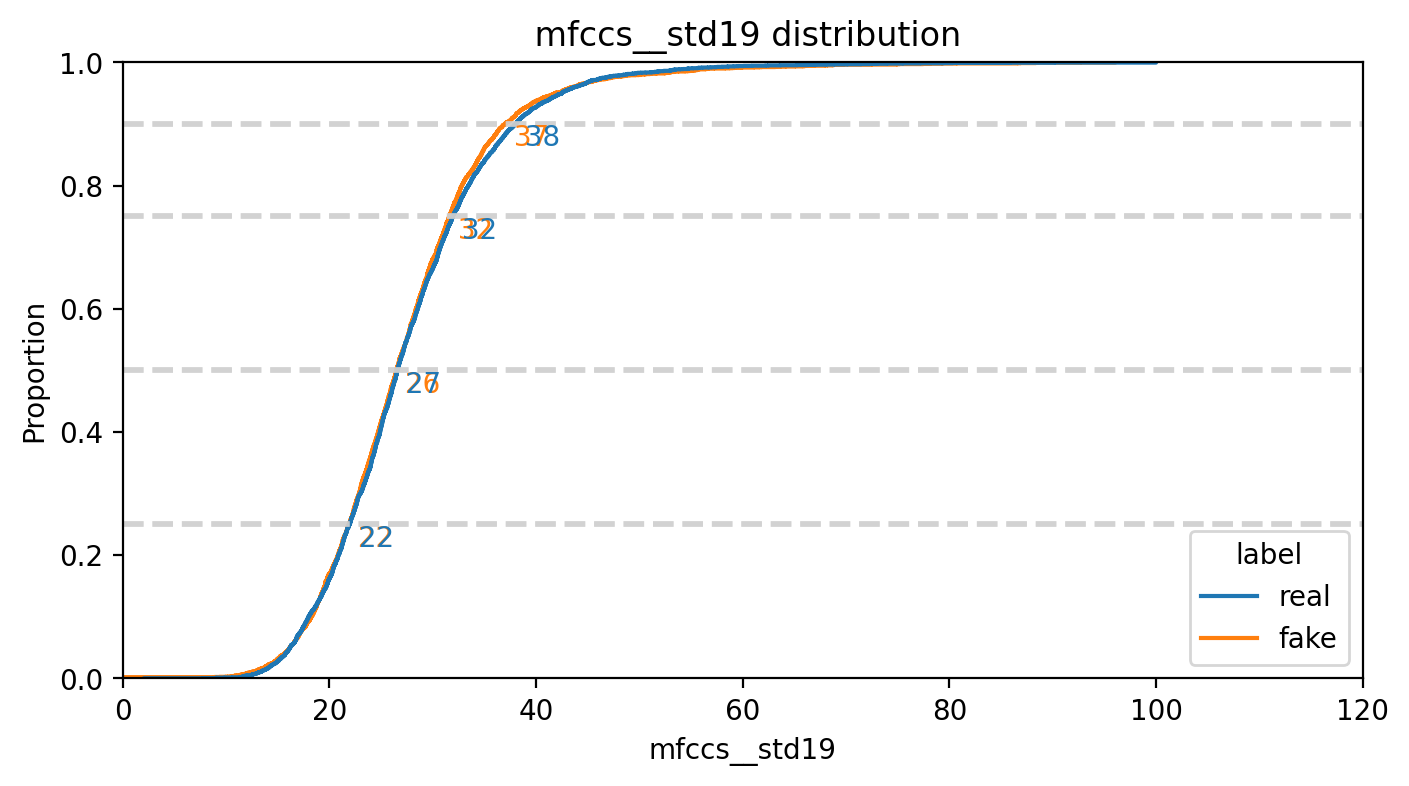

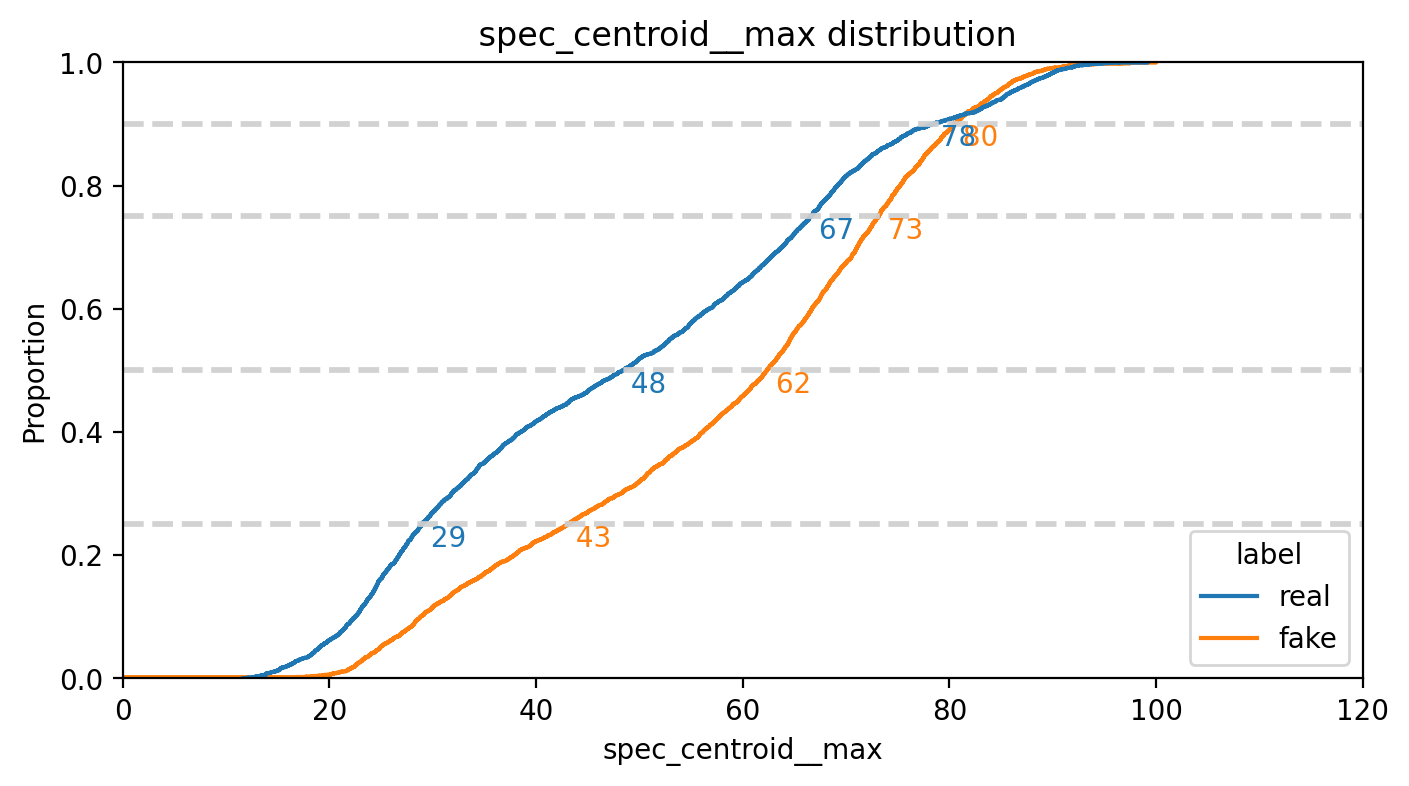

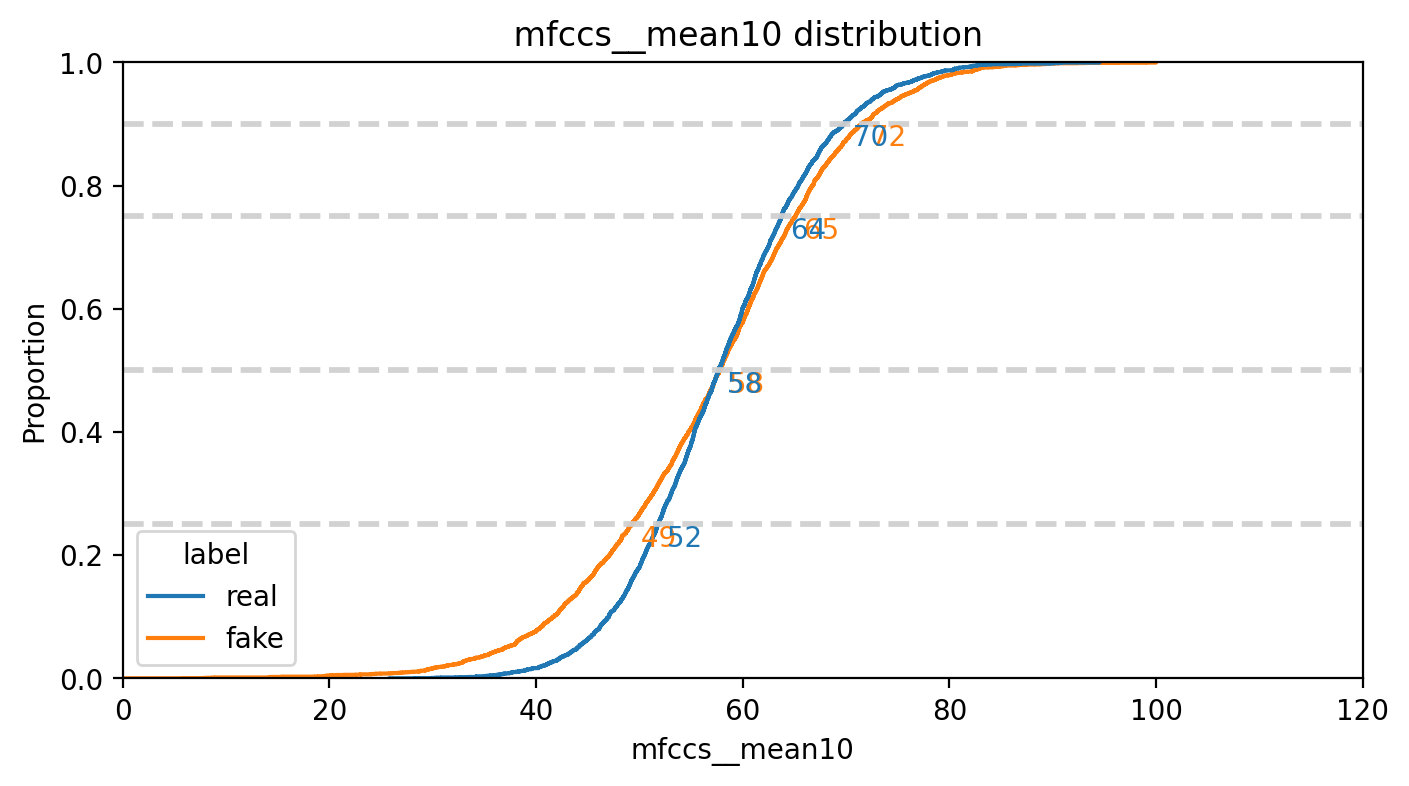

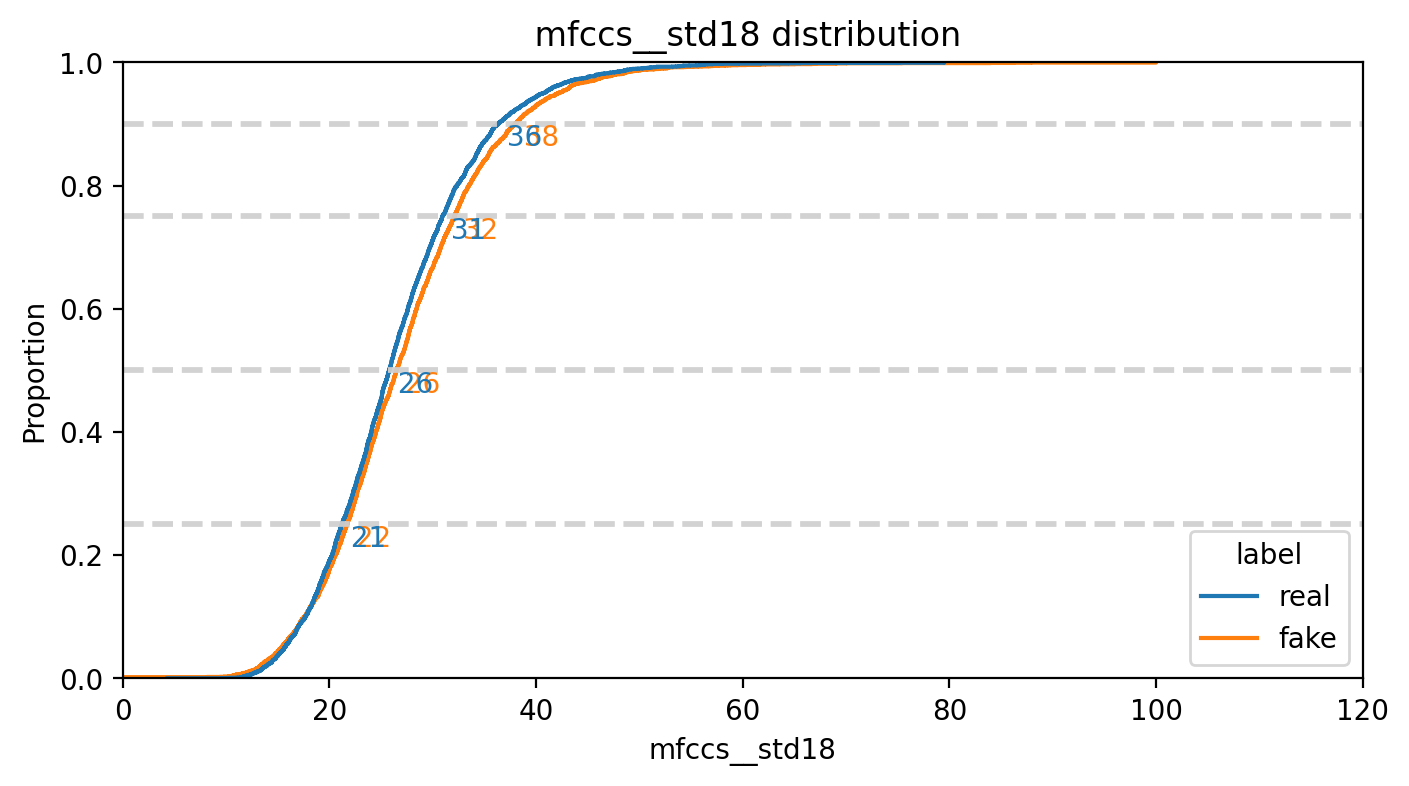

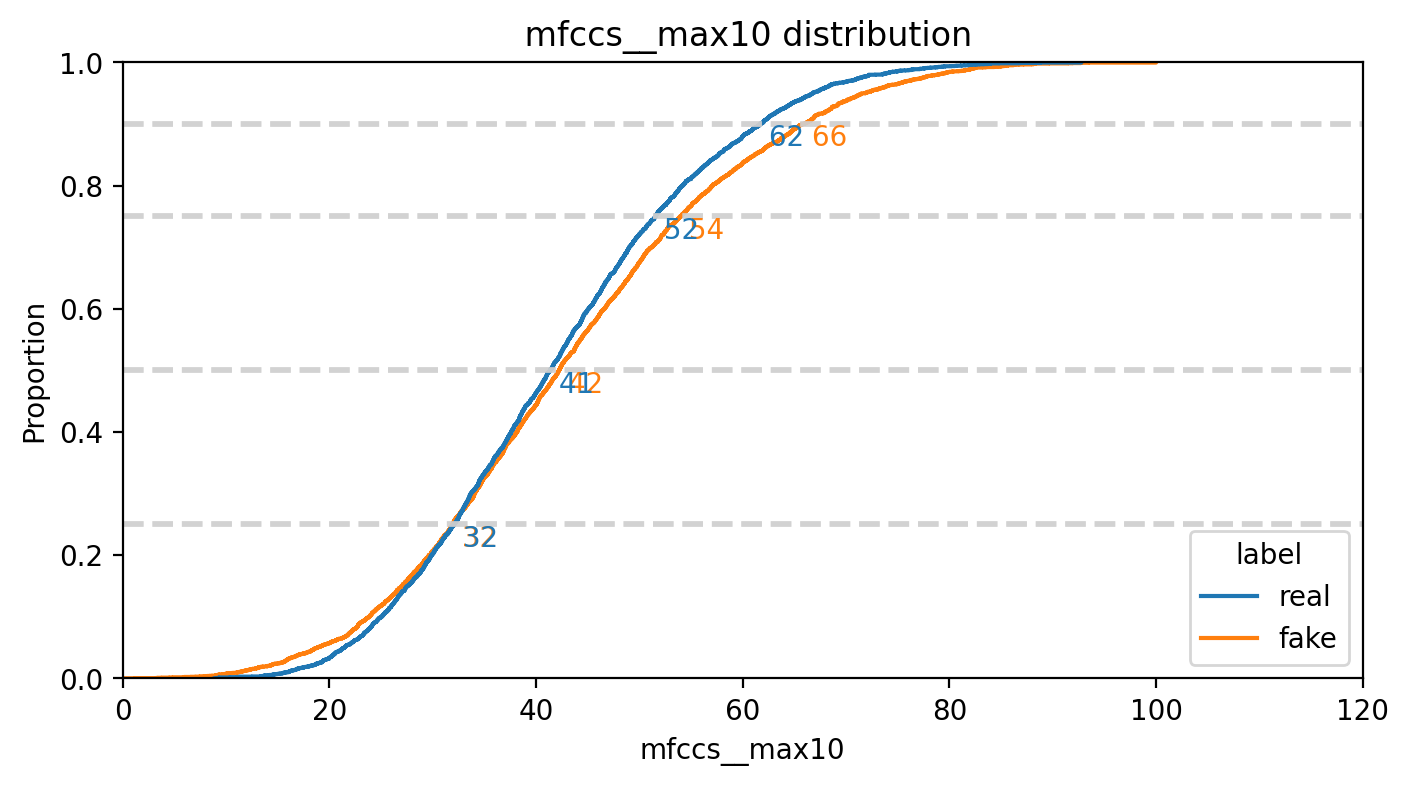

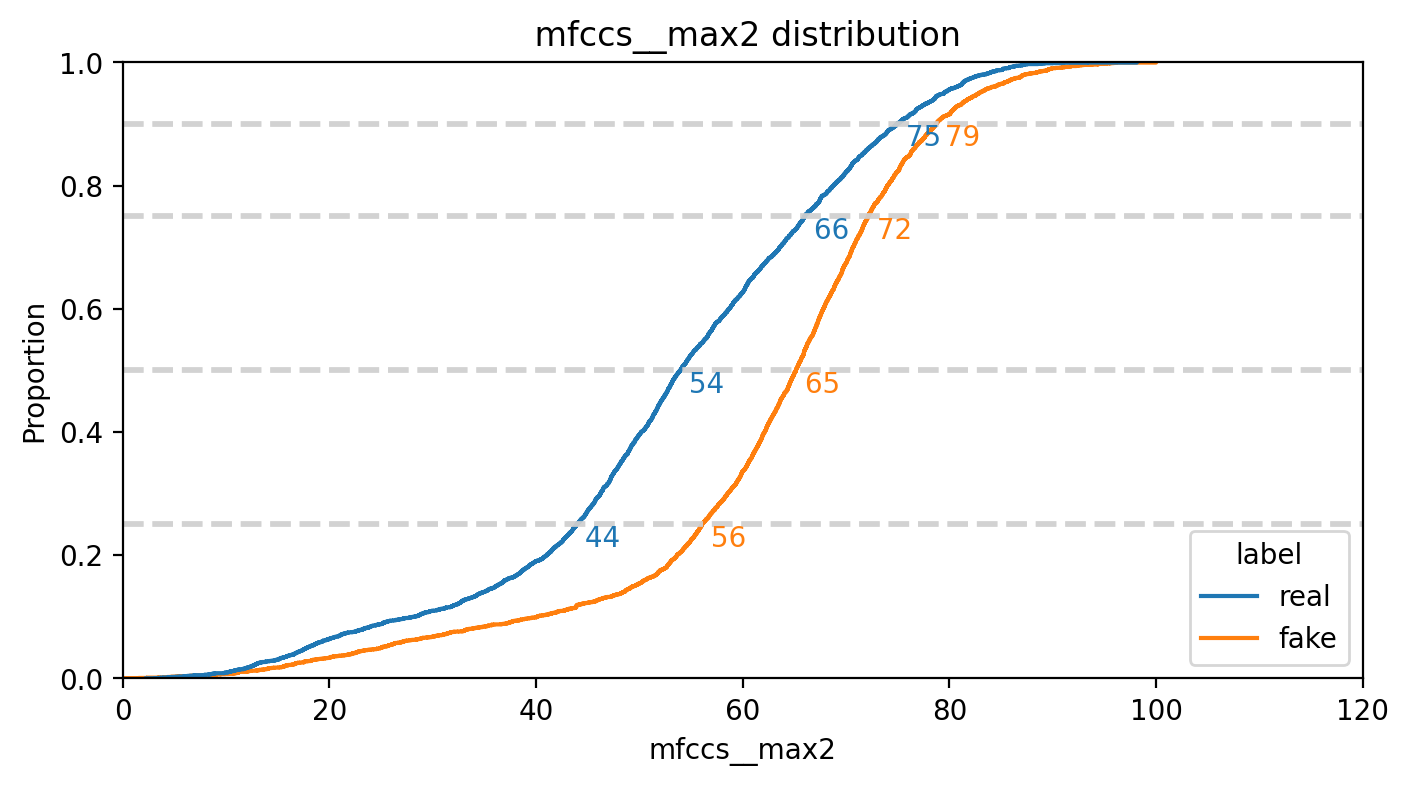

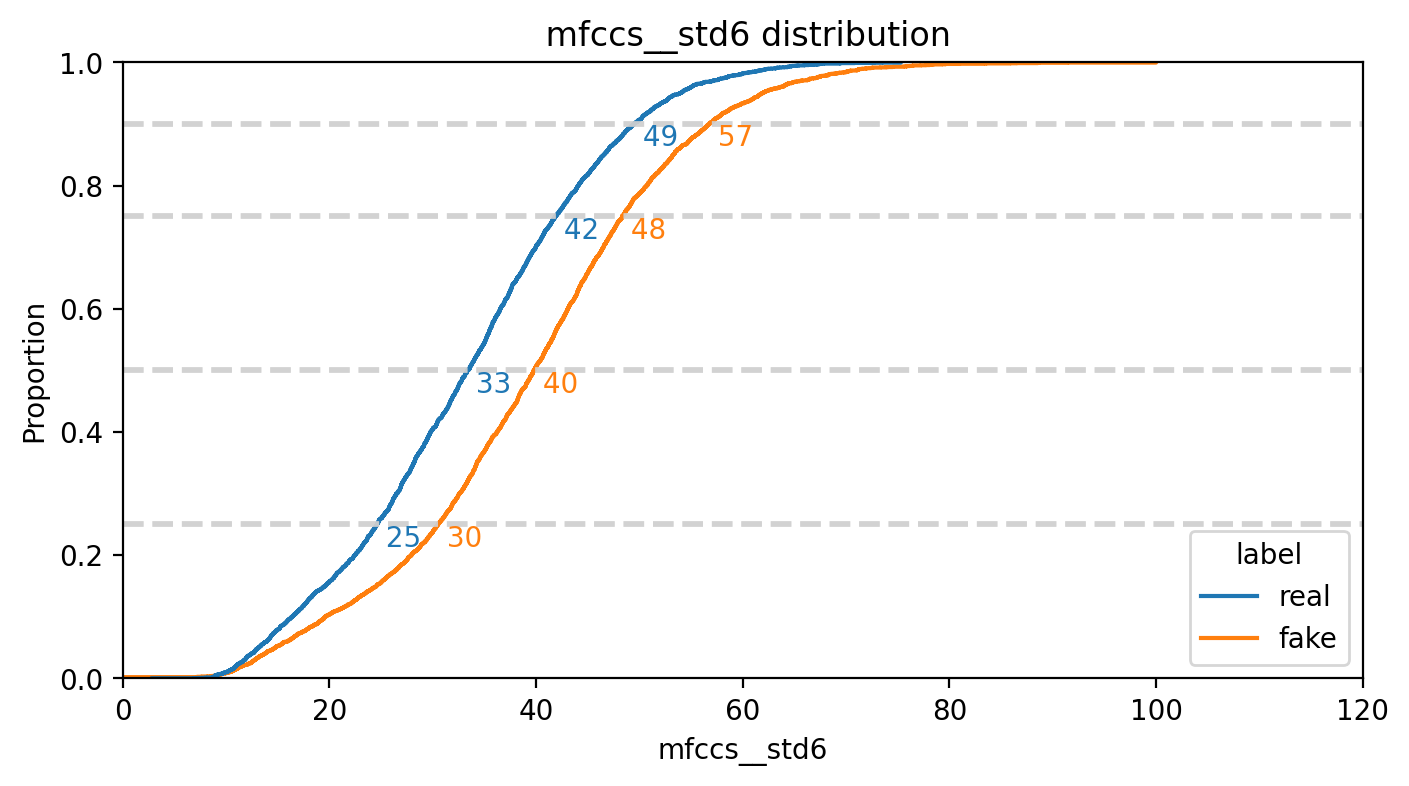

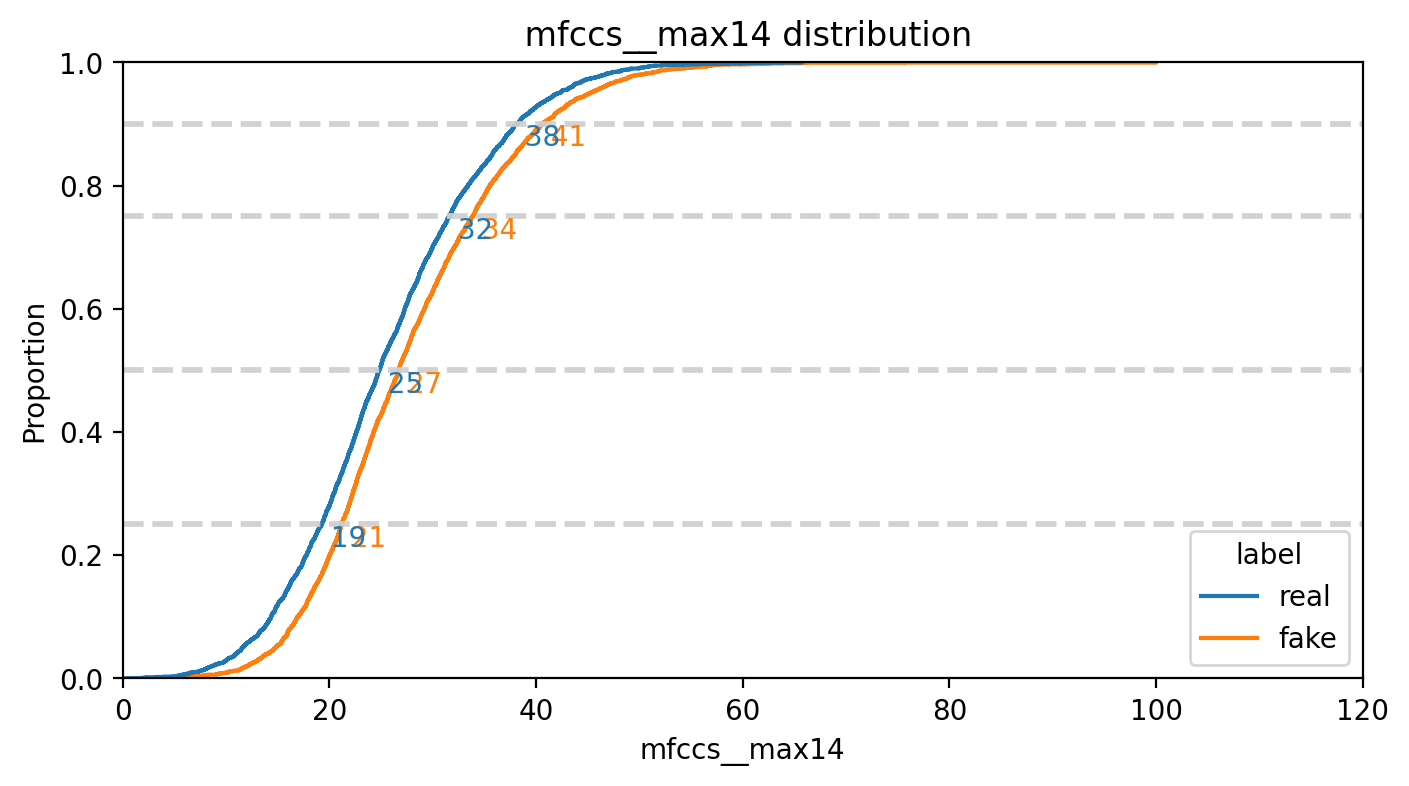

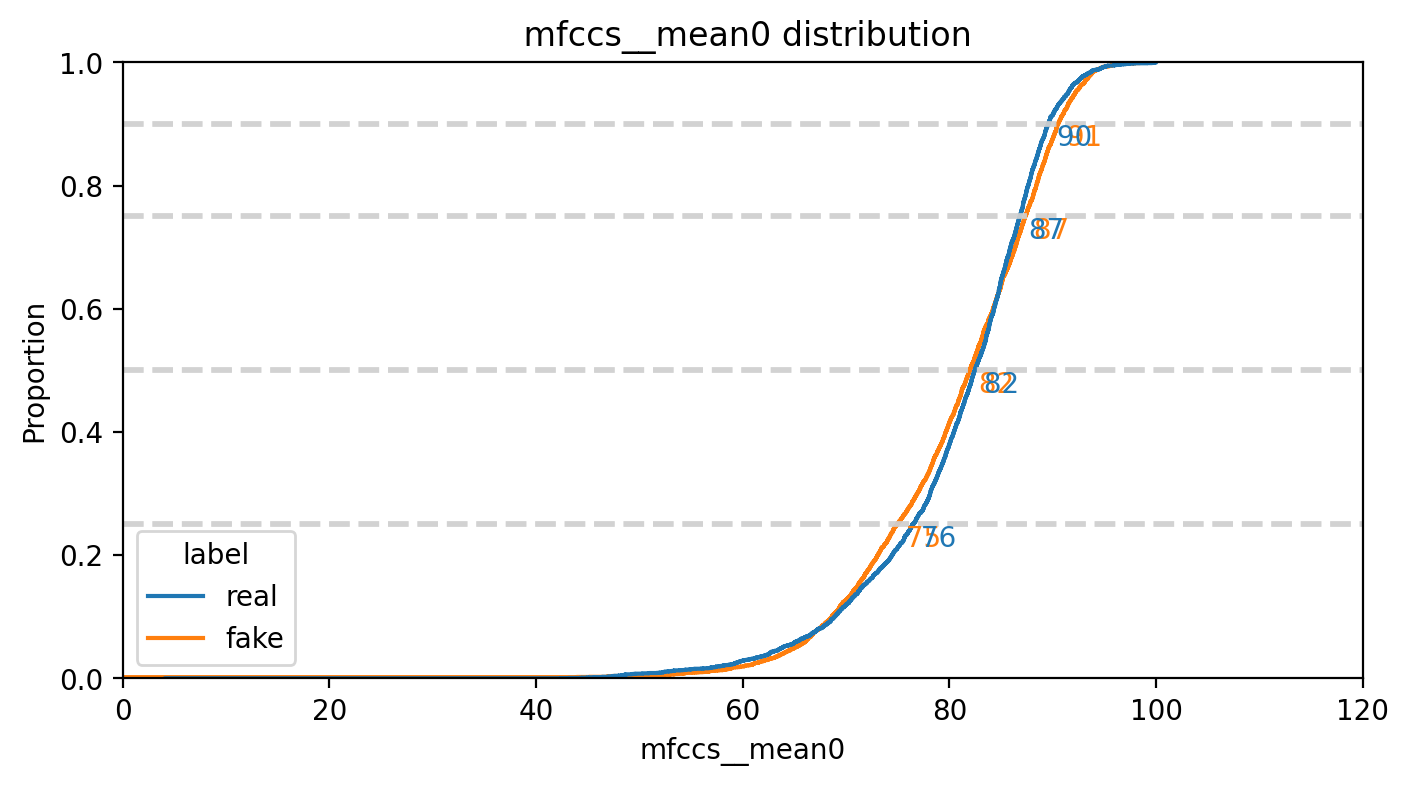

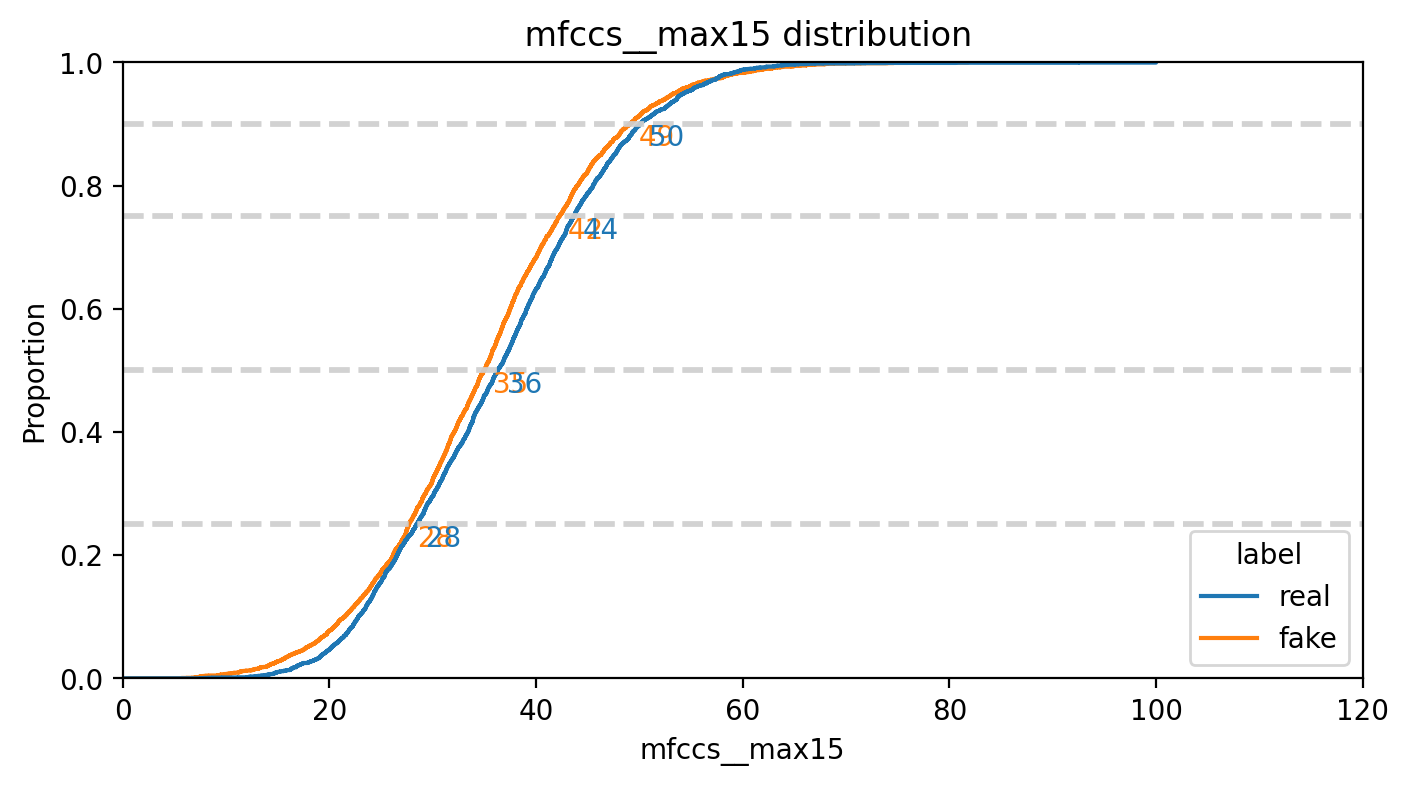

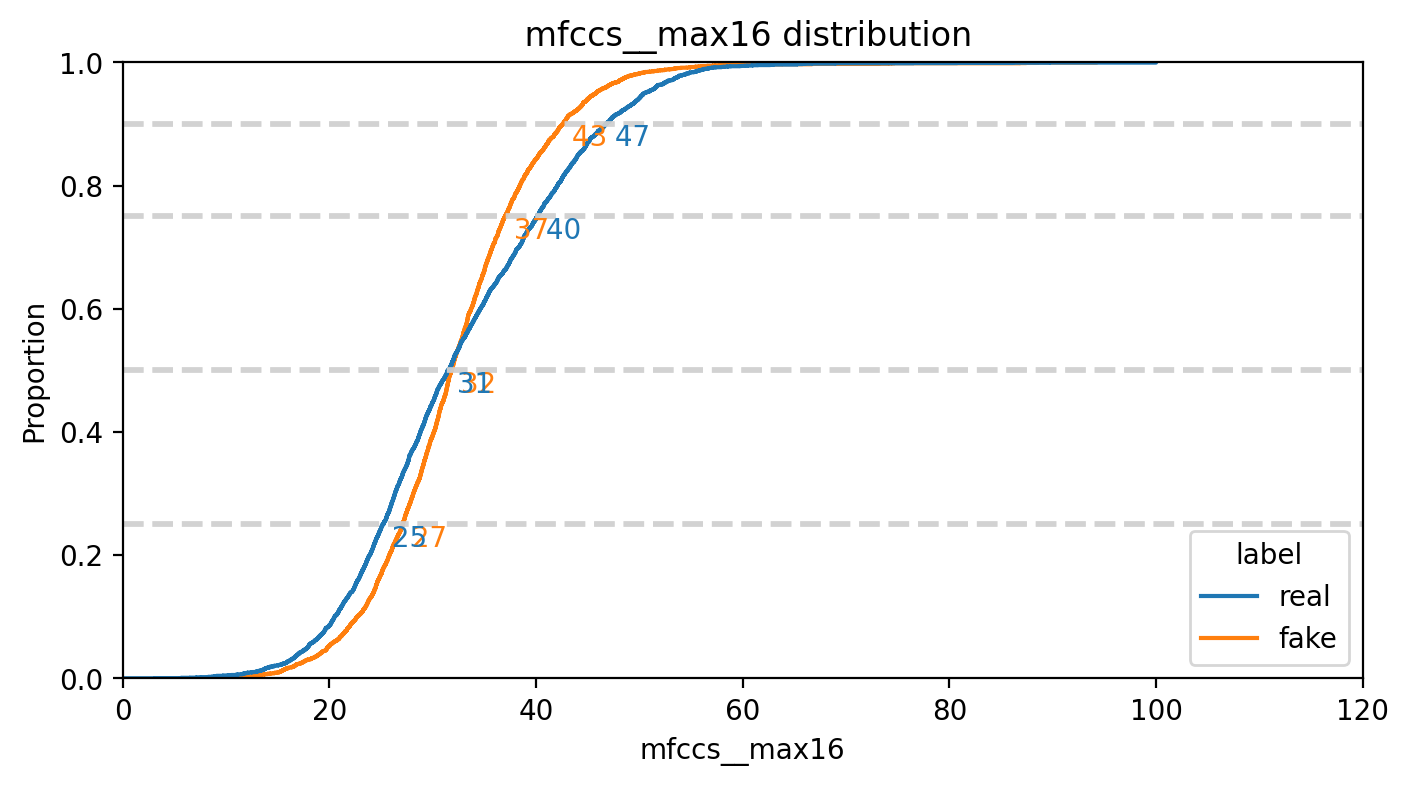

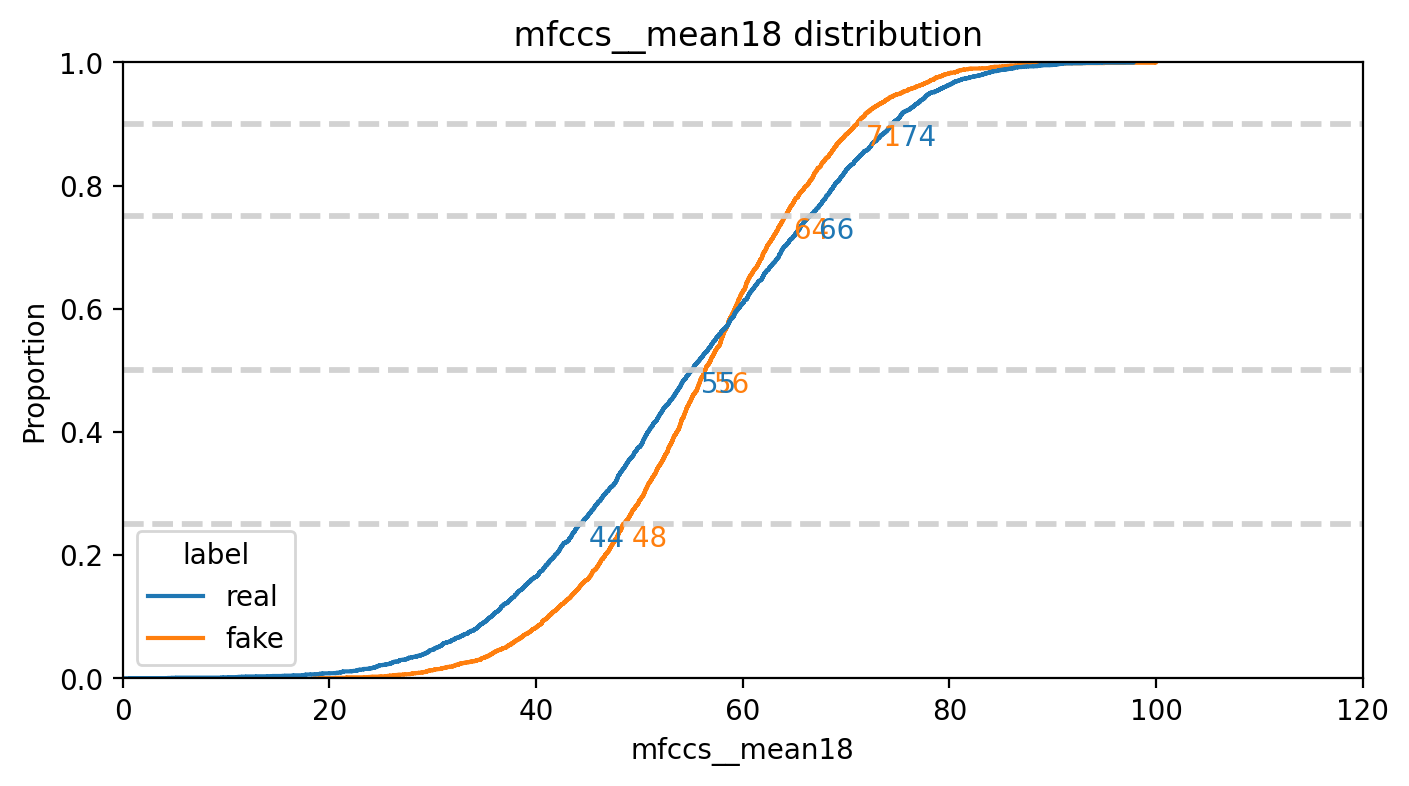

In [8]:
for col in feature_to_evaluate:
    show_specific_ecdf(data_in=X_scaled, var_in=col,hue='label',x_min=np.min(X_scaled[col]),x_max=np.max(X_scaled[col])*1.2)

In [9]:
cdf_feature=['rmse__max','mfccs__mean7','mfccs__std2','mfccs__mean2','bandwidth__std','spec_centroid__std','mfccs__std4','spec_centroid__max',
           'mfccs__std5','mfccs__max1','zero_cross_rate__max','spec_rolloff__max','mfccs__max2','mfccs__std0','spec_rolloff__std',
           'rmse__std','mfccs__mean1','zero_cross_rate__std','mfccs__std1','mfccs__max3','mfccs__std3','mfccs__mean4','mfccs__mean9','mfccs__std6',
            'mfccs__max4','bandwidth__mean','mfccs__max6','mfccs__std10','mfccs__max7','mfccs__std13','mfccs__std8'] #+ feature_to_exclude
print('cdf selected:',len(cdf_feature))

cdf selected: 31


In [15]:
minmax_corr = MinMaxScaler()
X_scaled = pd.DataFrame(minmax_corr.fit_transform(feature_data.loc[:,cdf_feature]))

In [22]:
#estimate kmeans clusters
estimate_kmean_para(X=X_scaled,max_cluster=4)       

n_clusters: 2 average silhouette : 0.300744982872522
***stat on deviation***
mean 0.0416199427852994
max 0.04956621010556972
n_clusters: 3 average silhouette : 0.25783915099426635
***stat on deviation***
mean 0.08554045726533586
max 0.11876162025147918


In [12]:
kmean_cl = KMeans(n_clusters=2, n_init="auto", random_state=1110)
kmean_labels = kmean_cl.fit_predict(X_scaled)
X_scaled['cluster'] = kmean_labels
X_scaled['real'] = (feature_data.label=='real').astype(int)

In [13]:
res=X_scaled.groupby(['cluster'],as_index=False).agg(tot=('real','count'),real_sum=('real','sum'))
res['%_real']=res.real_sum/res.tot
res   

cluster   tot  real_sum    %_real
0        0  4572      1777  0.388670
1        1  2928      1973  0.673839

#### eda - spearman correlation

In [23]:
spearm_corr=feature_data.loc[:,feature_data_predictors].corr('spearman')
spearm_corr['mean_corr']= spearm_corr.mean(axis=1)

In [24]:
spearam_feature_scored=spearm_corr.sort_values(by=['mean_corr'],ascending=False).index
less_corr=spearam_feature_scored[:30]
print('less correlated features:\n',less_corr)

less correlated features:
 Index(['mfccs__std1', 'spec_rolloff__std', 'bandwidth__std', 'mfccs__max2',
       'spec_centroid__std', 'mfccs__max5', 'mfccs__max4', 'mfccs__std5',
       'mfccs__std2', 'mfccs__max3', 'mfccs__std3', 'mfccs__mean2',
       'mfccs__std10', 'mfccs__std4', 'mfccs__std7', 'mfccs__std8',
       'bandwidth__max', 'zero_cross_rate__std', 'spec_centroid__max',
       'mfccs__std9', 'mfccs__max14', 'spec_rolloff__max', 'mfccs__mean4',
       'mfccs__std6', 'mfccs__std13', 'mfccs__std0', 'mfccs__mean3',
       'mfccs__std11', 'mfccs__max6', 'zero_cross_rate__max'],
      dtype='object')


In [25]:
minmax_corr = MinMaxScaler()
X_scaled = pd.DataFrame(minmax_corr.fit_transform(feature_data.loc[:,less_corr]))
#estimate kmeans clusters
estimate_kmean_para(X=X_scaled,max_cluster=5)       

n_clusters: 2 average silhouette : 0.3266545913792881
***stat on deviation***
mean 0.018043154349487823
max 0.022117877289336285
n_clusters: 3 average silhouette : 0.24500518891572517
***stat on deviation***
mean 0.10182484979638393
max 0.15404773274223585
n_clusters: 4 average silhouette : 0.18520102144954367
***stat on deviation***
mean 0.10933928527877715
max 0.20231164230908358


In [26]:
kmean_cl = KMeans(n_clusters=2, n_init="auto", random_state=1110)
kmean_labels = kmean_cl.fit_predict(X_scaled)
X_scaled['cluster'] = kmean_labels
X_scaled['real'] = (feature_data.label=='real').astype(int)
res=X_scaled.groupby(['cluster'],as_index=False).agg(tot=('real','count'),real=('real','sum'))
res['%_real']=res.real/res.tot
res                     

cluster   tot  real    %_real
0        0  4761  1907  0.400546
1        1  2739  1843  0.672873

#### eda - pca

In [31]:
pca_dec = decomposition.PCA(n_components=5,random_state=1111)
#explained variance
 
minmax_pca = MinMaxScaler()
X_scaled = pd.DataFrame(minmax_pca.fit_transform(feature_data.loc[:,feature_data_predictors]))
compressed_data= pd.DataFrame(pca_dec.fit_transform(X_scaled))
print('explained variance:',pca_dec.explained_variance_ratio_)

explained variance: [0.31533581 0.16843979 0.08418687 0.03719131 0.03212438]


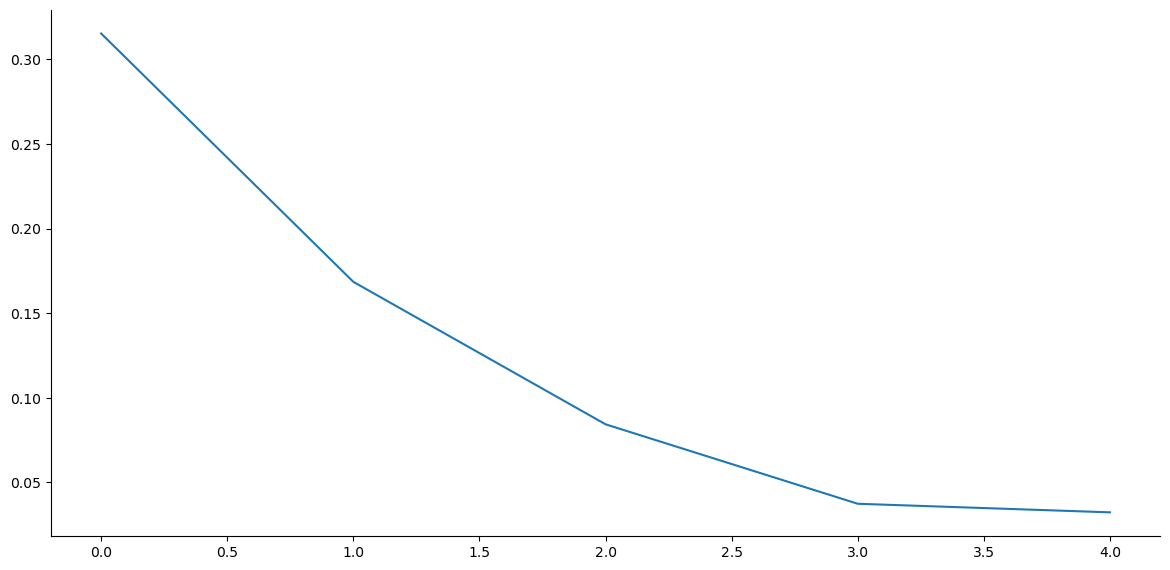

In [32]:
sns.relplot( kind="line", data=pca_dec.explained_variance_ratio_,height=6,aspect=2)
plt.show()

In [33]:
#estimate kmeans clusters
estimate_kmean_para(X=compressed_data,max_cluster=5)       

n_clusters: 2 average silhouette : 0.3284229551151003
***stat on deviation***
mean 0.07101739584258887
max 0.08517595399461084
n_clusters: 3 average silhouette : 0.29974965447816015
***stat on deviation***
mean 0.07854600827233471
max 0.10703941829808561
n_clusters: 4 average silhouette : 0.2699742482593884
***stat on deviation***
mean 0.07309856041084231
max 0.12976378460260118


In [34]:
kmean_cl = KMeans(n_clusters=2, n_init="auto", random_state=1110)
kmean_labels = kmean_cl.fit_predict(compressed_data)
compressed_data['cluster'] = kmean_labels
compressed_data['real'] = (feature_data.label=='real').astype(int)
res=compressed_data.groupby(['cluster'],as_index=False).agg(tot=('real','count'),real=('real','sum'))
res['%_real']=res.real/res.tot
res                     

cluster   tot  real    %_real
0        0  4616  1812  0.392548
1        1  2884  1938  0.671983

#### eda - isomap

In [35]:
from sklearn.manifold import Isomap
isomap_embedding = Isomap(n_components=30)
minmax_corr = MinMaxScaler()
X_scaled = pd.DataFrame(minmax_corr.fit_transform(feature_data.loc[:,feature_data_predictors]))
emb_X = isomap_embedding.fit_transform(X_scaled)
#estimate kmeans clusters
estimate_kmean_para(X=emb_X,max_cluster=4)       

C:\Users\distefano\Anaconda3\envs\audio\lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\distefano\Anaconda3\envs\audio\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\distefano\Anaconda3\envs\audio\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\distefano\Anaconda3\envs\audio\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._

n_clusters: 2 average silhouette : 0.20478565196744367
***stat on deviation***
mean 0.0211119761196164
max 0.025510851729418776
n_clusters: 3 average silhouette : 0.23524264126986746
***stat on deviation***
mean 0.18262017856655302
max 0.31078461211730135


In [36]:
kmean_cl = KMeans(n_clusters=2, n_init="auto", random_state=1110)
kmean_labels = kmean_cl.fit_predict(emb_X)
X_scaled['cluster'] = kmean_labels
X_scaled['real'] = (feature_data.label=='real').astype(int)
res=X_scaled.groupby(['cluster'],as_index=False).agg(tot=('real','count'),real=('real','sum'))
res['%_real']=res.real/res.tot
res                     

cluster   tot  real    %_real
0        0  4664  1766  0.378645
1        1  2836  1984  0.699577

## EDA  - (clustering analysis)
    pick up a feature selection method for example isomap, apply kmeans, analyze features per cluster and see eventual differences among the classes

In [44]:
#suppose we selected isomap + kmeans
X_scaled = pd.DataFrame(minmax_corr.fit_transform(feature_data.loc[:,feature_data_predictors]),columns=feature_data_predictors)

emb_X = isomap_embedding.fit_transform(X_scaled)
kmean_cl = KMeans(n_clusters=2, n_init="auto", random_state=1110)
kmean_labels = kmean_cl.fit_predict(emb_X)
X_scaled['cluster'] = kmean_labels
X_scaled['real'] = feature_data.label

C:\Users\distefano\Anaconda3\envs\audio\lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\distefano\Anaconda3\envs\audio\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\distefano\Anaconda3\envs\audio\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\distefano\Anaconda3\envs\audio\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._

In [45]:
#original features(order is the same)
original_data = feature_data.loc[:,feature_data_predictors].copy()
original_data['cluster']=kmean_labels

<Axes: >

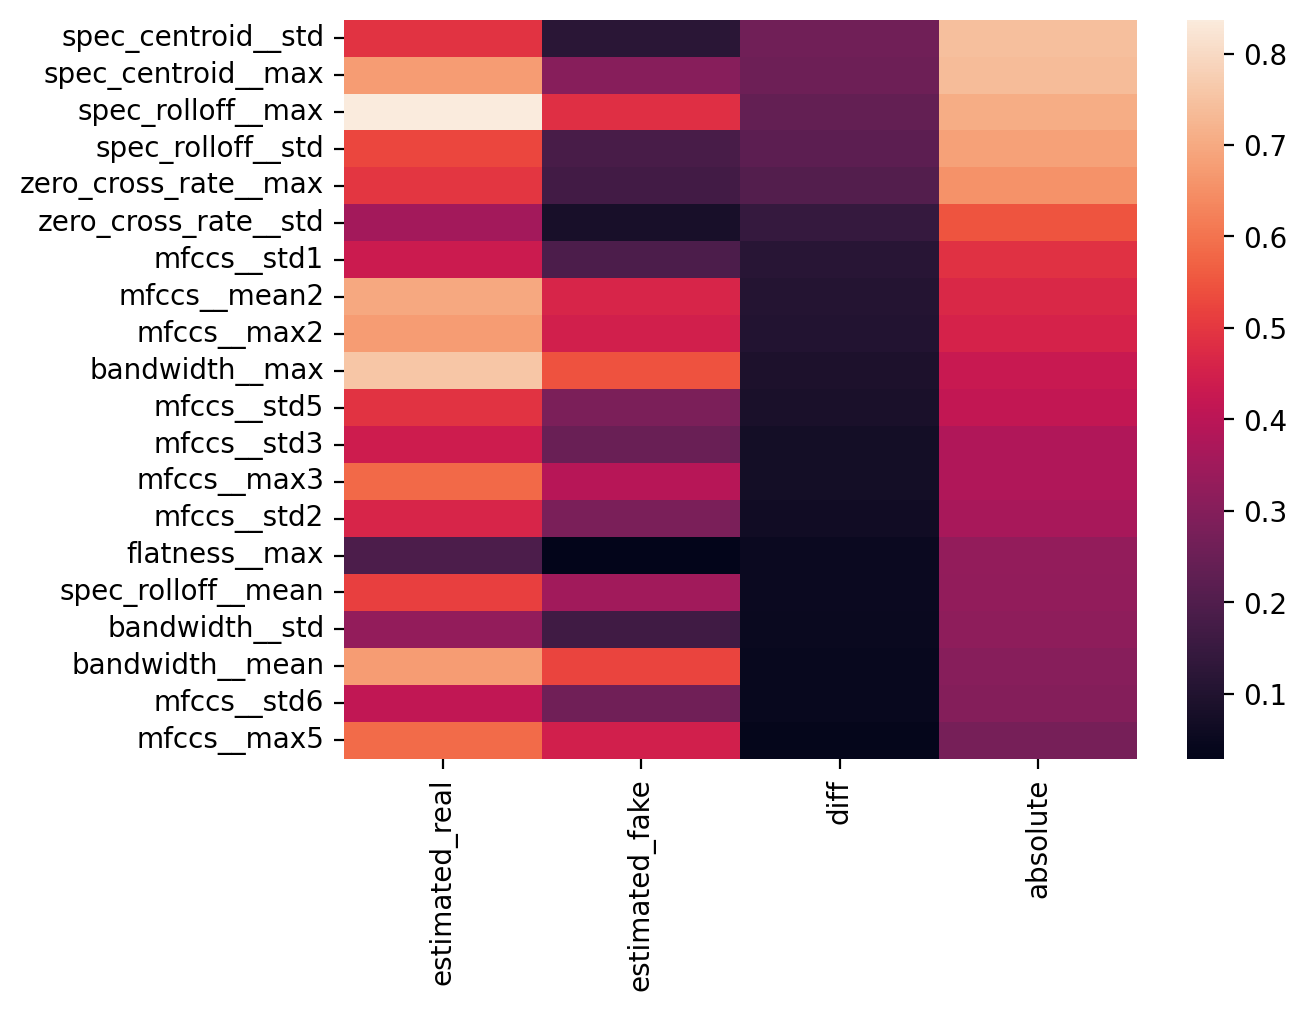

In [46]:
median_stat= X_scaled.loc[:,feature_data_predictors +['cluster']].groupby(['cluster']).quantile(0.5).T
median_stat.columns = ['estimated_real','estimated_fake']

median_stat['diff'] = np.log((median_stat.estimated_real - median_stat.estimated_fake)**2+1)*2
median_stat['absolute'] = np.abs(median_stat.estimated_real - median_stat.estimated_fake)*2

sns.heatmap(median_stat.sort_values(by=['diff'],ascending=False)[:20])

In [47]:
univariate_feature_diff=median_stat.sort_values(by=['diff'],ascending=False)[:30]
univariate_feature_diff

estimated_real  estimated_fake      diff  absolute
spec_centroid__std          0.490183        0.117446  0.260184  0.745474
spec_centroid__max          0.672994        0.304025  0.255269  0.737937
spec_rolloff__max           0.837137        0.484440  0.234491  0.705394
spec_rolloff__std           0.524824        0.182523  0.221597  0.684602
zero_cross_rate__max        0.496705        0.168963  0.204056  0.655482
zero_cross_rate__std        0.355106        0.081446  0.144436  0.547320
mfccs__std1                 0.434239        0.190306  0.115600  0.487865
mfccs__mean2                0.696899        0.462777  0.106727  0.468244
mfccs__max2                 0.674824        0.446459  0.101673  0.456731
bandwidth__max              0.757730        0.544159  0.089206  0.427142
mfccs__std5                 0.490649        0.282714  0.084657  0.415870
mfccs__std3                 0.438011        0.247130  0.071575  0.381762
mfccs__max3                 0.582558        0.392336  0.071090  0.380443
mfccs__std2                 0.462835        0.280960  0.065086  0.363750
flatness__max               0.191907        0.028639  0.052615  0.326536
spec_rolloff__mean          0.512770        0.351491  0.051357  0.322559
bandwidth__std              0.325815        0.167521  0.049496  0.316587
bandwidth__mean             0.675747        0.523929  0.045574  0.303636
mfccs__std6                 0.412414        0.262323  0.044555  0.300182
mfccs__max5                 0.584589        0.448142  0.036893  0.272893
mfccs__std4                 0.396207        0.268446  0.032382  0.255522
mfccs__std7                 0.429182        0.302011  0.032086  0.254343
mfccs__std9                 0.423732        0.303114  0.028888  0.241236
spec_centroid__mean         0.423711        0.310693  0.025385  0.226037
mfccs__max4                 0.591665        0.480239  0.024678  0.222851
mfccs__mean1                0.472366        0.583459  0.024532  0.222186
mfccs__mean3                0.535913        0.438996  0.018698  0.193834
mfccs__std13                0.416276        0.321853  0.017752  0.188846
mfccs__std0                 0.235400        0.141645  0.017503  0.187510
mfccs__std11                0.437523        0.347895  0.016002  0.179255

## Binary Classifiers
1. Knn
2. Random Forest
3. CNN

In [40]:
from sklearn.model_selection import GridSearchCV,validation_curve,PredefinedSplit
from sklearn.metrics import average_precision_score,make_scorer,f1_score

In [41]:
f1_custom_score = make_scorer(score_func = f1_score, pos_label='real')

In [42]:
X_train = pd.read_csv(os.path.join(os.getcwd(),'dataset','fake_audio','modeling','feature_dataset','train','feature_train_1s.csv'),header=0)
y_train = X_train.label 
X_train.drop(columns=['label'],inplace=True)
X_val = pd.read_csv(os.path.join(os.getcwd(),'dataset','fake_audio','modeling','feature_dataset','val','feature_val_1s.csv'),header=0)
y_val = X_val.label 
X_val.drop(columns=['label'],inplace=True)

y_all = pd.concat([y_train, y_val],axis=0)
y_all.index = range(len(y_all))
print(y_all.shape)

(7500,)


## Knn 

In [137]:
from sklearn.neighbors import KNeighborsClassifier
minmax_scaler = MinMaxScaler()
X_train_scaled= pd.DataFrame(minmax_scaler.fit_transform(X_train),columns=X_train.columns)
X_val_scaled=pd.DataFrame(minmax_scaler.transform(X_val), columns=X_val.columns)
X_all_scaled =  pd.concat([X_train_scaled, X_val_scaled],axis=0)
X_all_scaled.index = range(len(X_all_scaled))
ps = PredefinedSplit([-1]*len(X_train) + [0]*len(X_val))

In [141]:
selected_feature=univariate_feature_diff.index
n_neighbors_range=np.arange(5,50,2)
train_score, val_score = validation_curve(KNeighborsClassifier(), X_all_scaled.loc[:,selected_feature], y_all,
                                           param_name="n_neighbors",
                                           param_range=n_neighbors_range,
                                           cv=ps, scoring=f1_custom_score)

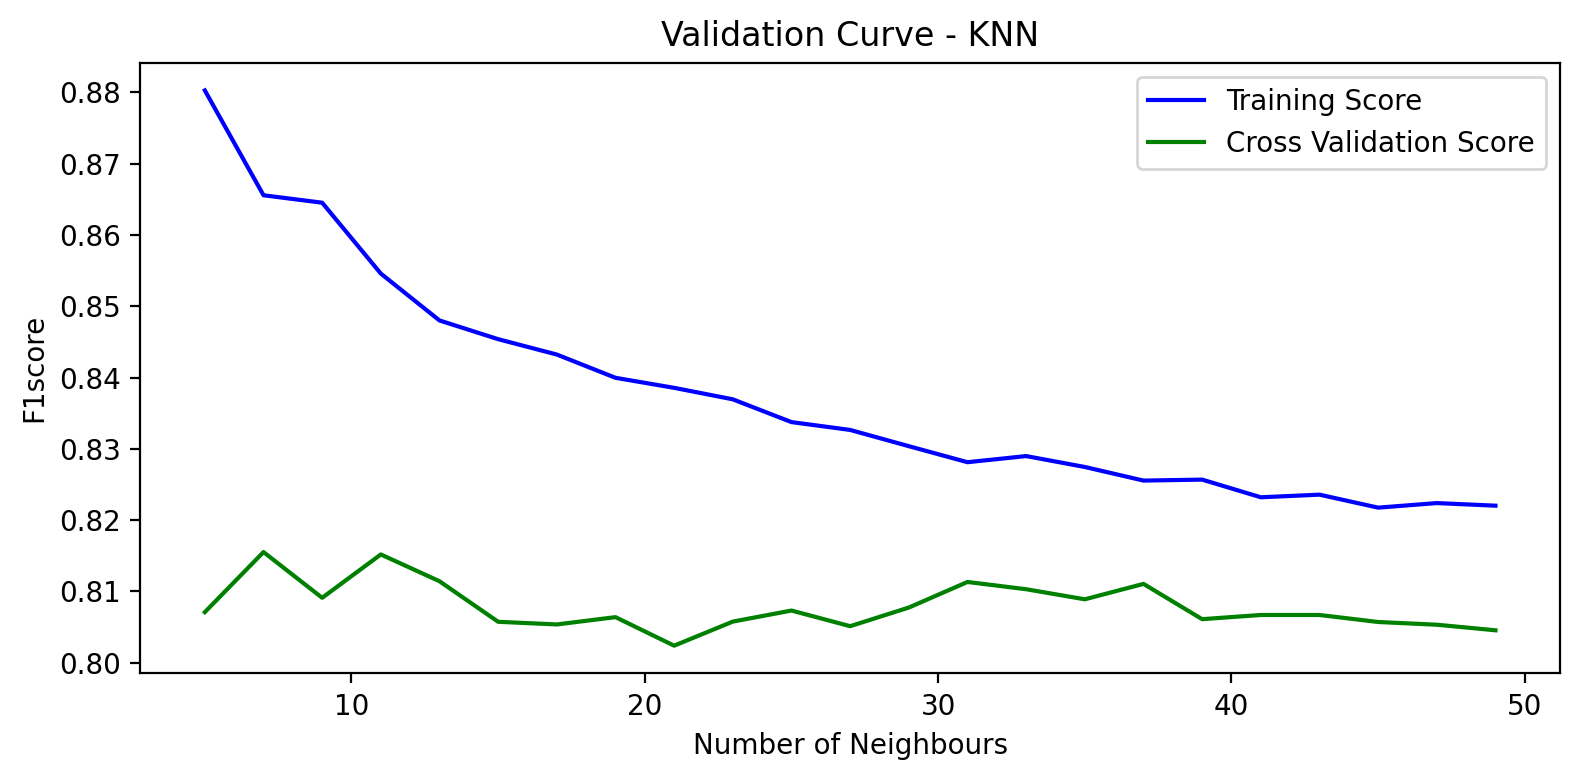

In [142]:
plt.figure(figsize=(8,4))
# Calculating mean of training score
mean_train_score = np.mean(train_score, axis=1)
# Calculating mean of validion score
mean_val_score = np.mean(val_score, axis=1)
# Plot mean accuracy scores for training and validation
plt.plot(n_neighbors_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(n_neighbors_range, mean_val_score,
         label="Cross Validation Score", color='g')
 
# Creating the plot
plt.title("Validation Curve - KNN")
plt.xlabel("Number of Neighbours")
plt.ylabel("F1score")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

In [145]:
kn_model=KNeighborsClassifier(n_neighbors=7)
predicted=kn_model.fit(X=X_train_scaled.loc[:,selected_feature],y=y_train).predict(X_val_scaled.loc[:,selected_feature])
print('f1 score (real):',f1_score(y_pred=predicted,y_true=y_val,pos_label='real'))
print('f1 score (fake):',f1_score(y_pred=predicted,y_true=y_val,pos_label='fake'))

f1 score (real): 0.8155146693187468
f1 score (fake): 0.7866589994249568


## Random Forest 

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X_all =  pd.concat([X_train, X_val],axis=0)
X_all.index = range(len(X_all))
ps = PredefinedSplit([-1]*len(X_train) + [0]*len(X_val))

rf = RandomForestClassifier(n_estimators=10, random_state=0)
grid_param = {
    #'class_weight':['balanced','balanced_subsample'],
    'n_estimators':[200],
    'criterion': ['gini','entropy'],
    #'min_samples_leaf':[1],
    #'max_leaf_nodes':[4,24],
     'max_features':np.arange(2,int(np.sqrt(X_train.loc[:,feature_data_predictors].shape[1])+1),2),
    'bootstrap': [True,False],
    'max_depth':[6,7,8,10]
}
#cv_model = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
gd_sr = GridSearchCV(
                    estimator=rf,
                    param_grid=grid_param,
                     scoring=f1_custom_score,
                     cv=ps,
                     n_jobs=-1)
gd_sr.fit(X_all.loc[:,feature_data_predictors], y_all.values.reshape(-1))
print("best_parametes:",gd_sr.best_params_)
print("best scores:",gd_sr.best_score_)

In [149]:
from sklearn.inspection import permutation_importance

#avg_prec_rec = make_scorer(average_precision_score,average='weighted',needs_threshold=True)
rf_fitted = RandomForestClassifier(n_estimators=200,bootstrap=False, criterion='entropy', max_depth=10, max_features=8, random_state=0)
rf_fitted.fit(X_train.loc[:,feature_data_predictors], y_train.values.reshape(-1))

train_result = permutation_importance(
    rf_fitted, X_train.loc[:,feature_data_predictors], y_train, n_repeats=5, random_state=42, n_jobs=2,scoring=f1_custom_score
)
val_results = permutation_importance(
    rf_fitted, X_val.loc[:,feature_data_predictors], y_val, n_repeats=5, random_state=42, n_jobs=2,scoring=f1_custom_score
)
sorted_importances_idx = train_result.importances_mean.argsort()
train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
val_importances = pd.DataFrame(
    val_results.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)

In [150]:
val_importances

mfccs__mean17  mfccs__mean2  mfccs__max2  mfccs__mean19  mfccs__std13  \
0      -0.000065      0.002585    -0.000854       0.000557      0.000915   
1      -0.000065      0.001114     0.000755       0.001114      0.002653   
2       0.001405      0.000000    -0.000296       0.000000      0.000425   
3      -0.001048      0.000000     0.000262       0.003419      0.000000   
4       0.000000      0.002653     0.002653       0.001672      0.001048   

   zero_cross_rate__max  mfccs__mean6  mfccs__mean18  mfccs__std10  \
0              0.000557     -0.000919      -0.000491     -0.000556   
1              0.000000      0.002231      -0.000065      0.000491   
2             -0.000491      0.004891       0.000000     -0.000130   
3              0.000491      0.002653      -0.000556     -0.001048   
4              0.001114      0.003280       0.000000     -0.001048   

   mfccs__max9  ...  mfccs__mean9  mfccs__std1  mfccs__max15  flatness__max  \
0     0.000491  ...      0.042782     0.007848      0.002790       0.003280   
1     0.000981  ...      0.039592     0.003979     -0.000296       0.003840   
2    -0.000556  ...      0.031671     0.006085      0.000755       0.001314   
3     0.000981  ...      0.036286     0.008456      0.002366       0.005941   
4     0.000425  ...      0.035681     0.006774      0.004190       0.006919   

   mfccs__max7  mfccs__mean7  rmse__std  mfccs__std12  mfccs__std2  \
0     0.004471      0.008264   0.029153      0.009539     0.014343   
1     0.005798      0.005523   0.022680      0.009279     0.015971   
2     0.007701      0.007211   0.021308      0.008307     0.010525   
3     0.004891      0.007701   0.026541      0.008233     0.014343   
4     0.004471      0.007701   0.022283      0.007821     0.011326   

   mfccs__std5  
0     0.003701  
1     0.007407  
2     0.005238  
3     0.007137  
4     0.003632  

[5 rows x 78 columns]

In [151]:
train_importance_beste_feature=train_importances.mean(axis=0).sort_values(ascending=False)
print('train importance sorted feature:\n',train_importance_beste_feature[:30])

train importance sorted feature:
 mfccs__std5              0.005957
mfccs__std2              0.005953
mfccs__std12             0.005853
rmse__std                0.005739
mfccs__mean7             0.004090
mfccs__max7              0.003889
flatness__max            0.003494
mfccs__max15             0.003052
mfccs__std1              0.002707
mfccs__mean9             0.002639
mfccs__max18             0.002611
mfccs__std3              0.002436
spec_centroid__std       0.002369
mfccs__mean10            0.002057
bandwidth__mean          0.002039
mfccs__max19             0.001911
mfccs__std8              0.001794
mfccs__mean16            0.001700
flatness__std            0.001669
mfccs__max1              0.001667
mfccs__max10             0.001530
mfccs__std4              0.001529
rmse__mean               0.001492
mfccs__mean3             0.001491
mfccs__mean4             0.001458
mfccs__max14             0.001284
zero_cross_rate__mean    0.001110
mfccs__mean14            0.001078
spec_centroid_

In [152]:
val_importance_beste_feature=val_importances.mean(axis=0).sort_values(ascending=False)
print('test importance sorted feature:\n',val_importance_beste_feature[:30])

test importance sorted feature:
 mfccs__mean9             0.037203
rmse__std                0.024393
mfccs__mean15            0.016216
mfccs__std2              0.013301
mfccs__std8              0.011514
spec_centroid__std       0.009318
mfccs__std12             0.008636
bandwidth__mean          0.008484
mfccs__std3              0.008207
mfccs__mean7             0.007280
spec_centroid__mean      0.007153
mfccs__std1              0.006628
mfccs__max18             0.006170
mfccs__max8              0.006070
mfccs__max1              0.005698
mfccs__max7              0.005466
bandwidth__std           0.005425
mfccs__std5              0.005423
mfccs__std6              0.005130
mfccs__mean14            0.004845
mfccs__mean8             0.004302
flatness__max            0.004259
mfccs__mean11            0.003783
mfccs__max19             0.003420
mfccs__mean10            0.003141
mfccs__mean4             0.003063
mfccs__max10             0.002809
zero_cross_rate__mean    0.002749
mfccs__std16   

In [ ]:
rf_features = val_importance_beste_feature[:30].index

In [43]:
rf_fitted = RandomForestClassifier(n_estimators=200,bootstrap=False, criterion='entropy', max_depth=10, max_features=8, random_state=0)

In [154]:
predicted=rf_fitted.fit(X=X_train.loc[:,rf_features],y=y_train).predict(X_val.loc[:,rf_features])
print('f1 score (real):',f1_score(y_pred=predicted,y_true=y_val,pos_label='real'))
print('f1 score (fake):',f1_score(y_pred=predicted,y_true=y_val,pos_label='fake'))

f1 score (real): 0.912262156448203
f1 score (fake): 0.9106566200215285


In [44]:
predicted_all=rf_fitted.fit(X=X_train,y=y_train).predict(X_val)
print('f1 score (real):',f1_score(y_pred=predicted_all,y_true=y_val,pos_label='real'))
print('f1 score (fake):',f1_score(y_pred=predicted_all,y_true=y_val,pos_label='fake'))

f1 score (real): 0.9360587002096437
f1 score (fake): 0.9337676438653637
